In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from matplotlib.ticker import MaxNLocator
from scipy.stats import binom
from scipy.ndimage import uniform_filter
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

import warnings
warnings.filterwarnings('ignore')

In [2]:
nave_num = 35

In [3]:
data = pd.DataFrame()
for nave in [17,32,33,34,35]:
    for tiempo in list(range(1,13)):
        filename = f'./NAVE {nave}-{tiempo}.xlsx'
        if os.path.exists(filename):
            try:
                df = pd.read_excel(filename, header=[4]).drop('Unnamed: 0', axis=1)
                df = df.drop(df.index[-4:])
                df = df.melt(id_vars=['Unnamed: 1', 'Unnamed: 2'])
                df.columns = ['Tunel', 'Surco', 'Sitio_siembra', 'P-A']
                df['P-A'] = df['P-A'].fillna(0)
                df = df.ffill().infer_objects(copy=False)
                df['Sitio_siembra'] = pd.to_numeric(df['Sitio_siembra'], errors='coerce')
                df['Slap'] = (df['Sitio_siembra'] % 1 * 100).round().astype(int) + 1
                df['Sitio_siembra'] = df['Sitio_siembra'].astype(int)
                df['Nave'] = nave
                df['Tiempo'] = tiempo
                data = pd.concat([data, df], axis=0)
            except Exception:
                pass
        else:
            pass


In [4]:
data.columns

Index(['Tunel', 'Surco', 'Sitio_siembra', 'P-A', 'Slap', 'Nave', 'Tiempo'], dtype='object')

In [5]:
data['Nave'].unique()

array([17, 32, 33, 34, 35])

In [6]:
def coef_var(x):
    return np.var(x) / np.mean(x) * 100

población = data.groupby(['Nave','Tiempo'])['P-A'].agg(['mean','std','var',coef_var]).reset_index()

# Traditional method


In [7]:
Z = 1.96 
E = 0.05
m1 = []

for nave in data['Nave'].unique():
    for tiempo in data['Tiempo'].unique():
        df = data[(data['Nave']==nave)&(data['Tiempo']==tiempo)]
        N = len(df)
        p = np.mean(df['P-A'])
        n = (N * Z**2 * p * (1 - p)) / (E**2 * (N-1) + Z**2 * p * (1 - p))
        m1.append({'Nave': nave, 'Tiempo': tiempo, 'n': n,'Incidence':p*100})

In [8]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

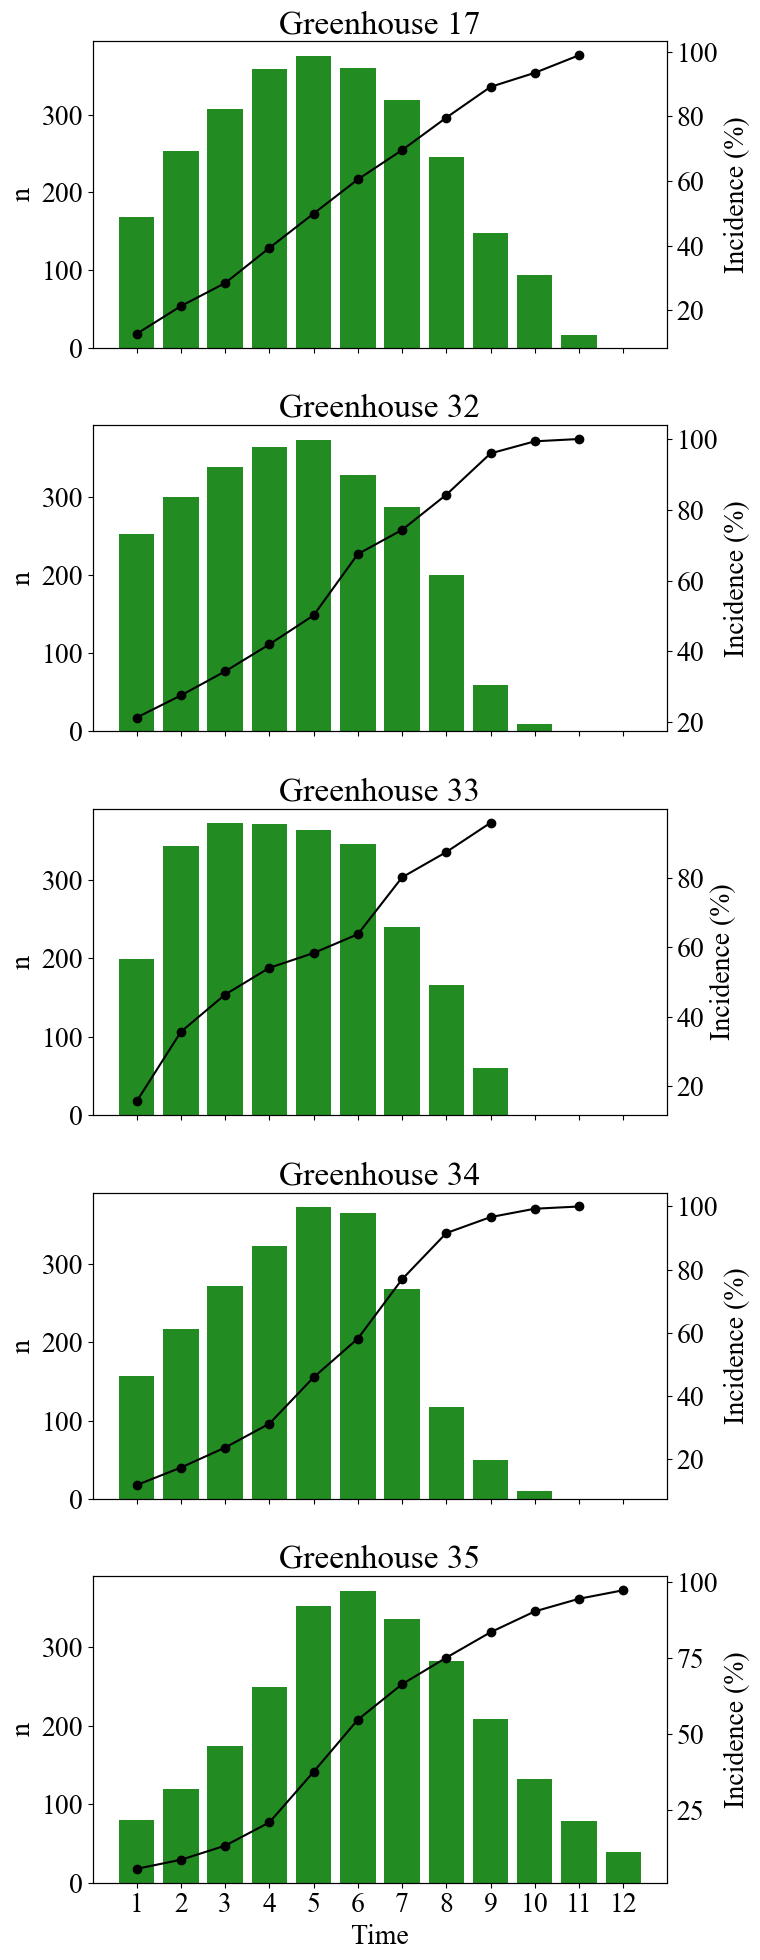

In [9]:
df_resultados = pd.DataFrame(m1)
naves = df_resultados['Nave'].unique()
tiempos = np.arange(1, 13)

fig, axes = plt.subplots(len(naves), 1, sharex=True, figsize=(8, 4*len(naves)))
for ax, nave in zip(axes, naves):
    df_plot = df_resultados[df_resultados['Nave'] == nave].sort_values('Tiempo')

    x = df_plot['Tiempo']
    y = df_plot['n']

    ax.bar(x, y, color='forestgreen', width=0.8)

    ax.set_title(f'Greenhouse {nave}')
    ax.set_ylabel('n')
    ax.set_xticks(tiempos)

    ax2 = ax.twinx()
    ax2.plot(df_plot['Tiempo'], df_plot['Incidence'], color='black', marker='o')
    ax2.set_ylabel('Incidence (%)', color='black')
    ax2.tick_params(axis='y', colors='black')

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

In [10]:
n_opt_for_prop = df_plot.copy()

Probability distributions

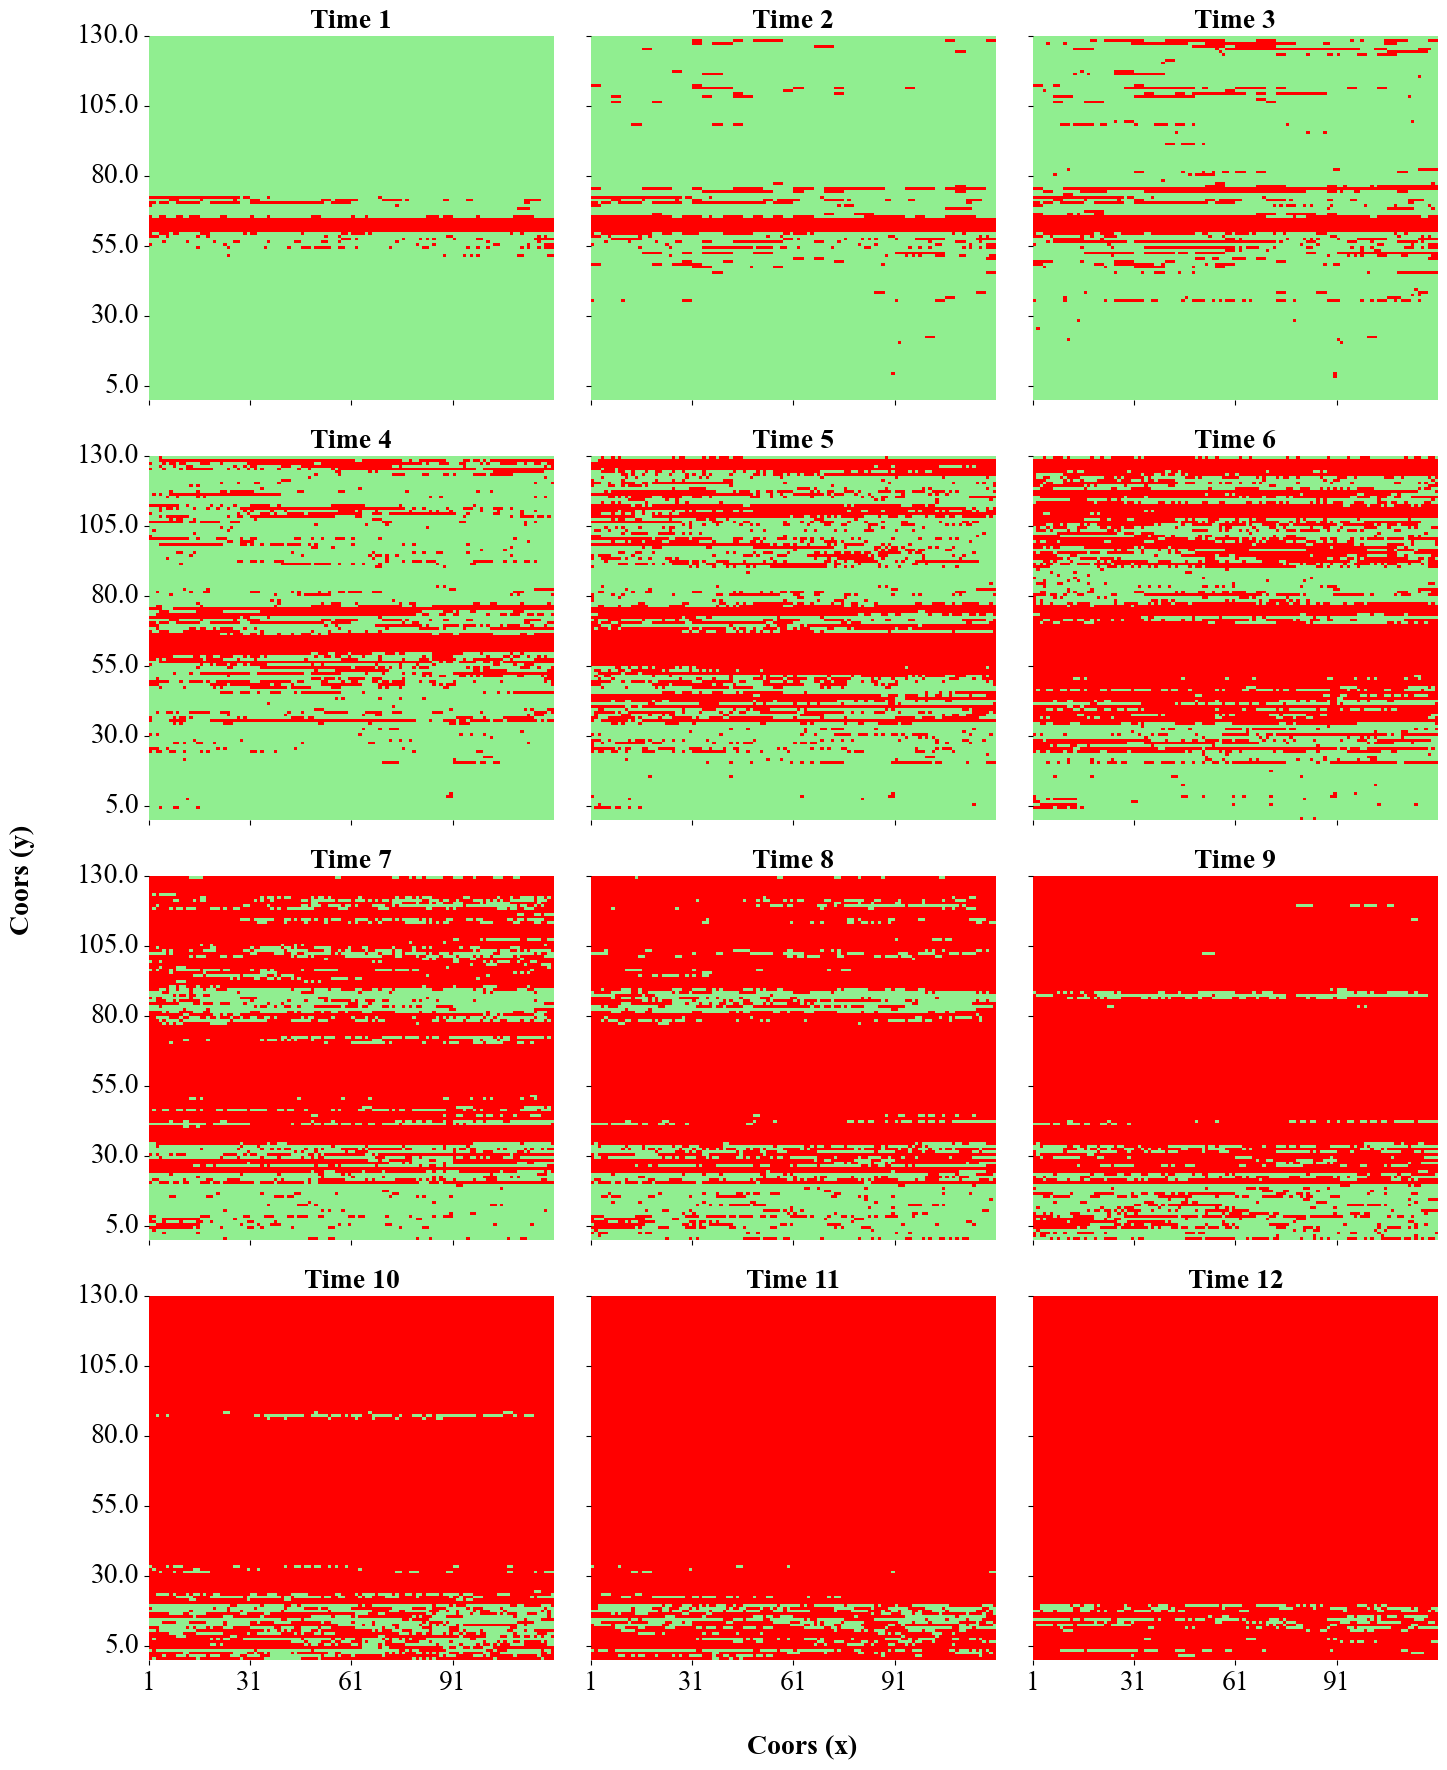

In [13]:
data_35 = data[data['Nave'] == nave_num]
tiempos = sorted(data_35['Tiempo'].unique())
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 20), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (tiempo, ax) in enumerate(zip(tiempos, axes)):
    df = data_35[data_35['Tiempo'] == tiempo]
    Plot = df.pivot(index='Surco', columns='Sitio_siembra', values='P-A')
    Plot = Plot.sort_index(ascending=False)
    custom_cmap = LinearSegmentedColormap.from_list("custom", ['lightgreen', 'red'])

    sns.heatmap(Plot, cmap=custom_cmap, cbar=False, ax=ax)

    ax.set_title(f"Time {tiempo}", fontsize=20, fontweight='bold')
    ax.set_ylabel('')
    ax.set_xlabel('')

    y_ticks_pos = list(range(0, len(Plot.index), 25))
    y_ticks_labels = [Plot.index[i] for i in y_ticks_pos if i < len(Plot.index)]
    ax.set_yticks(y_ticks_pos)
    ax.set_yticklabels(y_ticks_labels)

    x_ticks_pos = list(range(0, len(Plot.columns), 30))
    x_ticks_labels = [Plot.columns[i] for i in x_ticks_pos if i < len(Plot.columns)]
    ax.set_xticks(x_ticks_pos)
    ax.set_xticklabels(x_ticks_labels, rotation=0)

for ax in axes[len(tiempos):]:
    ax.set_visible(False)

fig.supxlabel("Coors (x)", fontsize=20, fontweight='bold', y=0.06)
fig.supylabel("Coors (y)", fontsize=20, fontweight='bold', x=0.06)

plt.tight_layout(rect=[0.05, 0.05, 0.87, 0.95])
plt.show()

In [14]:
data_35['Tiempo'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [15]:
data_fin = data_35[data_35['Tiempo'].isin([2,6,9,12])]
data_fin.groupby(['Nave','Tiempo'])['P-A'].agg(['mean','std','var',coef_var,'count']).reset_index()

Nave  Tiempo      mean       std       var   coef_var  count
0    35       2  0.085128  0.279081  0.077886  91.487179  15600
1    35       6  0.547051  0.497797  0.247802  45.294872  15600
2    35       9  0.835192  0.371019  0.137655  16.480769  15600
3    35      12  0.973654  0.160168  0.025654   2.634615  15600

In [16]:
data_6_35 = data_35[data_35['Tiempo']==6]
data_6_35.head()

Tunel  Surco  Sitio_siembra  P-A  Slap  Nave  Tiempo
0      1    1.0              1  0.0     1    35       6
1      1    2.0              1  0.0     1    35       6
2      1    3.0              1  0.0     1    35       6
3      1    4.0              1  0.0     1    35       6
4      1    5.0              1  1.0     1    35       6

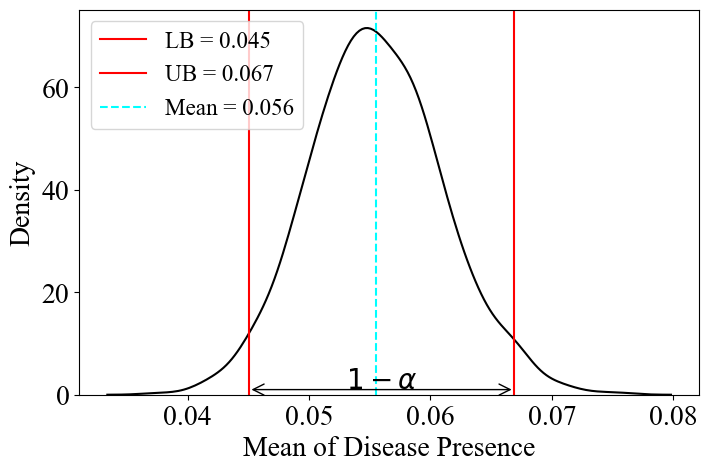

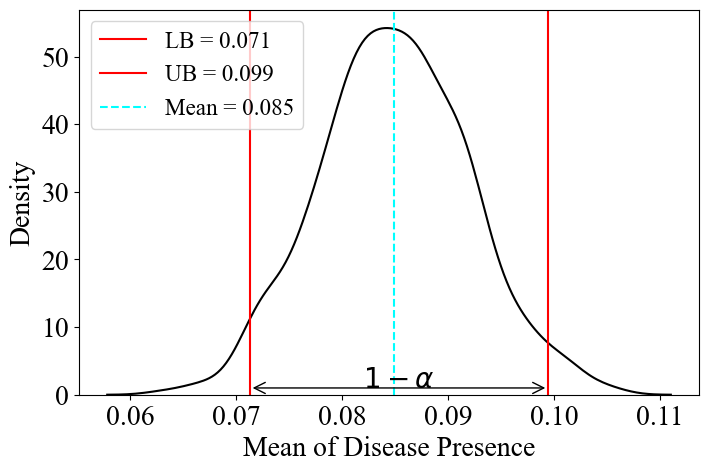

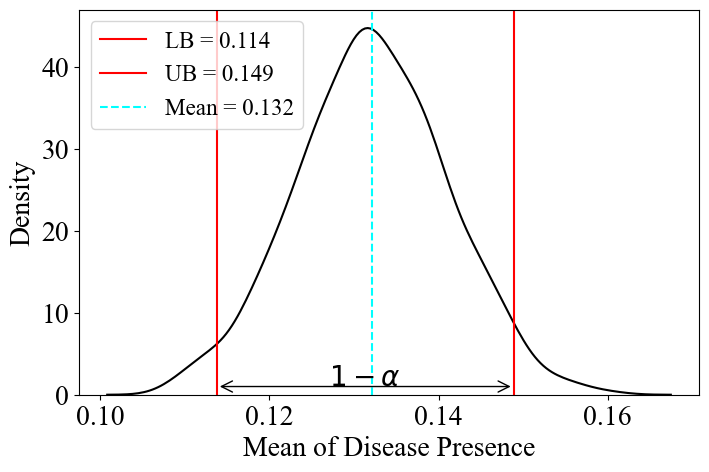

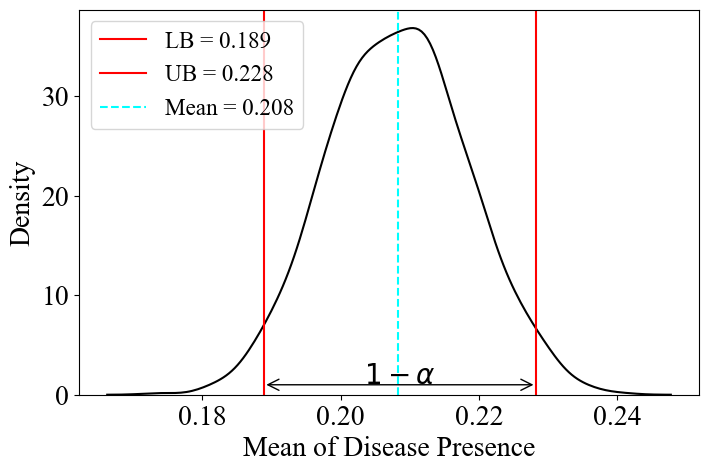

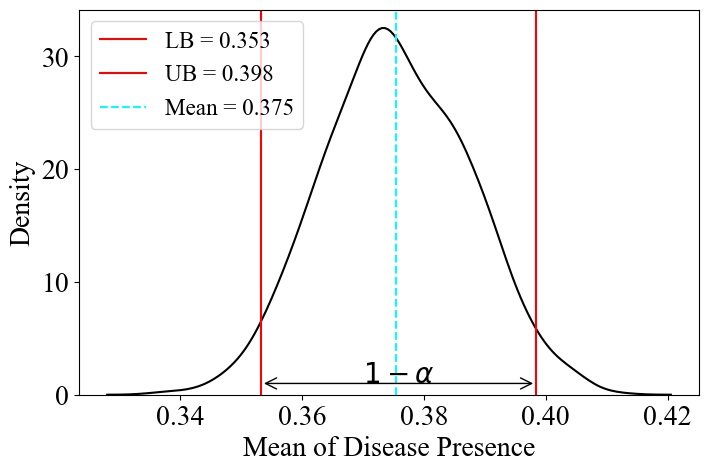

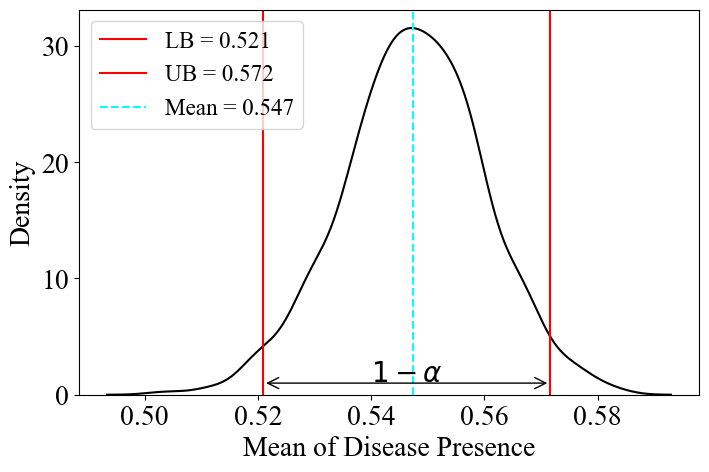

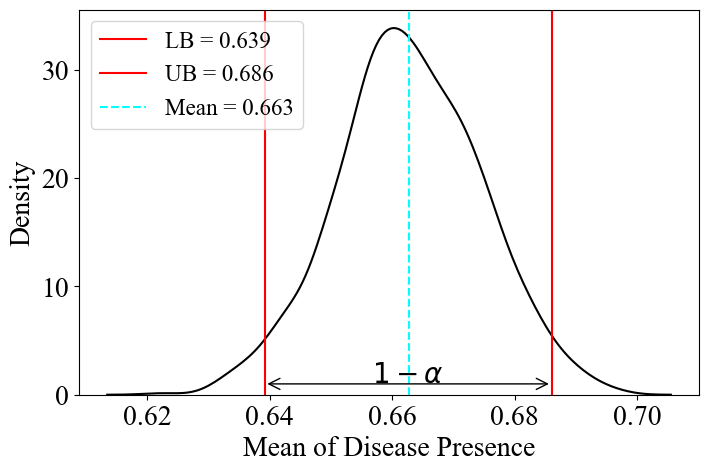

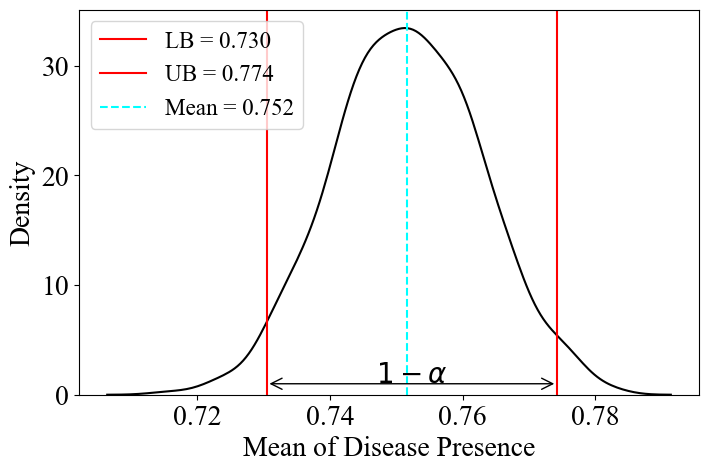

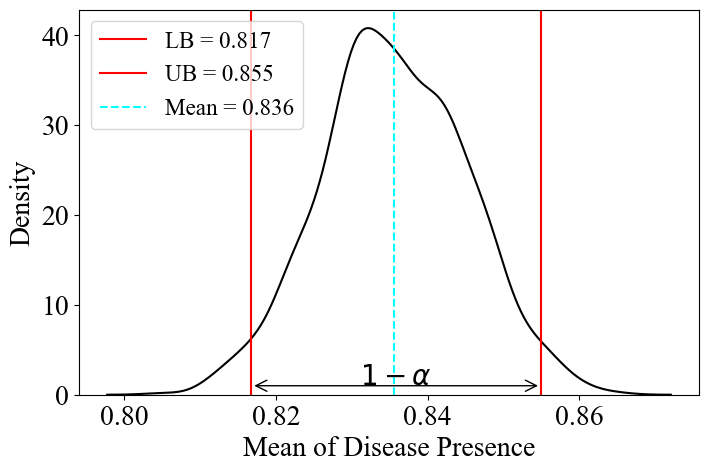

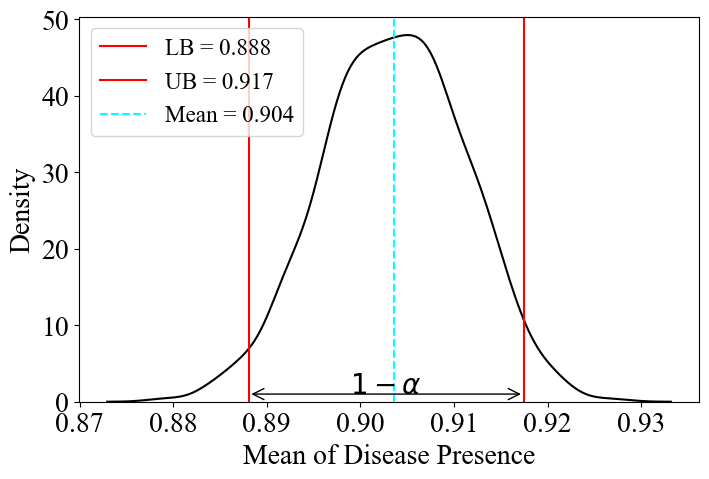

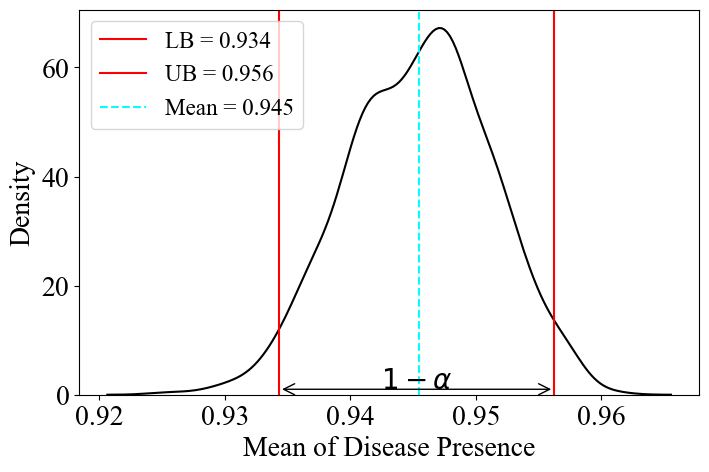

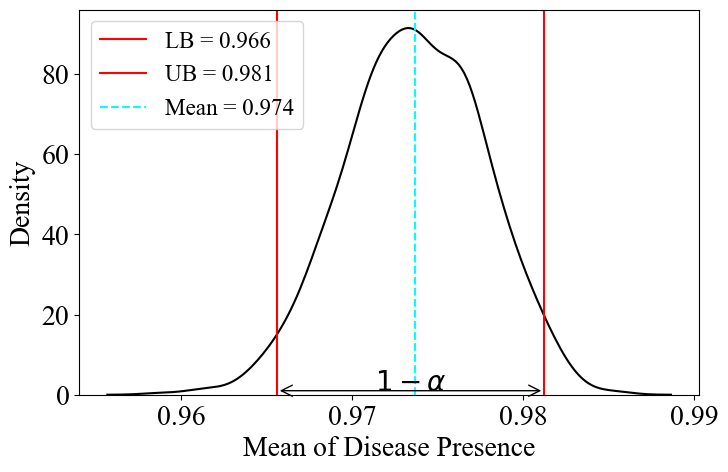

In [17]:
np.random.seed(2025)

n_iterations = 1000 
sample_size = 1599

for tiempo in data_35['Tiempo'].unique():
    data_6_35 = data_35[data_35['Tiempo']==tiempo]
    bootstrap_means = []
    for _ in range(n_iterations):
        sample = data_6_35.sample(n=sample_size, replace=True)
        bootstrap_means.append(sample['P-A'].mean())

    bootstrap_means = np.array(bootstrap_means)
    alpha = 0.05
    lower_bound = np.percentile(bootstrap_means, 100 * (alpha / 2))
    upper_bound = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
    mean_bootstrap = bootstrap_means.mean()
    
    plt.figure(figsize=(8, 5))
    sns.kdeplot(bootstrap_means, color='black', fill=False)
    plt.axvline(lower_bound, color='red', linestyle='-', label=f'LB = {lower_bound:.3f}')
    plt.axvline(upper_bound, color='red', linestyle='-', label=f'UB = {upper_bound:.3f}')
    plt.axvline(mean_bootstrap, color='cyan', linestyle='--', label=f'Mean = {mean_bootstrap:.3f}')
    plt.xlabel('Mean of Disease Presence')
    plt.ylabel('Density')
    plt.annotate('', xy=(lower_bound, 1), xytext=(upper_bound, 1),
                 arrowprops=dict(arrowstyle='<->', color='black'))
    plt.text((lower_bound + upper_bound)/2, 1.1, r'$1 - \alpha$', ha='center')
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

Tiempo 1, muestras optimo 15


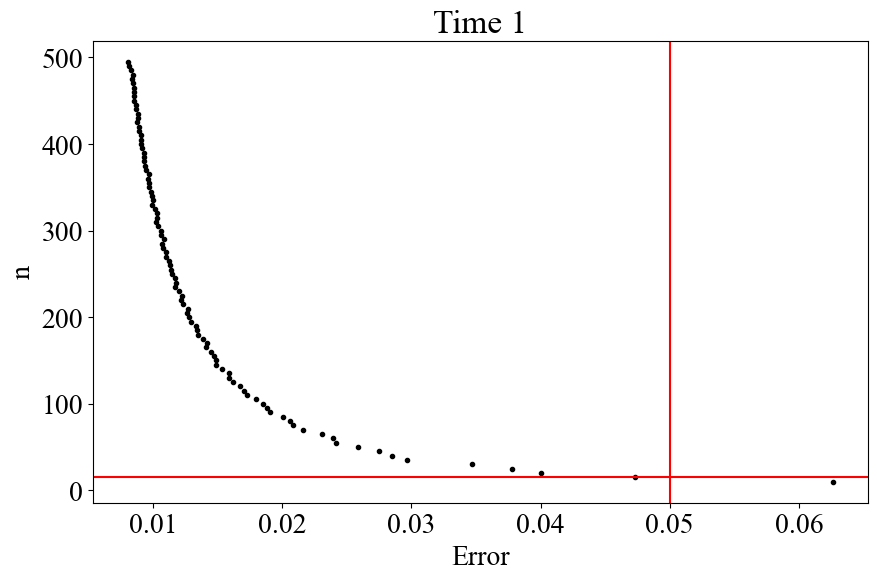

Tiempo 2, muestras optimo 25


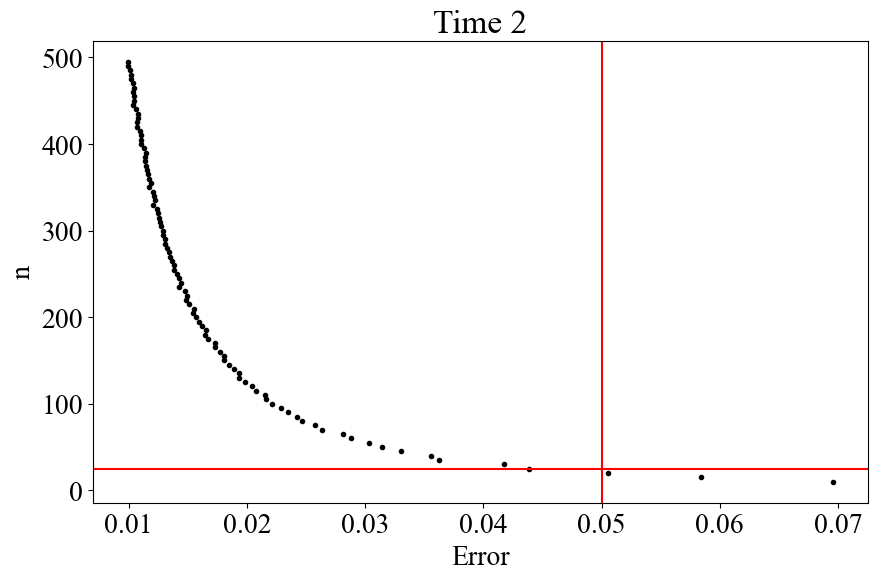

Tiempo 3, muestras optimo 30


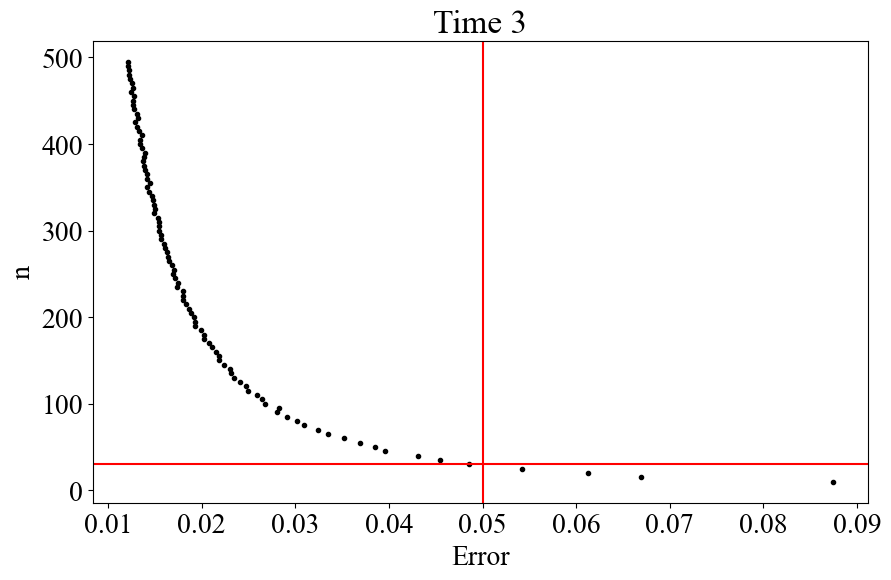

Tiempo 4, muestras optimo 45


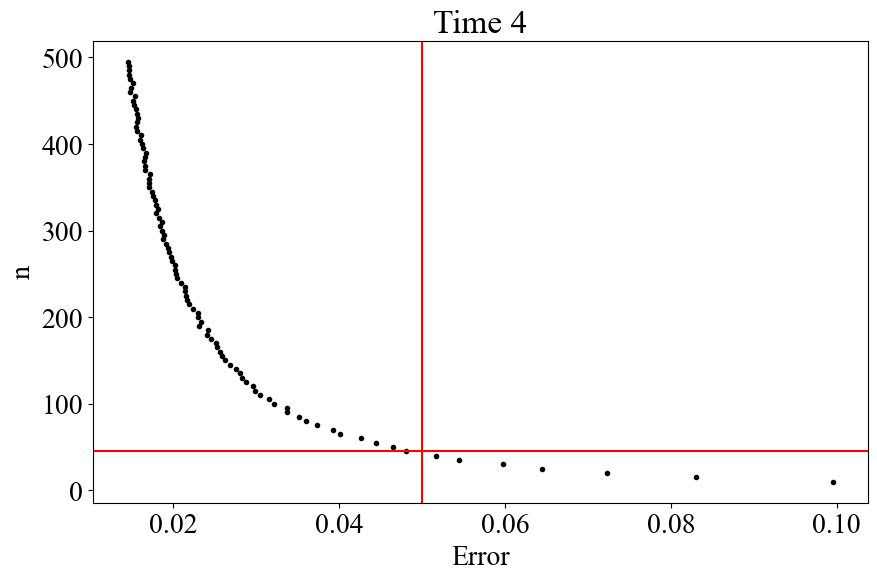

Tiempo 5, muestras optimo 65


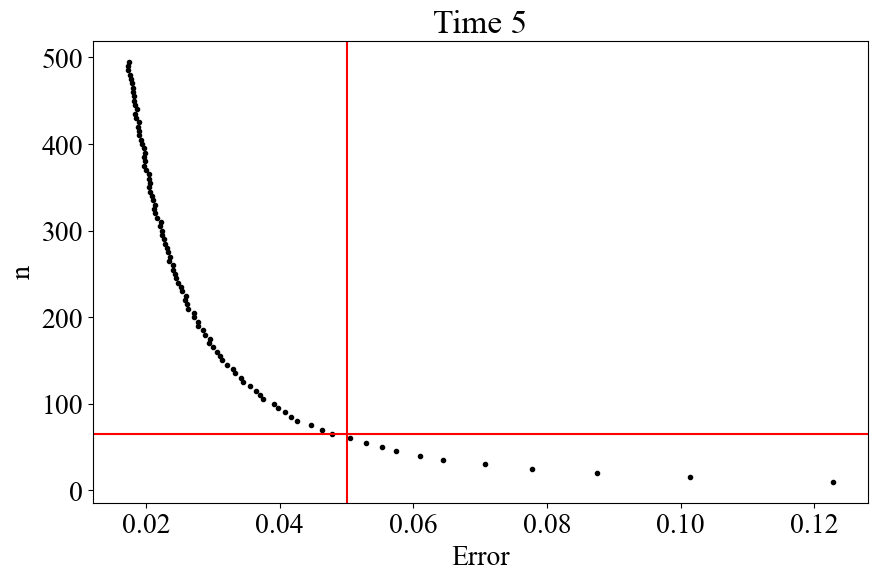

Tiempo 6, muestras optimo 65


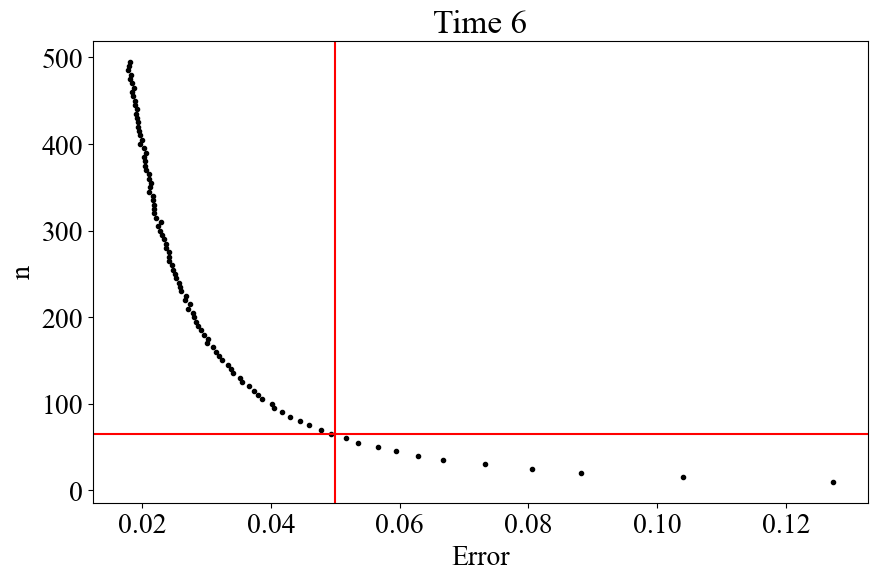

Tiempo 7, muestras optimo 60


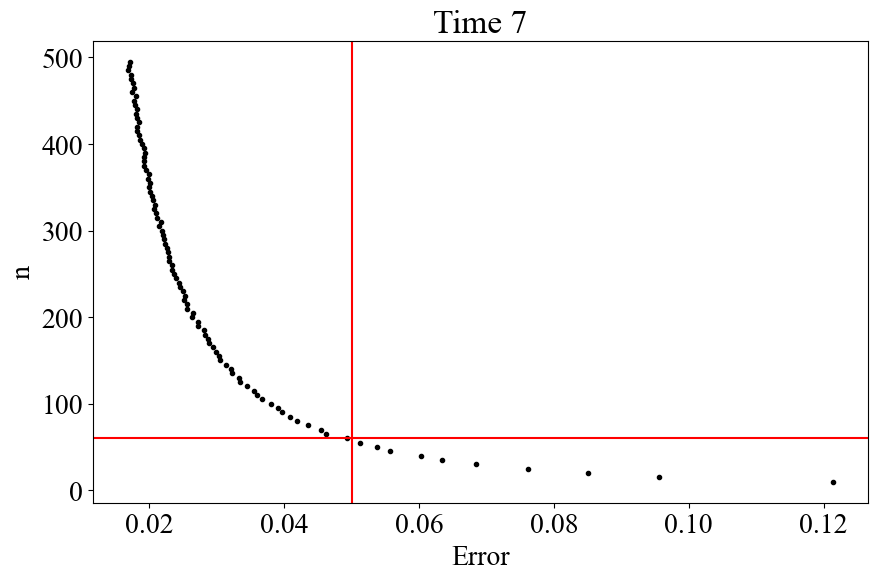

Tiempo 8, muestras optimo 50


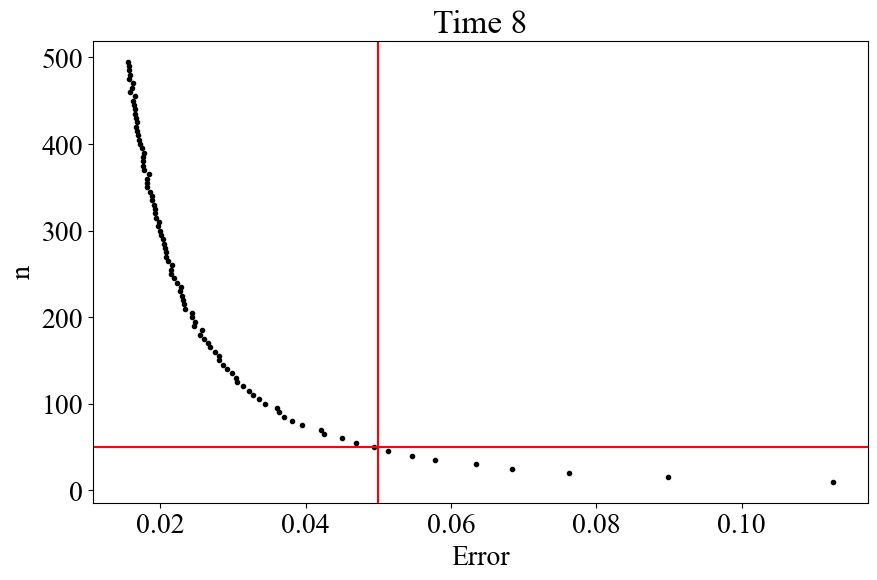

Tiempo 9, muestras optimo 35


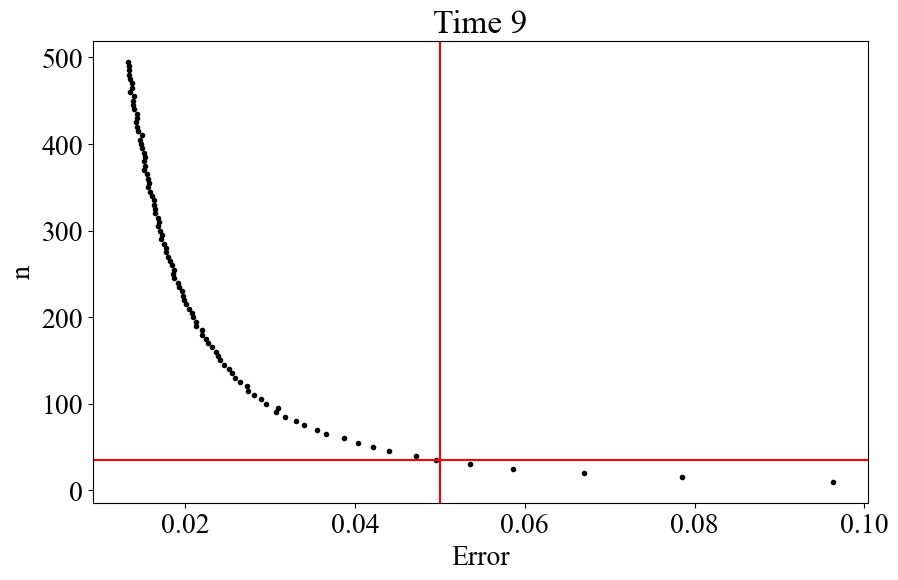

Tiempo 10, muestras optimo 25


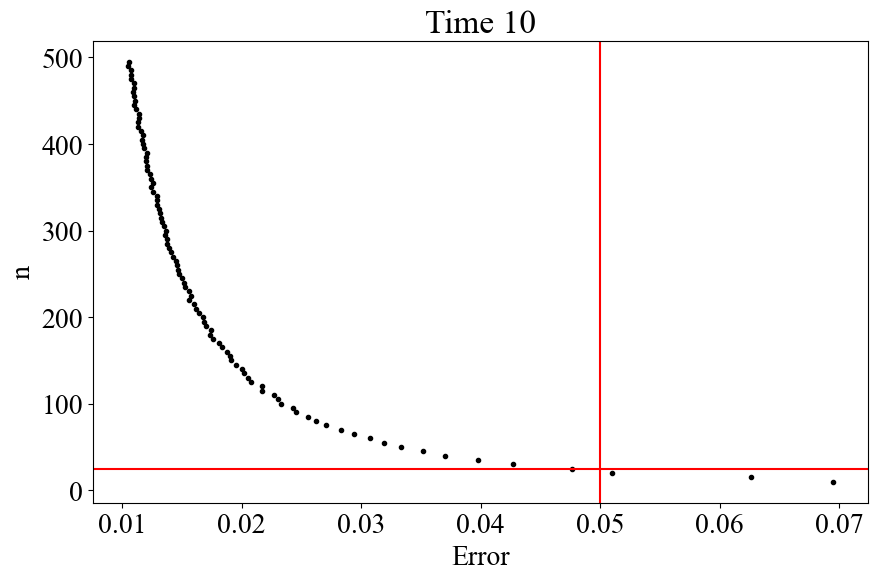

Tiempo 11, muestras optimo 15


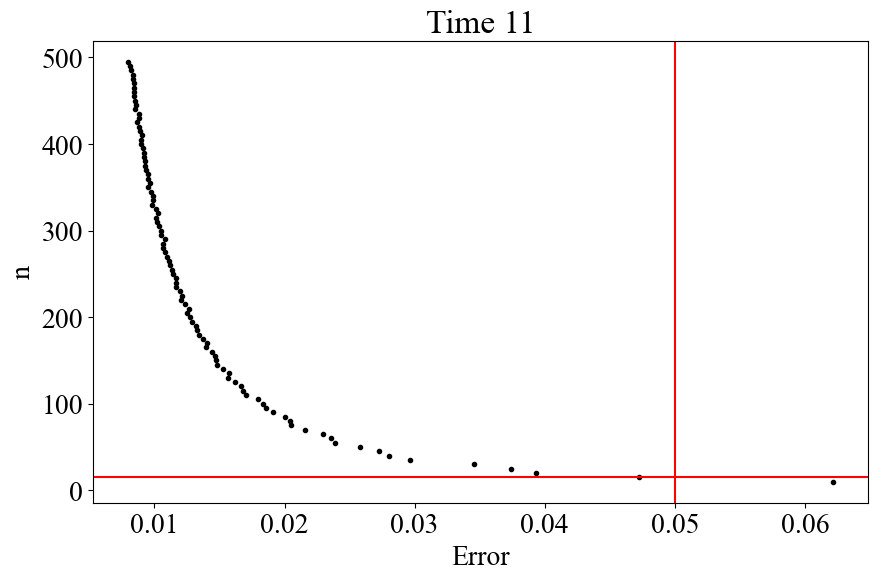

Tiempo 12, muestras optimo 10


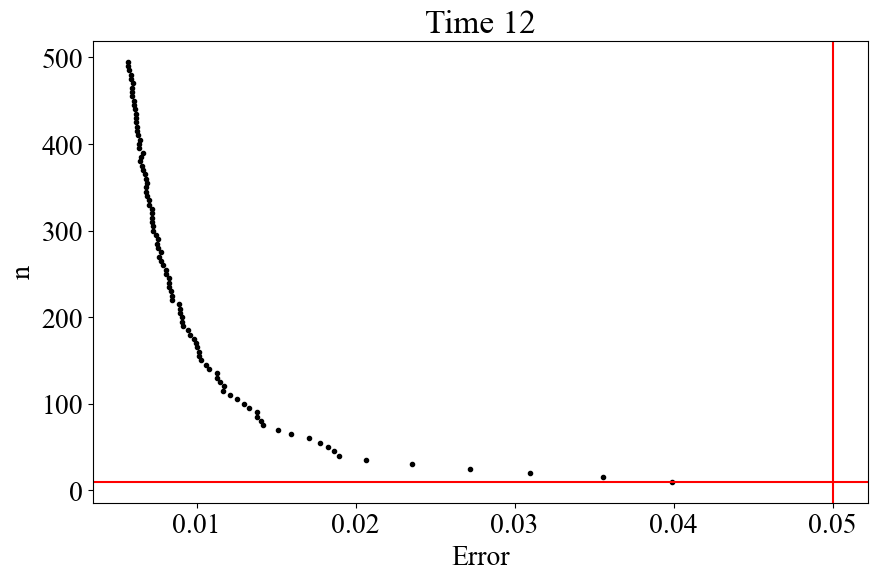

In [18]:
resultados = []
for tiempo in data_35['Tiempo'].unique():
    data_2_35 = data_35[data_35['Tiempo']==tiempo]
    p_hat = data_2_35['P-A'].mean()
    num_simulations = 10000
    error_objetivo = 0.05
    sample_sizes = np.arange(10, 500, 5)
    mean_errors = []

    np.random.seed(42)

    for n in sample_sizes:
        simulated_samples = np.random.binomial(1, p_hat, size=(num_simulations, n))
        sample_proportions = simulated_samples.mean(axis=1)
        errors = np.abs(sample_proportions - p_hat)
        mean_errors.append(errors.mean())

    mean_errors = np.array(mean_errors)

    idx_objetivo = np.where(mean_errors <= error_objetivo)[0][0]
    n_objetivo = sample_sizes[idx_objetivo]
    error_alcanzado = mean_errors[idx_objetivo]
    resultados.append({'Tiempo': tiempo, 'n_MC': n_objetivo})
    print(f'Time {tiempo}, optimal sample {n_objetivo}')
    plt.figure(figsize=(10, 6))
    plt.plot(mean_errors, sample_sizes, 'k.')  
    plt.axvline(x=error_objetivo, color='red', linestyle='-')  
    plt.axhline(y=n_objetivo, color='red', linestyle='-') 
    plt.title(f'Time {tiempo}')
    plt.xlabel('Error')
    plt.ylabel('n')
    plt.show()

n_opt_MC = pd.DataFrame(resultados)

In [19]:
n_opt = pd.merge(n_opt_for_prop,n_opt_MC, on='Tiempo')
n_opt

Nave  Tiempo           n  Incidence  n_MC
0     35       1   79.985572   5.538462    15
1     35       2  118.772116   8.512821    25
2     35       3  173.668447  13.160256    30
3     35       4  249.514310  20.846154    45
4     35       5  352.115595  37.519231    65
5     35       6  371.709452  54.705128    65
6     35       7  335.553645  66.384615    60
7     35       8  281.817517  75.147436    50
8     35       9  208.696299  83.519231    35
9     35      10  132.343387  90.391026    25
10    35      11   78.683539  94.557692    15
11    35      12   39.321106  97.365385    10

In [20]:
from scipy.spatial.distance import cdist
from matplotlib.path import Path
from sklearn.preprocessing import StandardScaler

In [21]:
seed = 2025
np.random.seed(2025)

def muestreo_sistematico_grilla(df, n):
    df_sorted = df.sort_values(['Surco', 'Sitio_siembra']).copy()
    surcos = np.sort(df_sorted['Surco'].unique())
    sitios = np.sort(df_sorted['Sitio_siembra'].unique())
    total_puntos = len(surcos) * len(sitios)
    n = min(n, total_puntos)
    n_surcos = int(np.sqrt(n))
    n_sitios = int(np.ceil(n / n_surcos))
    idx_surcos = np.linspace(0, len(surcos)-1, n_surcos, dtype=int)
    idx_sitios = np.linspace(0, len(sitios)-1, n_sitios, dtype=int)
    surcos_seleccionados = surcos[idx_surcos]
    sitios_seleccionados = sitios[idx_sitios]
    sample = df_sorted[
        df_sorted['Surco'].isin(surcos_seleccionados) & 
        df_sorted['Sitio_siembra'].isin(sitios_seleccionados)
    ]
    if len(sample) > n:
        sample = sample.sample(n=n, random_state=seed)
    return sample

def muestreo_estratificado(df, n):
    incidencia_surco = df.groupby('Surco')['P-A'].mean().reset_index()
    incidencia_surco['Incidencia_%'] = incidencia_surco['P-A'] * 100

    q1 = incidencia_surco['Incidencia_%'].quantile(0.25)
    q2 = incidencia_surco['Incidencia_%'].quantile(0.50)
    q3 = incidencia_surco['Incidencia_%'].quantile(0.75)

    def clasificar_estrato(p):
        if p <= q1:
            return 'Estrato 1 (≤ Q1)'
        elif p <= q2:
            return 'Estrato 2 (Q1–Q2)'
        elif p <= q3:
            return 'Estrato 3 (Q2–Q3)'
        else:
            return 'Estrato 4 (> Q3)'

    incidencia_surco['Estrato'] = incidencia_surco['Incidencia_%'].apply(clasificar_estrato)

    df_estratificado = pd.merge(df, incidencia_surco[['Surco', 'Estrato']], on='Surco')

    estratos_unicos = df_estratificado['Estrato'].unique()
    n_por_estrato = max(1, n // len(estratos_unicos))

    muestras = []
    for estrato in estratos_unicos:
        df_estrato = df_estratificado[df_estratificado['Estrato'] == estrato]
        n_muestra_estrato = min(n_por_estrato, len(df_estrato))
        muestras.append(df_estrato.sample(n=n_muestra_estrato, random_state=seed))

    sample_estratificado = pd.concat(muestras)
    return sample_estratificado

def muestreo_cluster(df, n_muestra, eps=3, min_samples=5, random_state=42):


    X = df[['Sitio_siembra', 'Surco', 'P-A']].values

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    df = df.copy()
    df['cluster'] = db.labels_

    df = df[df['cluster'] != -1]

    if df.empty:
        raise ValueError("DBSCAN no encontró clusters válidos")

    cluster_sizes = df.groupby('cluster').size()
    n_cluster = np.round((cluster_sizes / cluster_sizes.sum()) * n_muestra).astype(int)

    diff = n_muestra - n_cluster.sum()
    if diff != 0:
        for i in cluster_sizes.sort_values(ascending=False).index[:abs(diff)]:
            n_cluster[i] += np.sign(diff)

    sample_list = []
    rng = np.random.default_rng(random_state)
    for cluster_id, n in n_cluster.items():
        subset = df[df['cluster'] == cluster_id]
        n = min(len(subset), n) 
        if n > 0:
            sample_list.append(subset.sample(n=n, random_state=random_state))

    sample = pd.concat(sample_list, ignore_index=True)

    return sample.drop_duplicates(subset=['Surco', 'Sitio_siembra'])

def calcular_estadisticas(sample):
    x = sample['P-A']
    media = x.mean()
    std = x.std()
    var = x.var()
    cv = (var / media * 100) if media != 0 else np.nan
    n = len(sample)
    p = media
    prob_enferma = 1 - binom.pmf(0, n, p) if n > 0 else np.nan
    return media, std, var, cv, prob_enferma

def plot_heatmap(sample, tiempo, metodo, df_tiempo):
    full_grid = pd.DataFrame(
        [(f, s) for f in sorted(df_tiempo['Surco'].unique())
                for s in sorted(df_tiempo['Sitio_siembra'].unique())],
        columns=['Surco', 'Sitio_siembra']
    )

    merged = pd.merge(full_grid, sample[['Surco', 'Sitio_siembra', 'P-A']],
                      on=['Surco', 'Sitio_siembra'], how='left')

    Plot_sample = merged.pivot(index='Surco', columns='Sitio_siembra', values='P-A')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        Plot_sample,
        cmap=custom_cmap,
        cbar=False,
        mask=Plot_sample.isnull(),
        linewidths=0,
        linecolor=None,
        vmin=0,  
        vmax=1 
    )
    plt.title(f'Heatmap {metodo} - Time {tiempo}', fontsize=20)
    plt.xlabel('Sowing site', fontsize=16)
    plt.ylabel('Furrow', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

metodos = {
    'Random': lambda df, n: df.sample(n=n, random_state=seed),
    'Systematic on grid': muestreo_sistematico_grilla,
    'Stratified': muestreo_estratificado,
    'Cluster': muestreo_cluster
}


--- Tiempo: 1 | Tamaño muestra ajustado: 79 ---
Método: Random
Media: 0.051, Std: 0.221, Var: 0.049, CV: 96.15%, Prob. planta enferma: 0.984


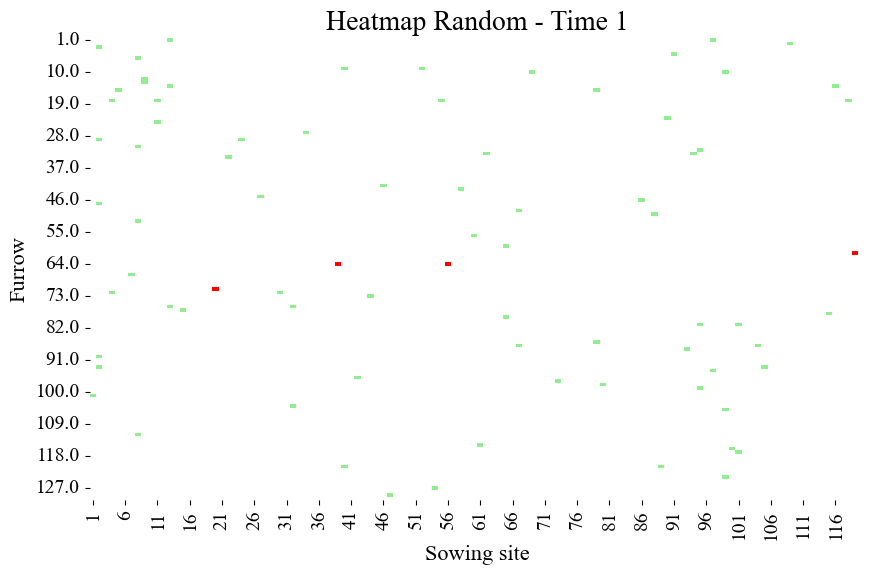

Método: Systematic on grid
Media: 0.038, Std: 0.192, Var: 0.037, CV: 97.44%, Prob. planta enferma: 0.953


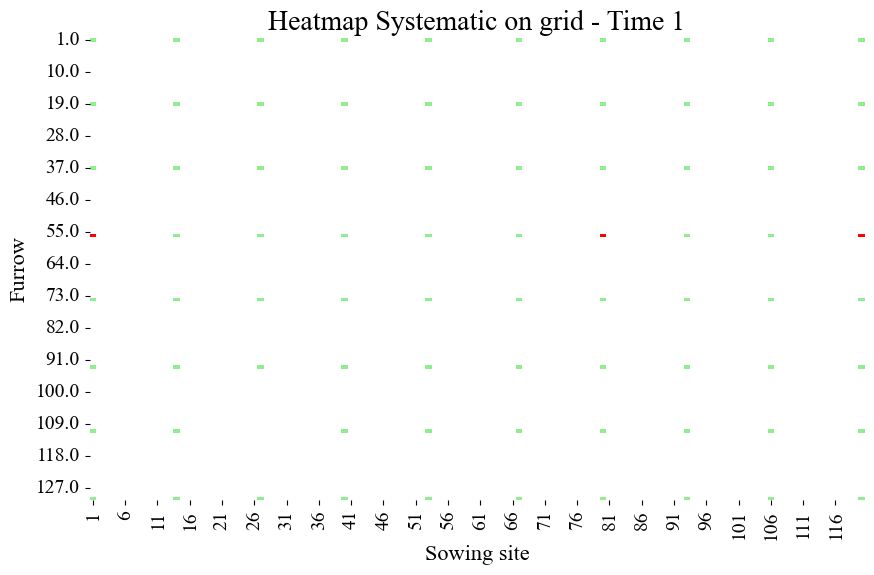

Método: Stratified
Media: 0.128, Std: 0.336, Var: 0.113, CV: 88.31%, Prob. planta enferma: 1.000


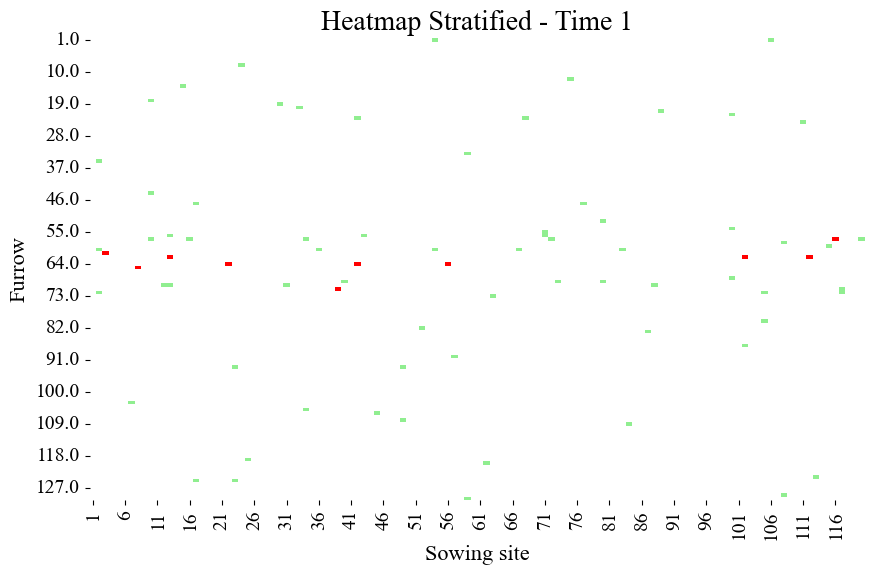

Método: Cluster
Media: 0.063, Std: 0.245, Var: 0.060, CV: 94.87%, Prob. planta enferma: 0.994


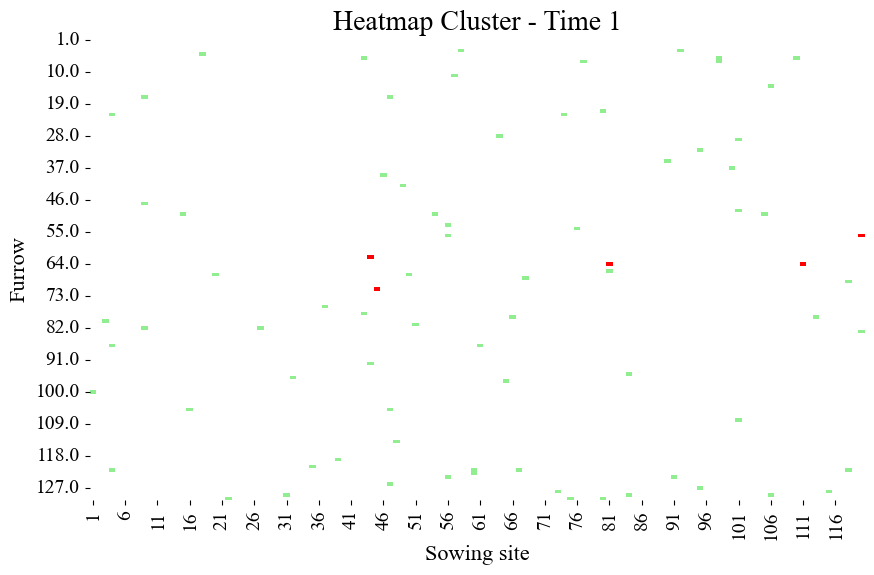


--- Tiempo: 2 | Tamaño muestra ajustado: 118 ---
Método: Random
Media: 0.102, Std: 0.304, Var: 0.092, CV: 90.60%, Prob. planta enferma: 1.000


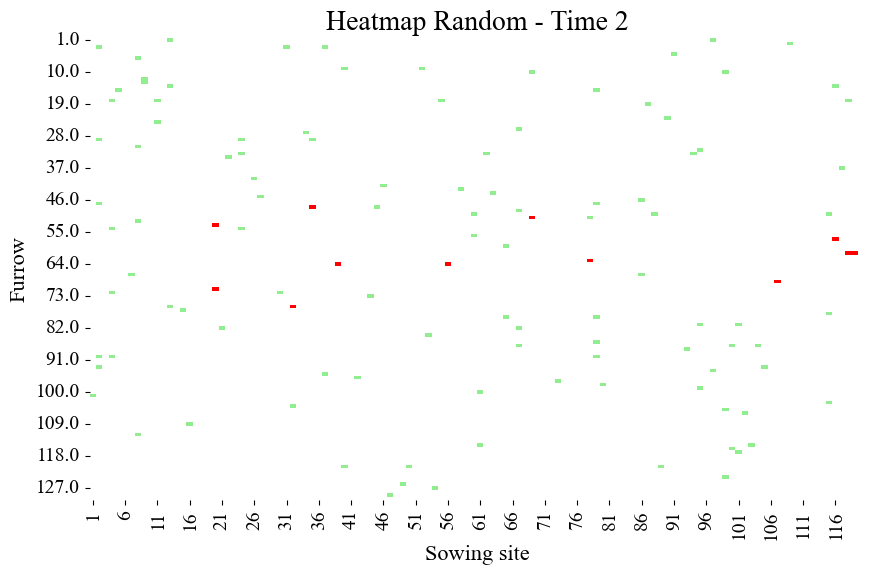

Método: Systematic on grid
Media: 0.042, Std: 0.202, Var: 0.041, CV: 96.58%, Prob. planta enferma: 0.994


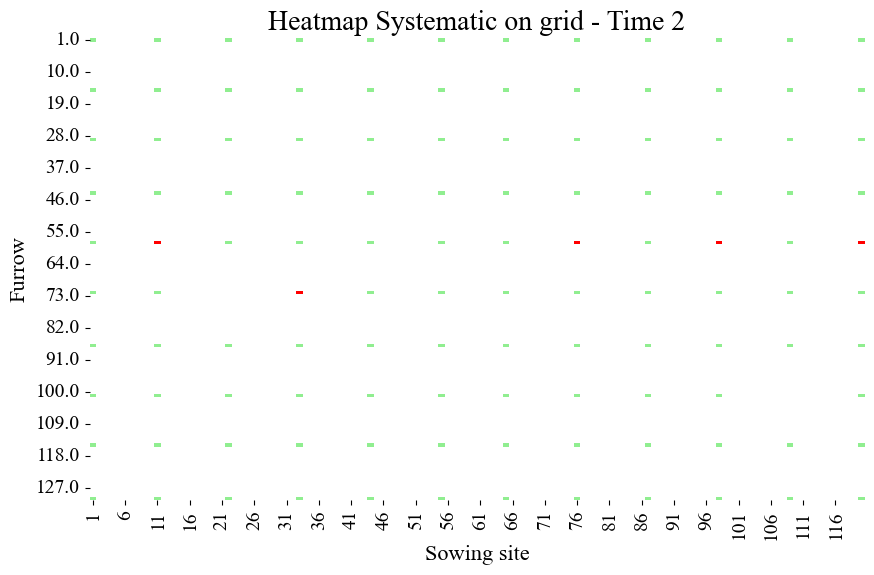

Método: Stratified
Media: 0.137, Std: 0.345, Var: 0.119, CV: 87.07%, Prob. planta enferma: 1.000


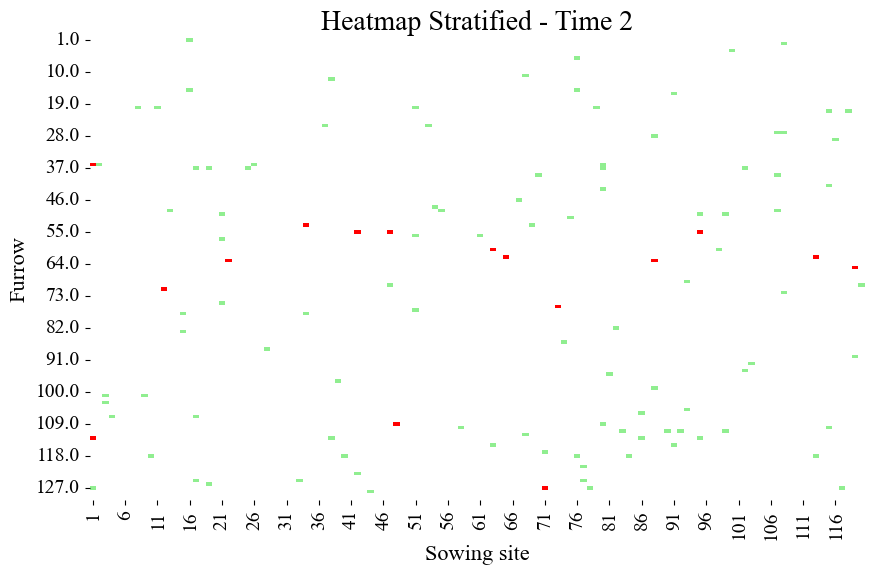

Método: Cluster
Media: 0.102, Std: 0.304, Var: 0.092, CV: 90.60%, Prob. planta enferma: 1.000


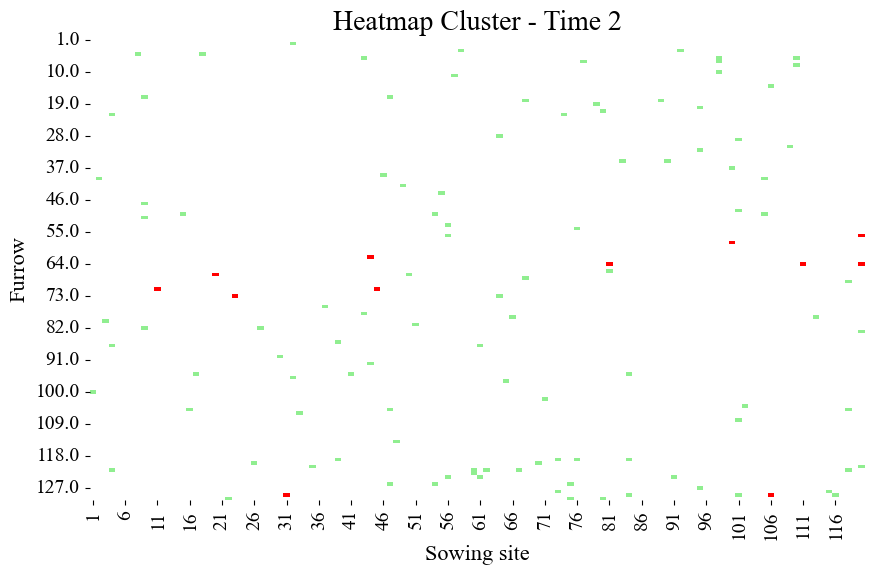


--- Tiempo: 3 | Tamaño muestra ajustado: 173 ---
Método: Random
Media: 0.133, Std: 0.341, Var: 0.116, CV: 87.21%, Prob. planta enferma: 1.000


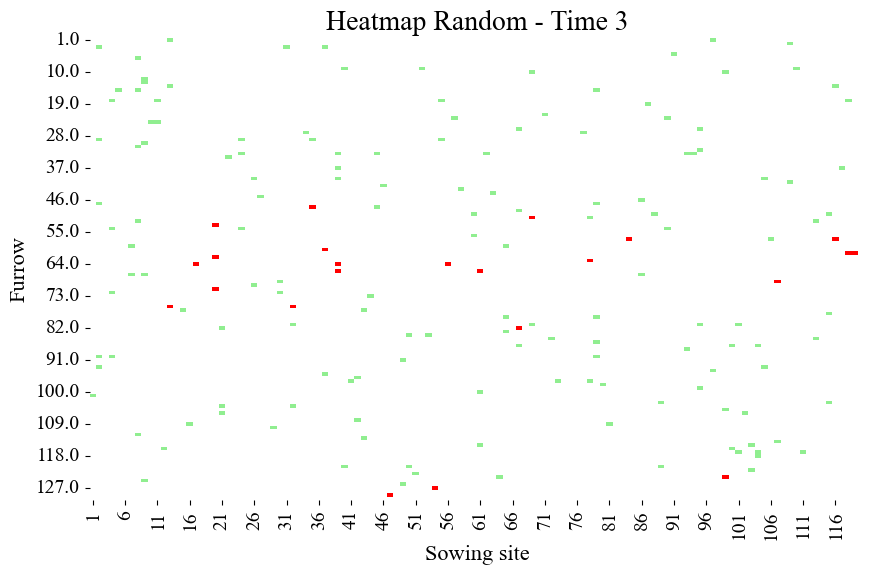

Método: Systematic on grid
Media: 0.150, Std: 0.358, Var: 0.128, CV: 85.47%, Prob. planta enferma: 1.000


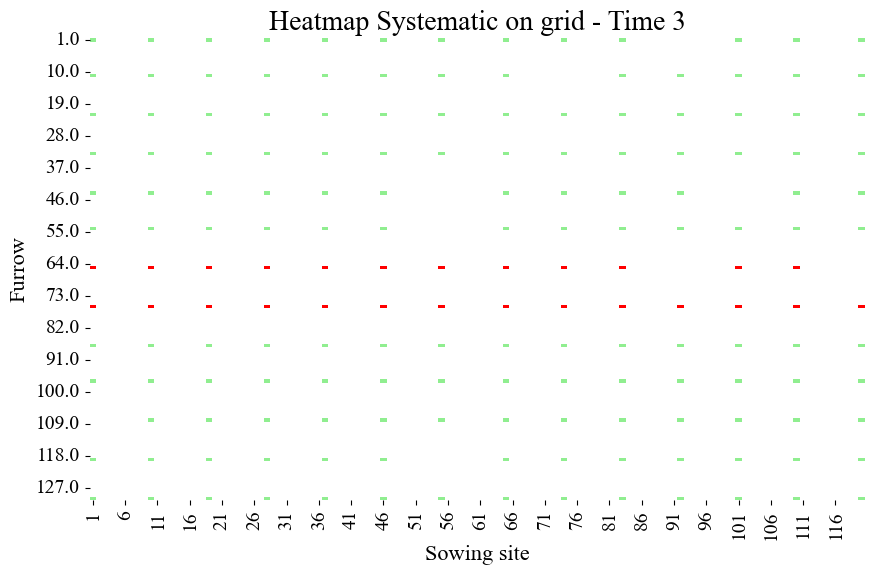

Método: Stratified
Media: 0.145, Std: 0.353, Var: 0.125, CV: 85.96%, Prob. planta enferma: 1.000


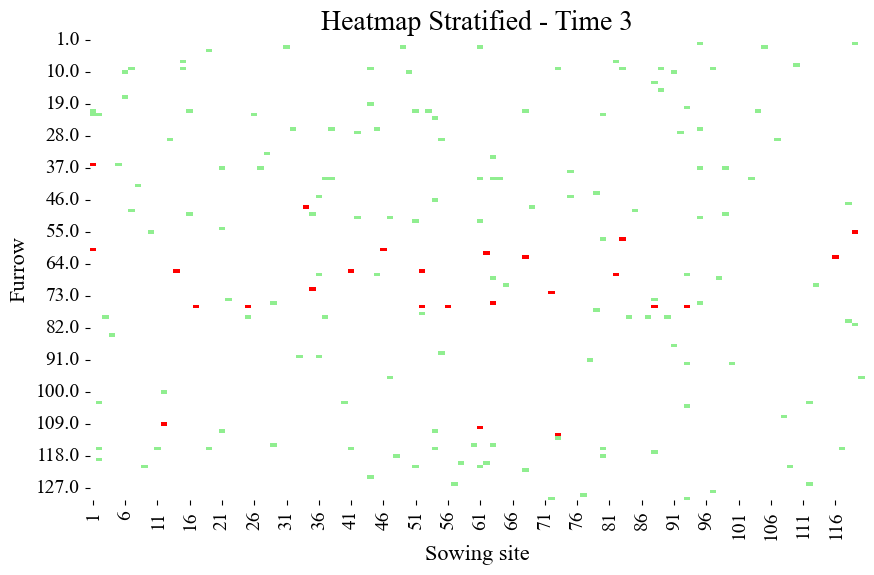

Método: Cluster
Media: 0.156, Std: 0.364, Var: 0.132, CV: 84.88%, Prob. planta enferma: 1.000


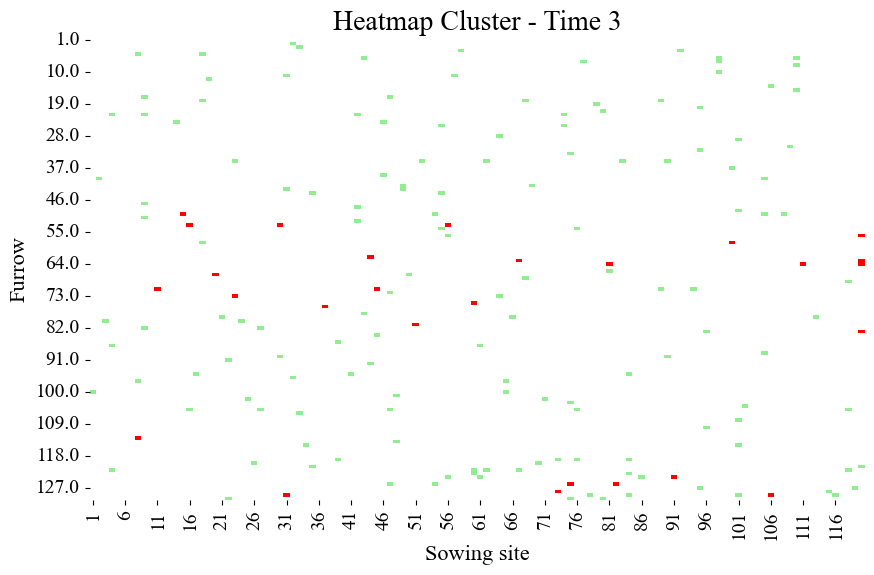


--- Tiempo: 4 | Tamaño muestra ajustado: 249 ---
Método: Random
Media: 0.181, Std: 0.386, Var: 0.149, CV: 82.26%, Prob. planta enferma: 1.000


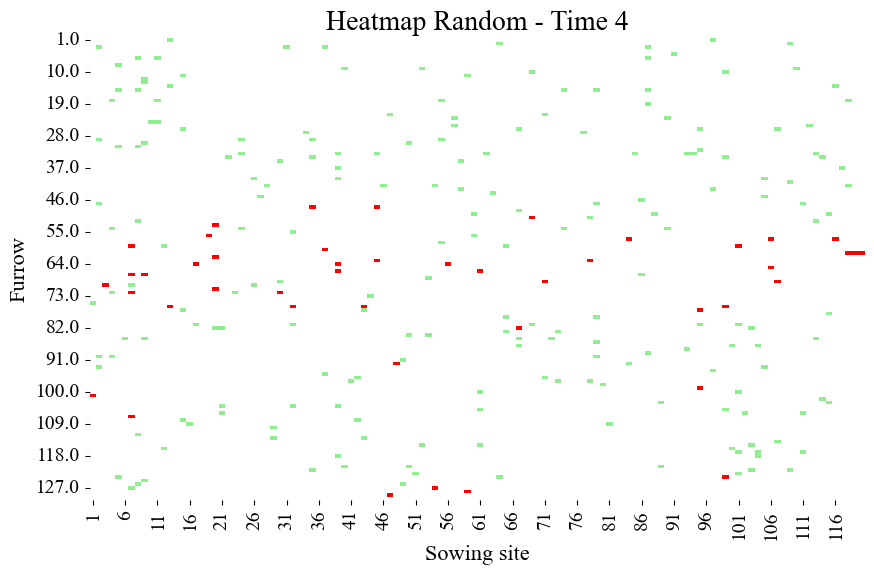

Método: Systematic on grid
Media: 0.205, Std: 0.404, Var: 0.164, CV: 79.84%, Prob. planta enferma: 1.000


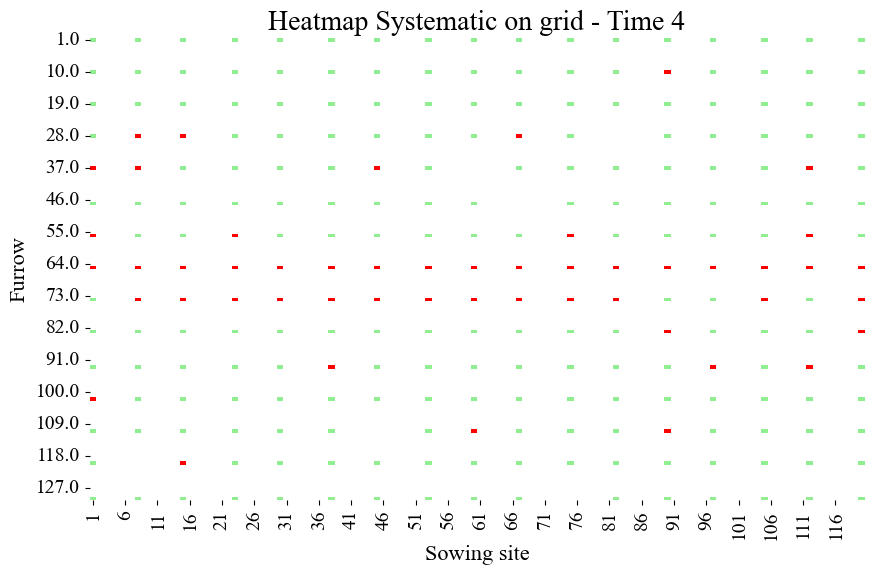

Método: Stratified
Media: 0.230, Std: 0.422, Var: 0.178, CV: 77.33%, Prob. planta enferma: 1.000


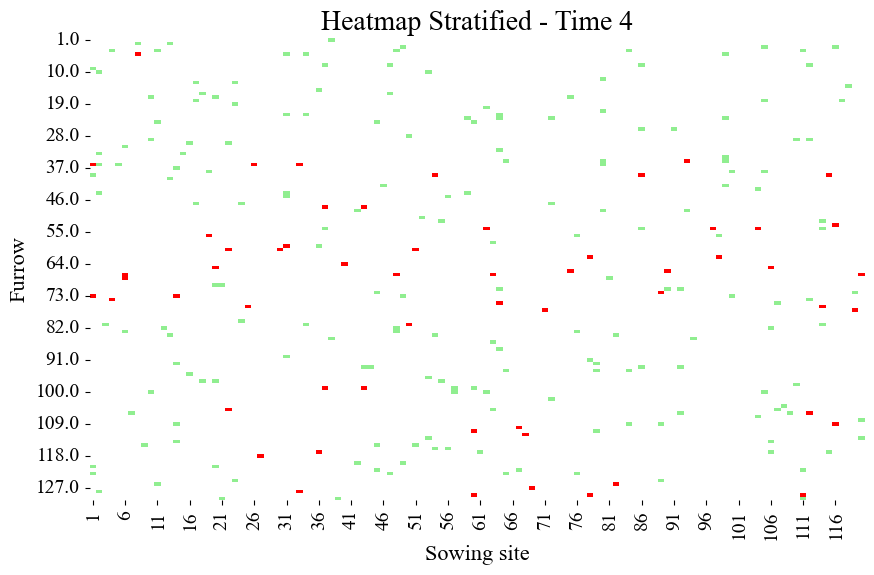

Método: Cluster
Media: 0.205, Std: 0.404, Var: 0.164, CV: 79.84%, Prob. planta enferma: 1.000


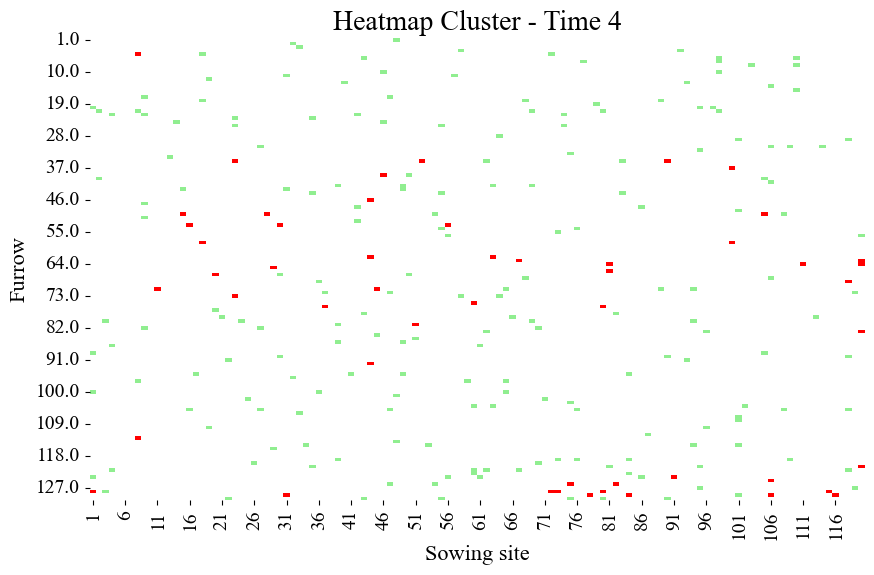


--- Tiempo: 5 | Tamaño muestra ajustado: 352 ---
Método: Random
Media: 0.335, Std: 0.473, Var: 0.223, CV: 66.67%, Prob. planta enferma: 1.000


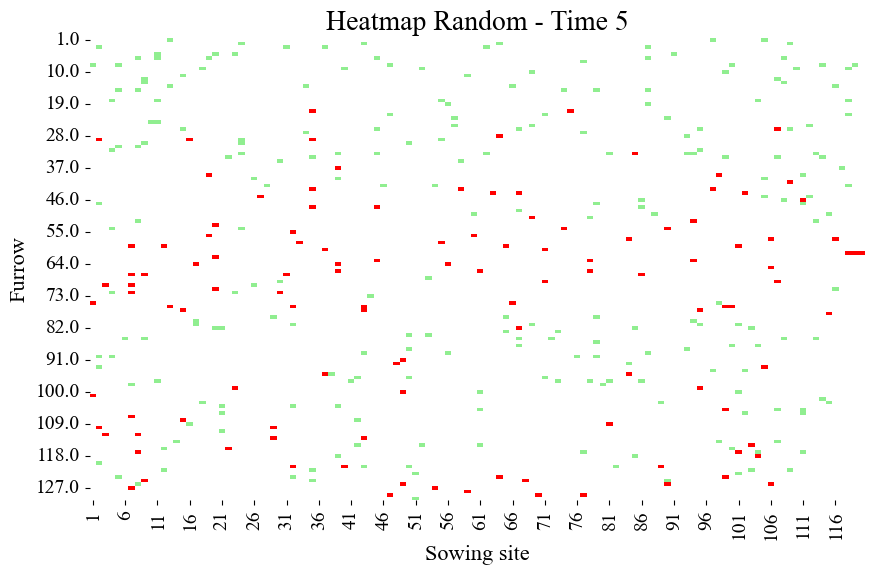

Método: Systematic on grid
Media: 0.335, Std: 0.473, Var: 0.223, CV: 66.67%, Prob. planta enferma: 1.000


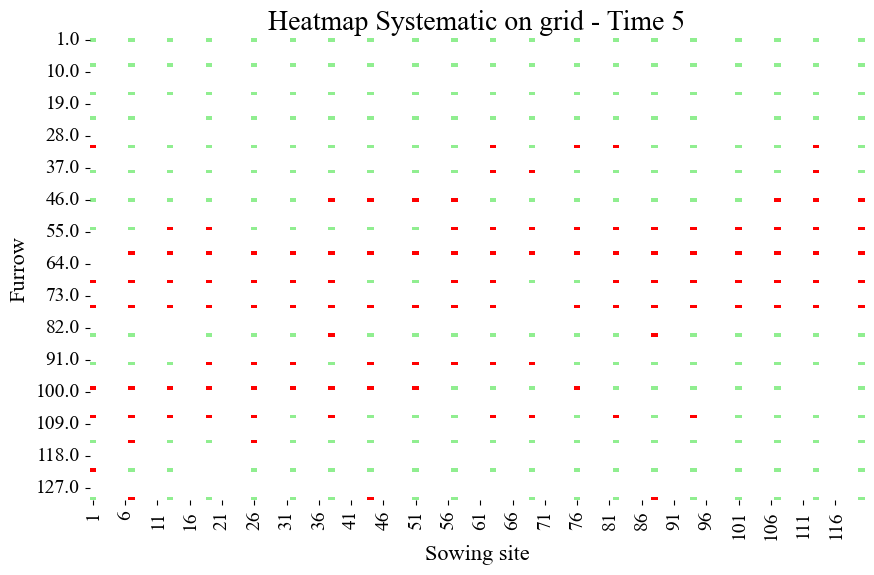

Método: Stratified
Media: 0.355, Std: 0.479, Var: 0.230, CV: 64.67%, Prob. planta enferma: 1.000


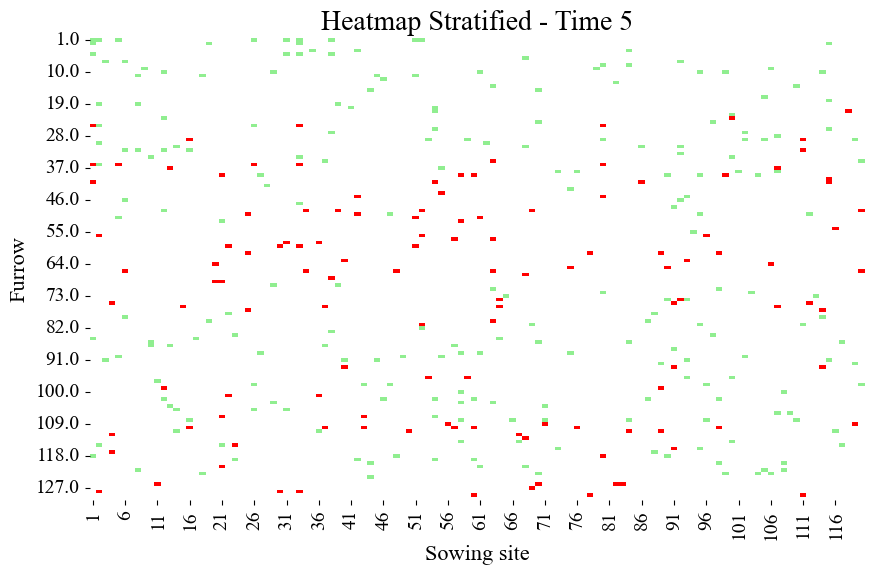

Método: Cluster
Media: 0.349, Std: 0.477, Var: 0.228, CV: 65.24%, Prob. planta enferma: 1.000


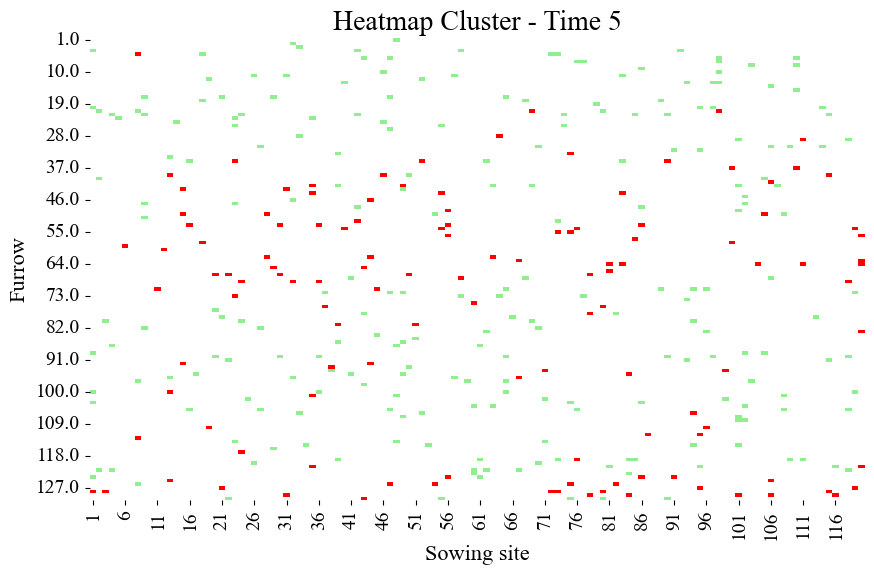


--- Tiempo: 6 | Tamaño muestra ajustado: 371 ---
Método: Random
Media: 0.542, Std: 0.499, Var: 0.249, CV: 45.95%, Prob. planta enferma: 1.000


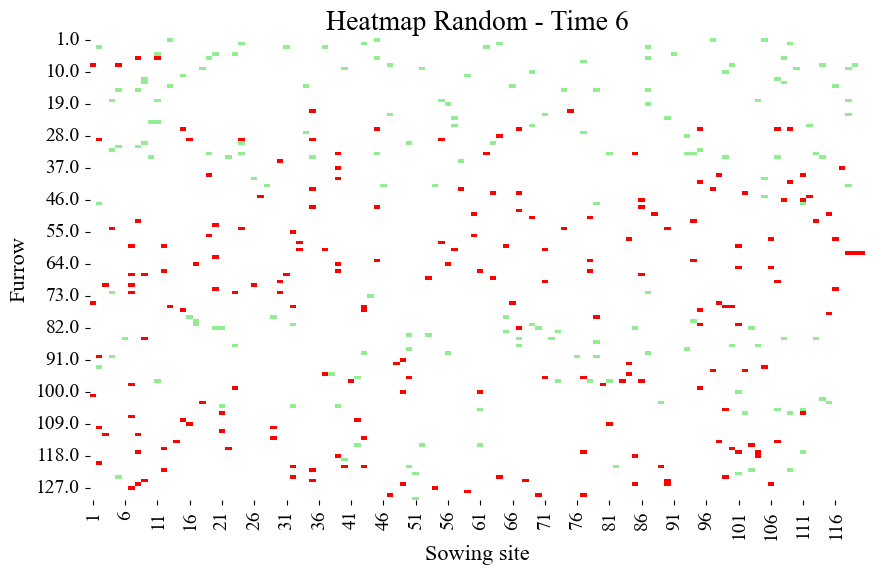

Método: Systematic on grid
Media: 0.472, Std: 0.500, Var: 0.250, CV: 52.97%, Prob. planta enferma: 1.000


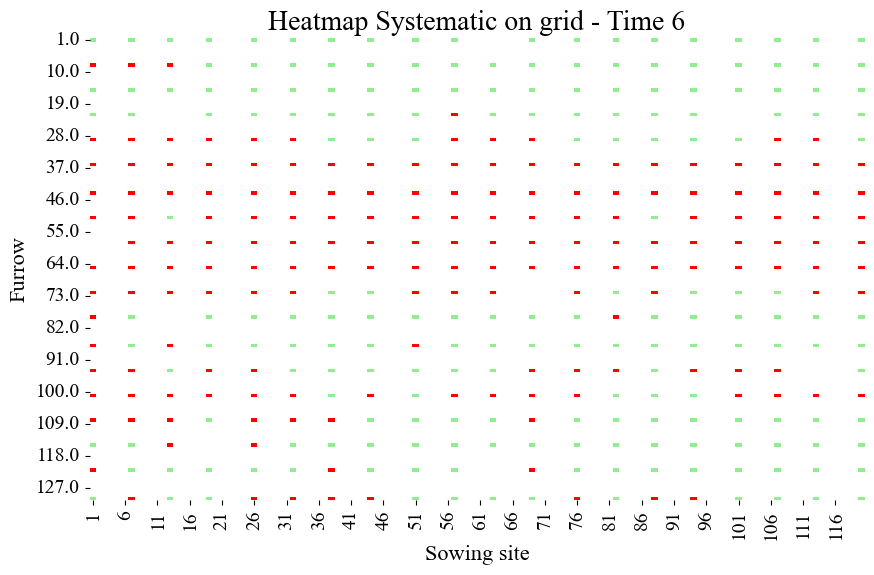

Método: Stratified
Media: 0.533, Std: 0.500, Var: 0.250, CV: 46.87%, Prob. planta enferma: 1.000


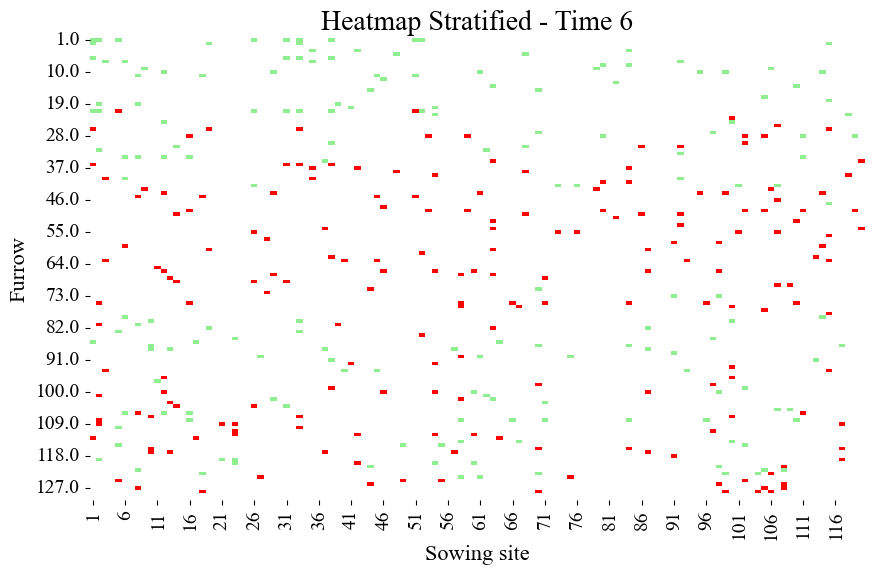

Método: Cluster
Media: 0.526, Std: 0.500, Var: 0.250, CV: 47.57%, Prob. planta enferma: 1.000


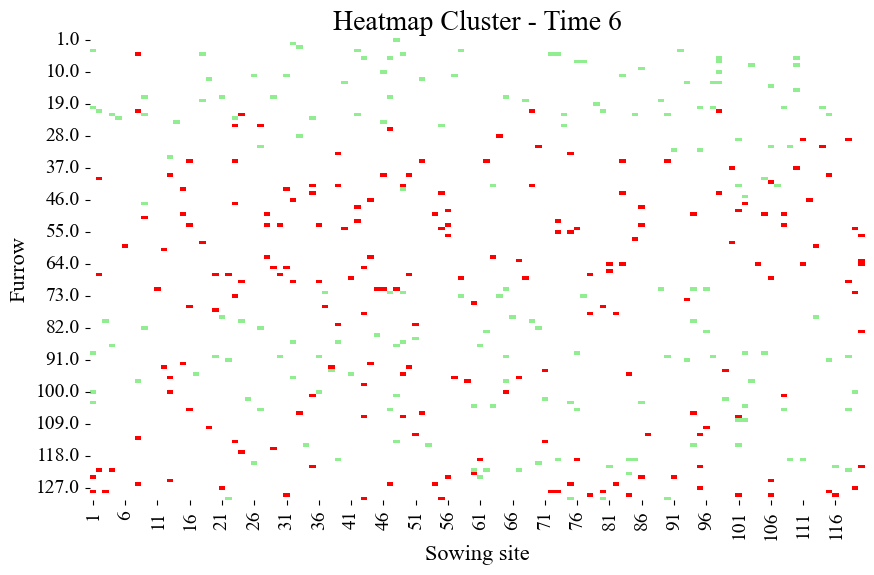


--- Tiempo: 7 | Tamaño muestra ajustado: 335 ---
Método: Random
Media: 0.654, Std: 0.476, Var: 0.227, CV: 34.73%, Prob. planta enferma: 1.000


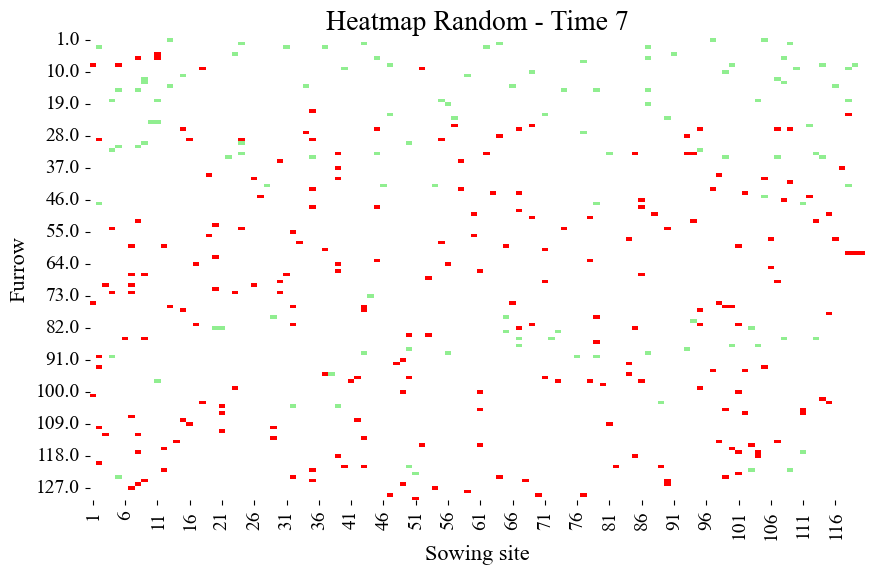

Método: Systematic on grid
Media: 0.687, Std: 0.465, Var: 0.216, CV: 31.44%, Prob. planta enferma: 1.000


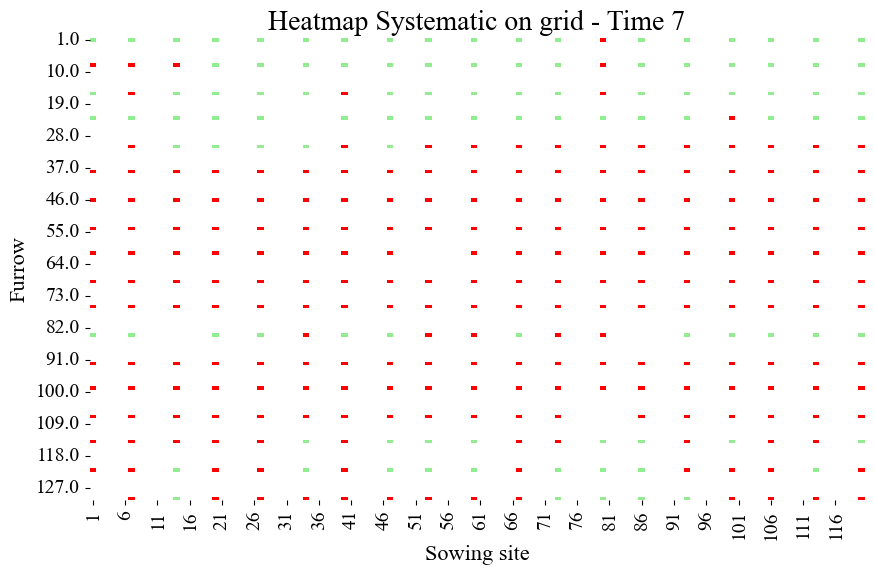

Método: Stratified
Media: 0.568, Std: 0.496, Var: 0.246, CV: 43.37%, Prob. planta enferma: 1.000


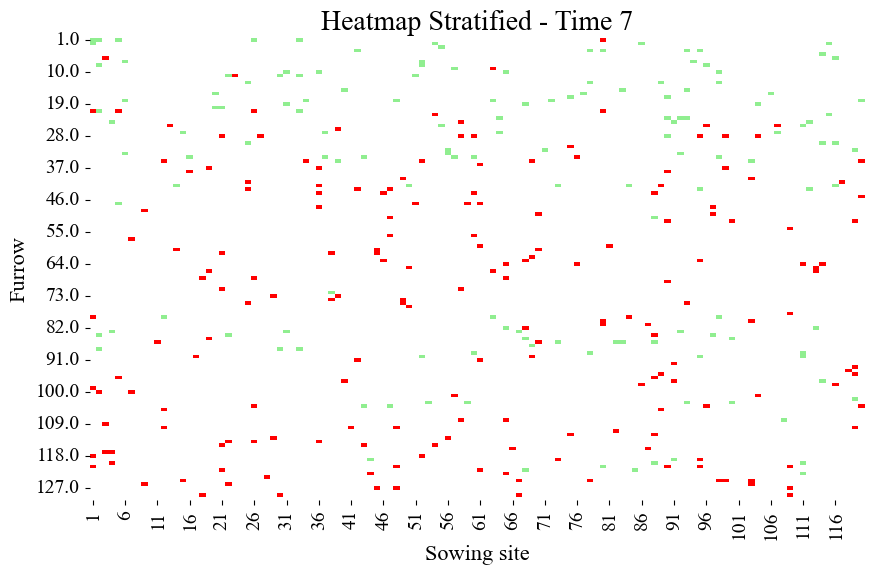

Método: Cluster
Media: 0.684, Std: 0.466, Var: 0.217, CV: 31.74%, Prob. planta enferma: 1.000


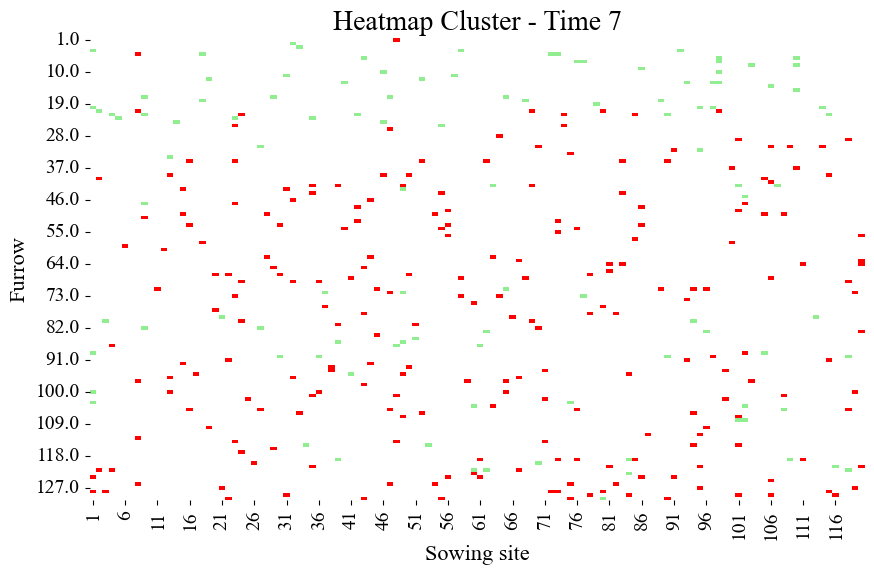


--- Tiempo: 8 | Tamaño muestra ajustado: 281 ---
Método: Random
Media: 0.747, Std: 0.435, Var: 0.190, CV: 25.36%, Prob. planta enferma: 1.000


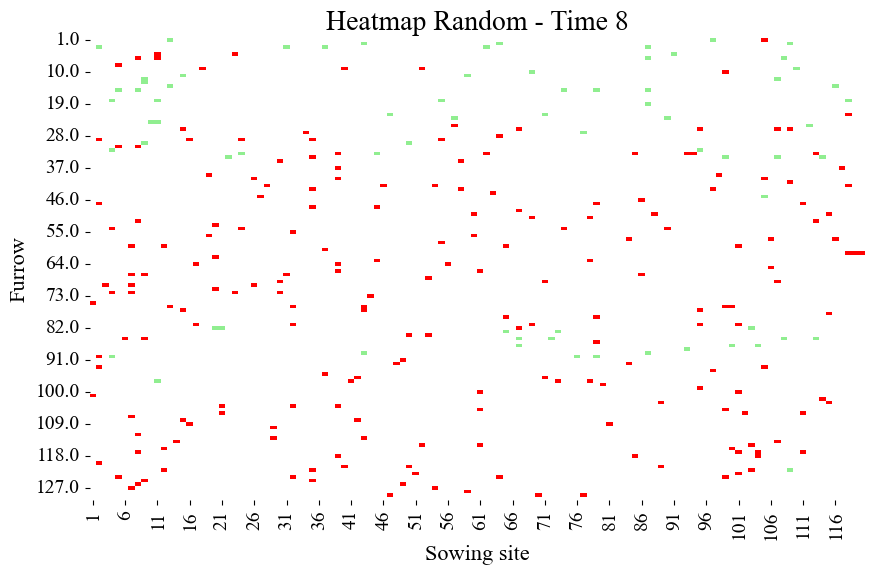

Método: Systematic on grid
Media: 0.769, Std: 0.422, Var: 0.178, CV: 23.21%, Prob. planta enferma: 1.000


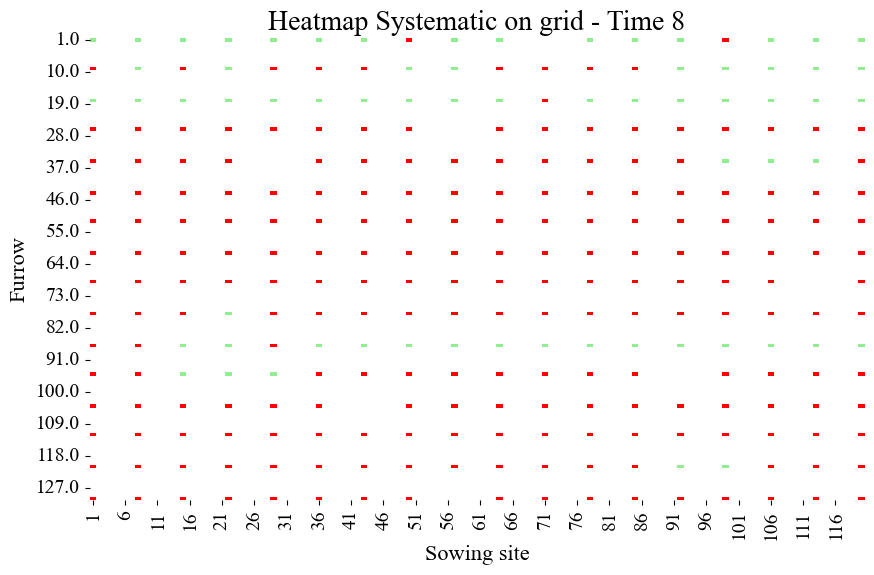

Método: Stratified
Media: 0.670, Std: 0.471, Var: 0.222, CV: 33.09%, Prob. planta enferma: 1.000


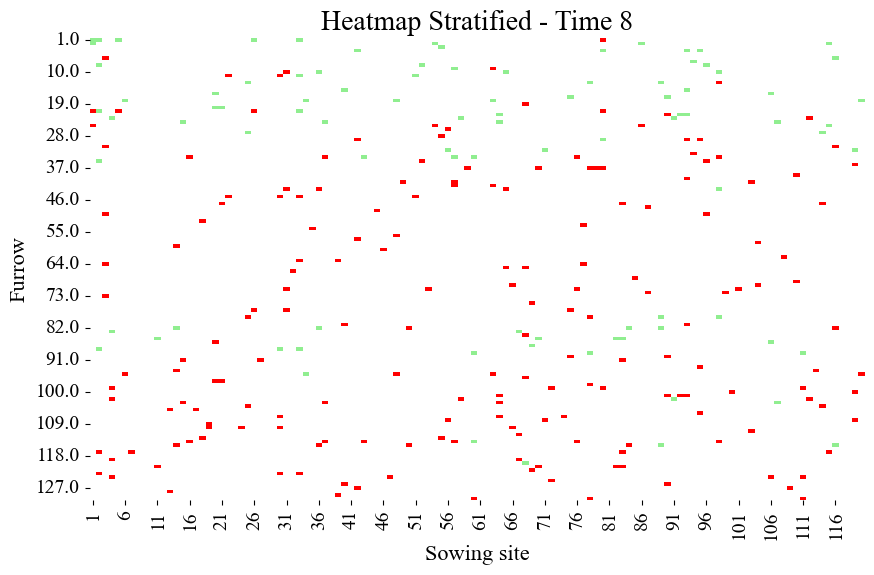

Método: Cluster
Media: 0.772, Std: 0.420, Var: 0.177, CV: 22.86%, Prob. planta enferma: 1.000


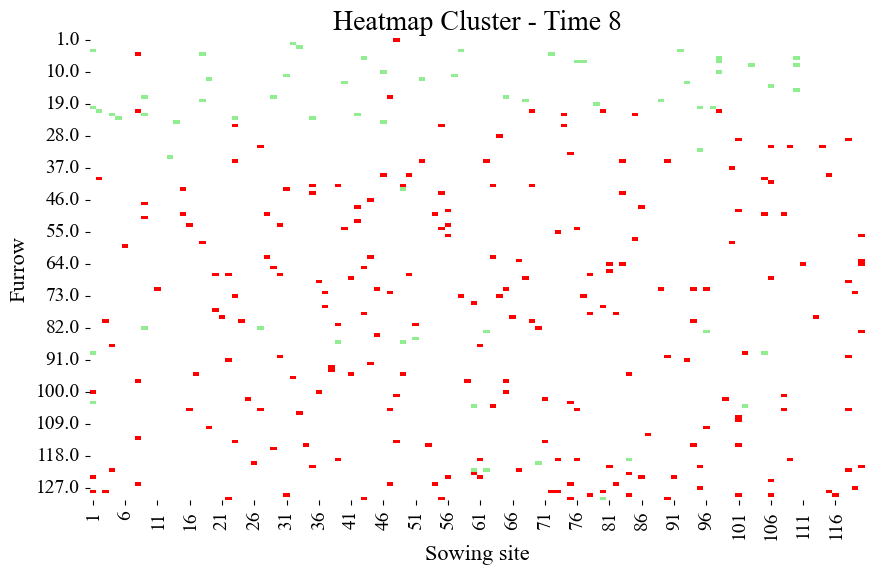


--- Tiempo: 9 | Tamaño muestra ajustado: 208 ---
Método: Random
Media: 0.846, Std: 0.362, Var: 0.131, CV: 15.46%, Prob. planta enferma: 1.000


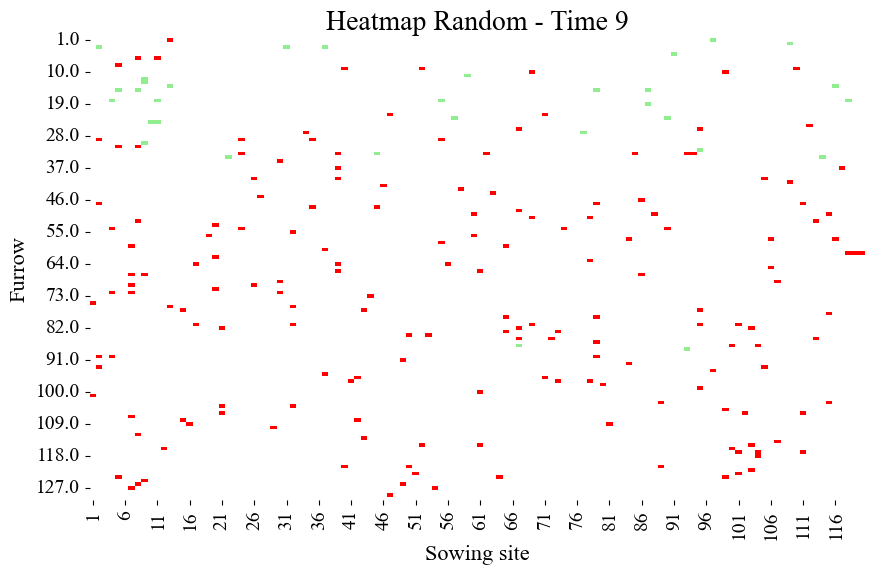

Método: Systematic on grid
Media: 0.832, Std: 0.375, Var: 0.141, CV: 16.91%, Prob. planta enferma: 1.000


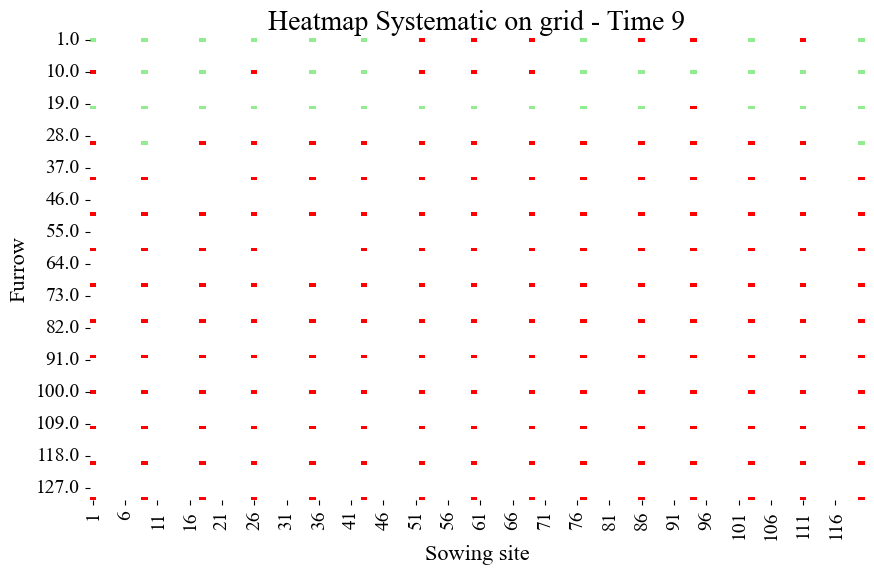

Método: Stratified
Media: 0.702, Std: 0.459, Var: 0.210, CV: 29.95%, Prob. planta enferma: 1.000


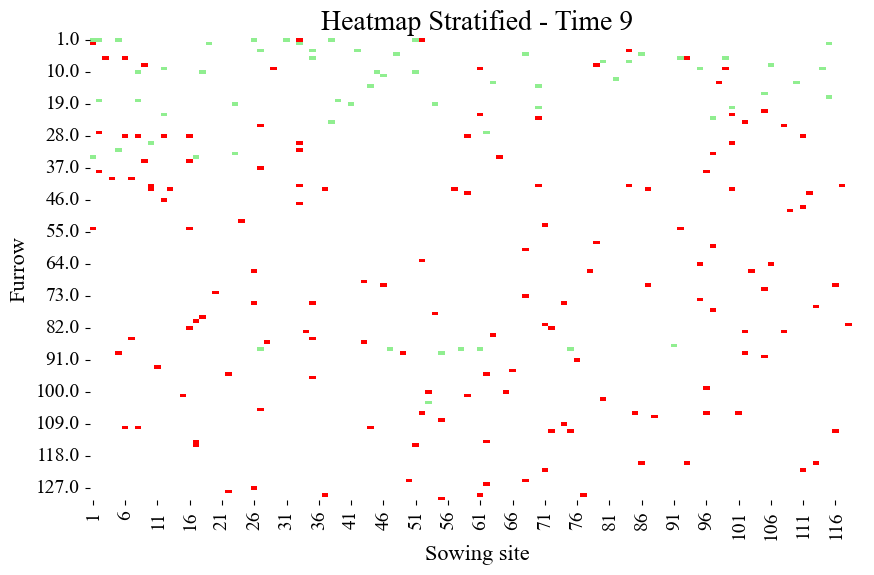

Método: Cluster
Media: 0.856, Std: 0.352, Var: 0.124, CV: 14.49%, Prob. planta enferma: 1.000


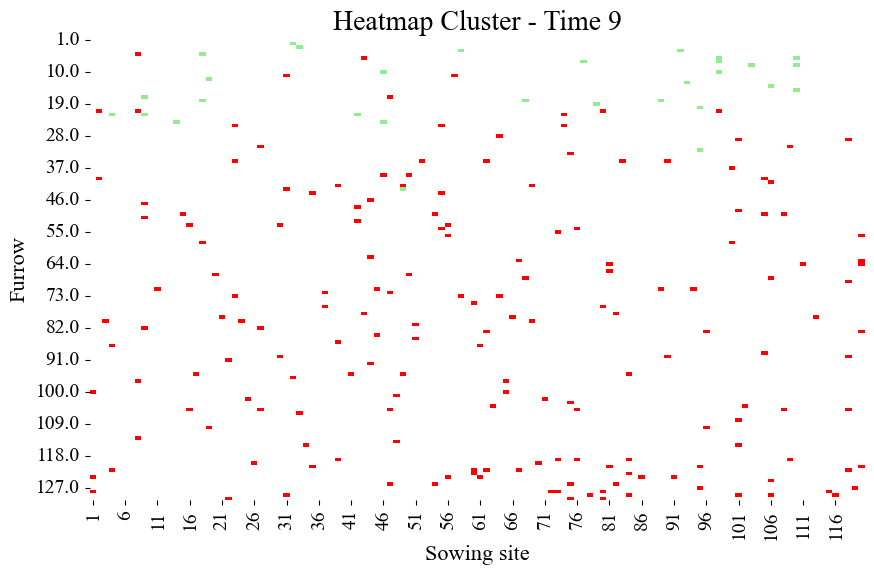


--- Tiempo: 10 | Tamaño muestra ajustado: 132 ---
Método: Random
Media: 0.886, Std: 0.319, Var: 0.101, CV: 11.45%, Prob. planta enferma: 1.000


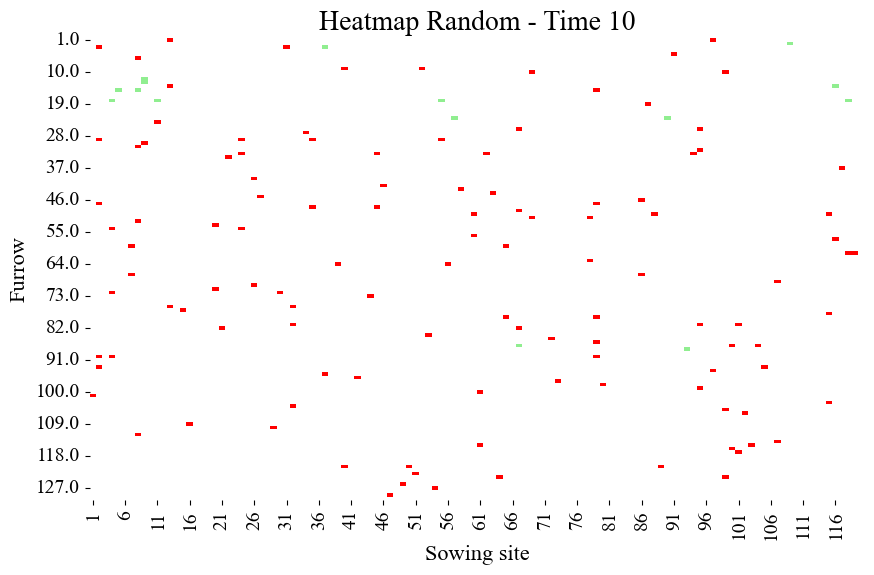

Método: Systematic on grid
Media: 0.939, Std: 0.240, Var: 0.057, CV: 6.11%, Prob. planta enferma: 1.000


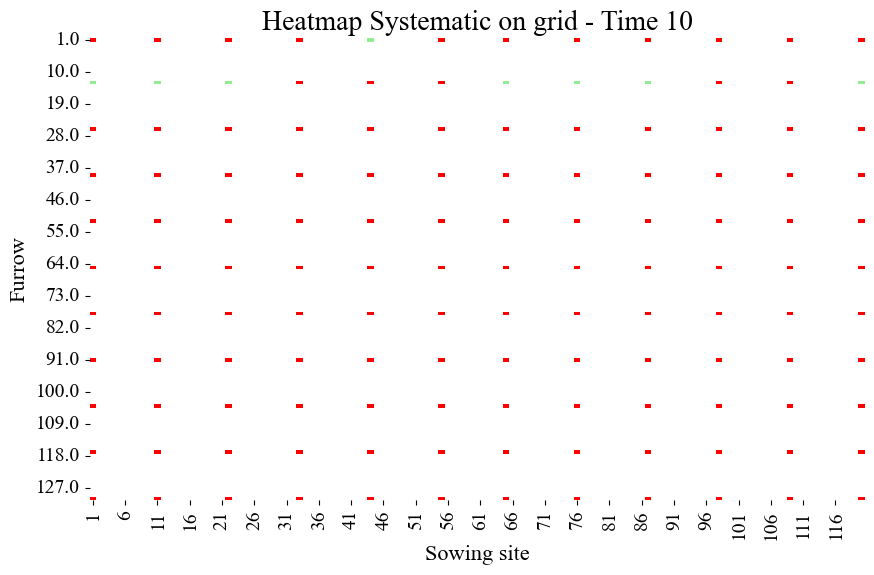

Método: Stratified
Media: 0.864, Std: 0.344, Var: 0.119, CV: 13.74%, Prob. planta enferma: 1.000


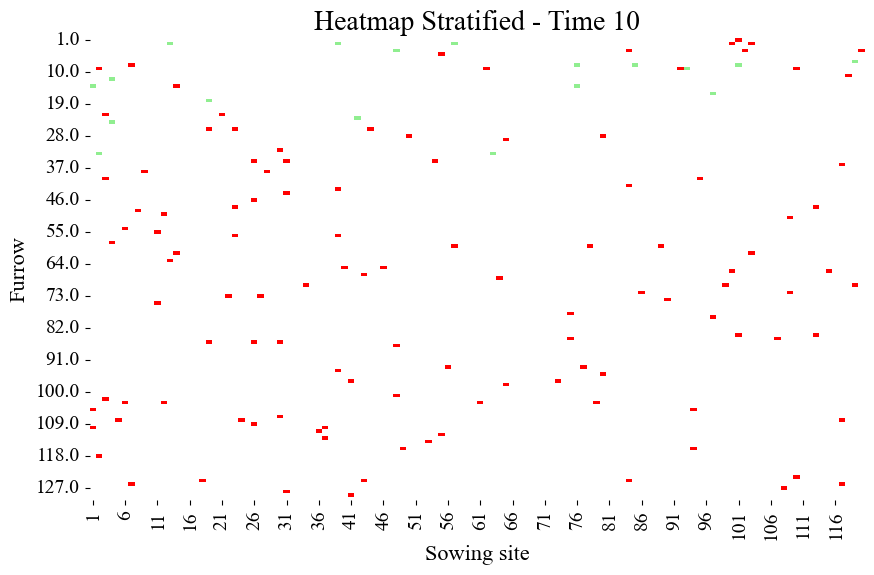

Método: Cluster
Media: 0.909, Std: 0.289, Var: 0.083, CV: 9.16%, Prob. planta enferma: 1.000


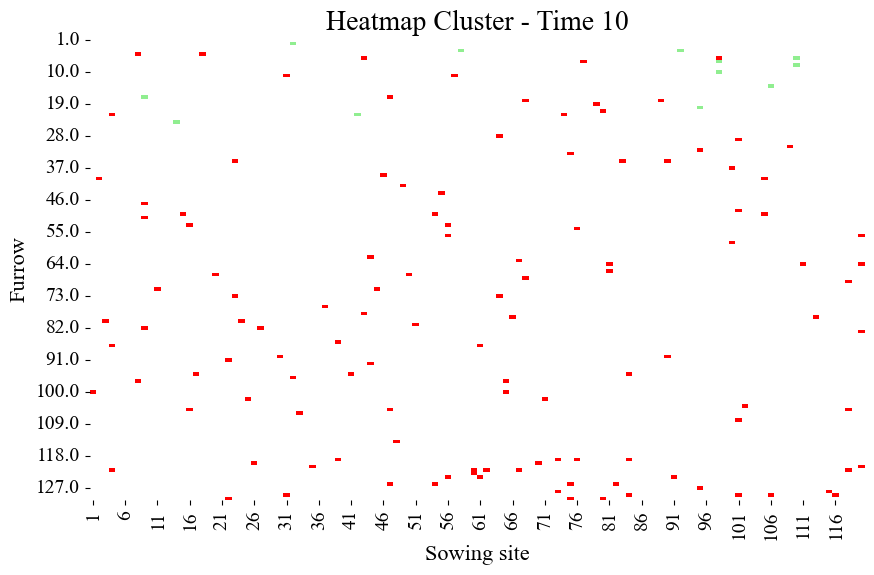


--- Tiempo: 11 | Tamaño muestra ajustado: 78 ---
Método: Random
Media: 0.910, Std: 0.288, Var: 0.083, CV: 9.09%, Prob. planta enferma: 1.000


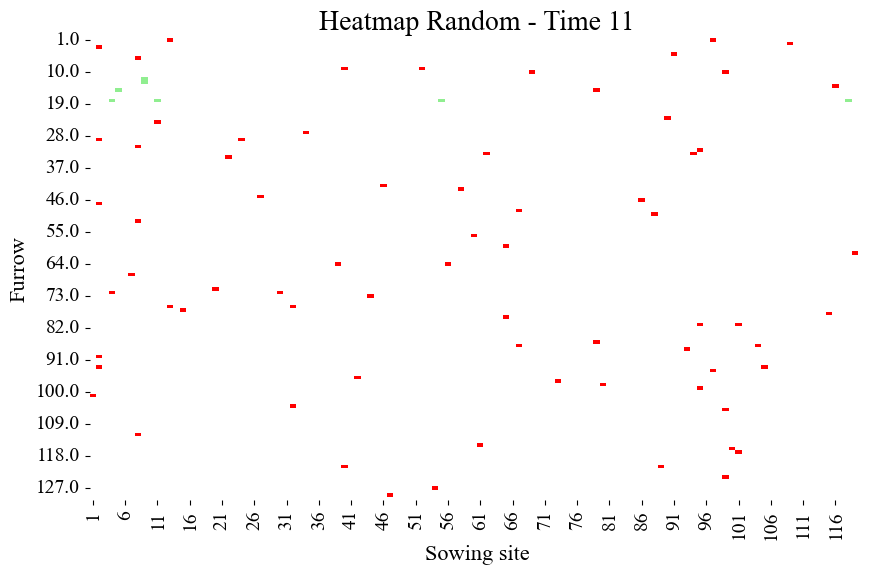

Método: Systematic on grid
Media: 0.923, Std: 0.268, Var: 0.072, CV: 7.79%, Prob. planta enferma: 1.000


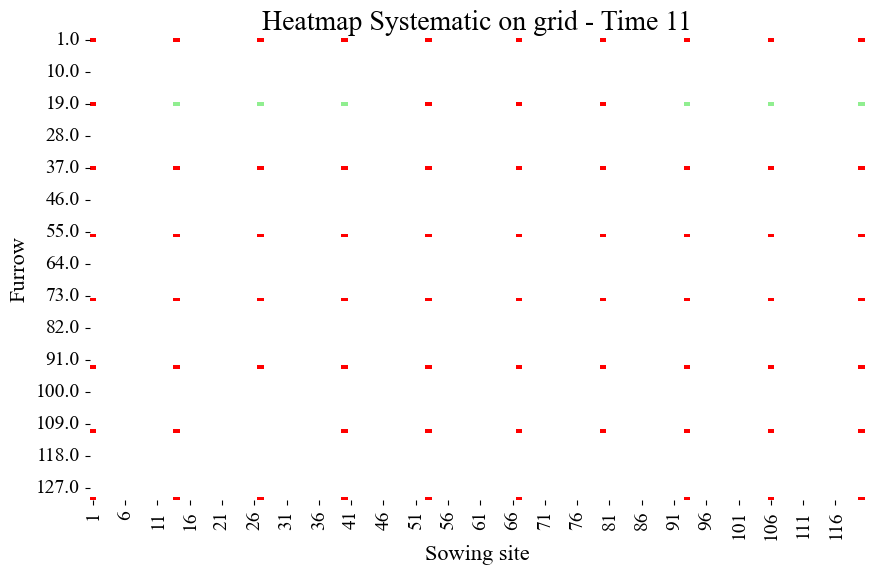

Método: Stratified
Media: 0.897, Std: 0.305, Var: 0.093, CV: 10.39%, Prob. planta enferma: 1.000


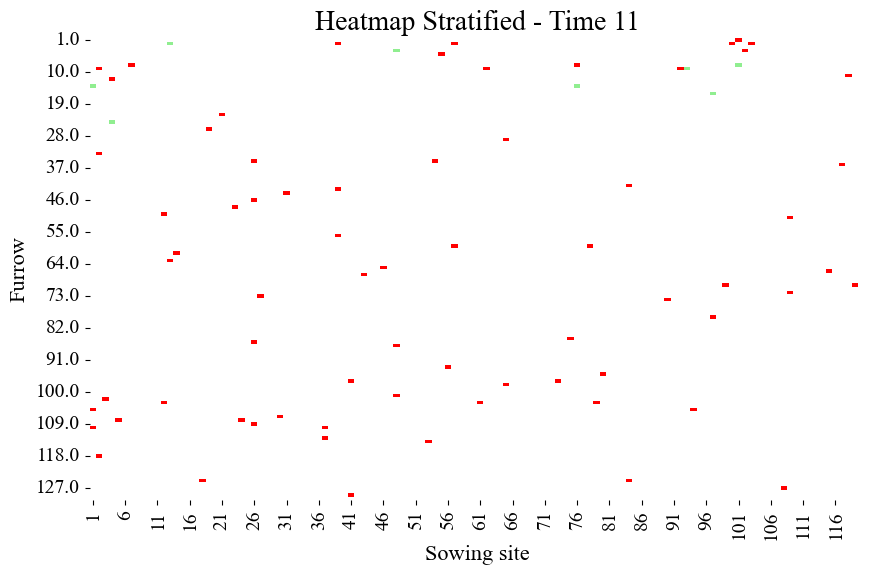

Método: Cluster
Media: 0.936, Std: 0.247, Var: 0.061, CV: 6.49%, Prob. planta enferma: 1.000


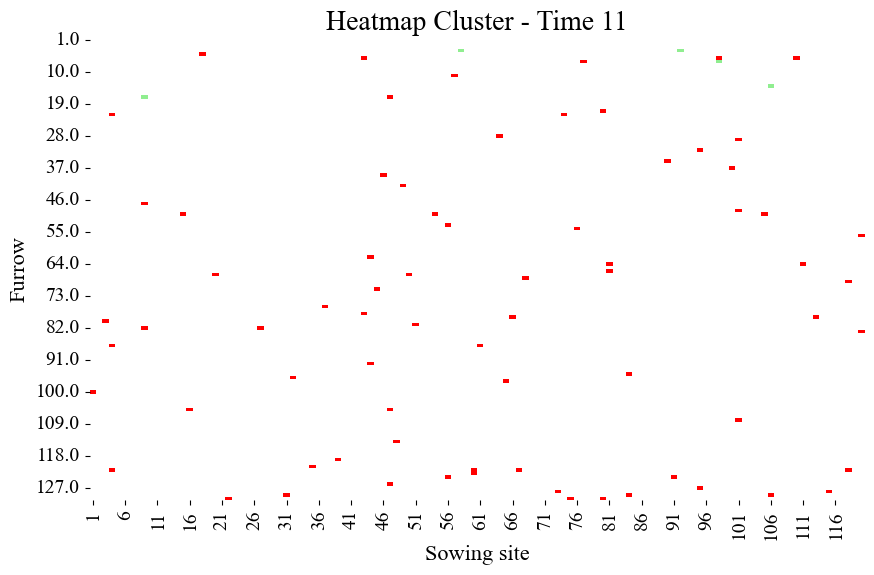


--- Tiempo: 12 | Tamaño muestra ajustado: 39 ---
Método: Random
Media: 0.949, Std: 0.223, Var: 0.050, CV: 5.26%, Prob. planta enferma: 1.000


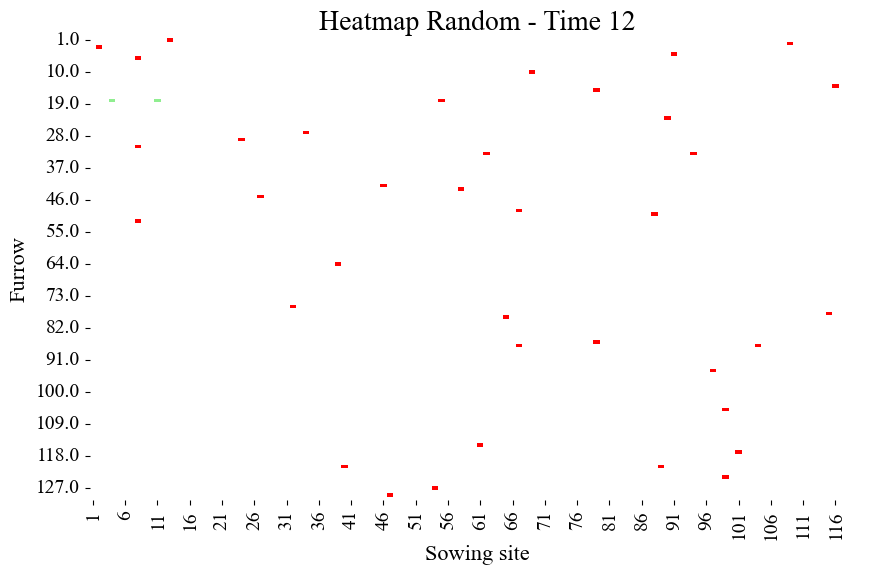

Método: Systematic on grid
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


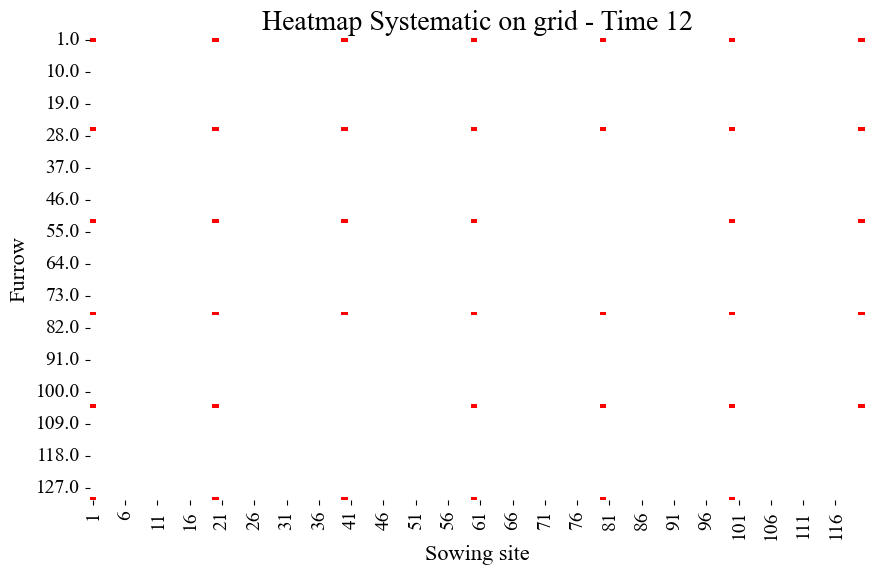

Método: Stratified
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


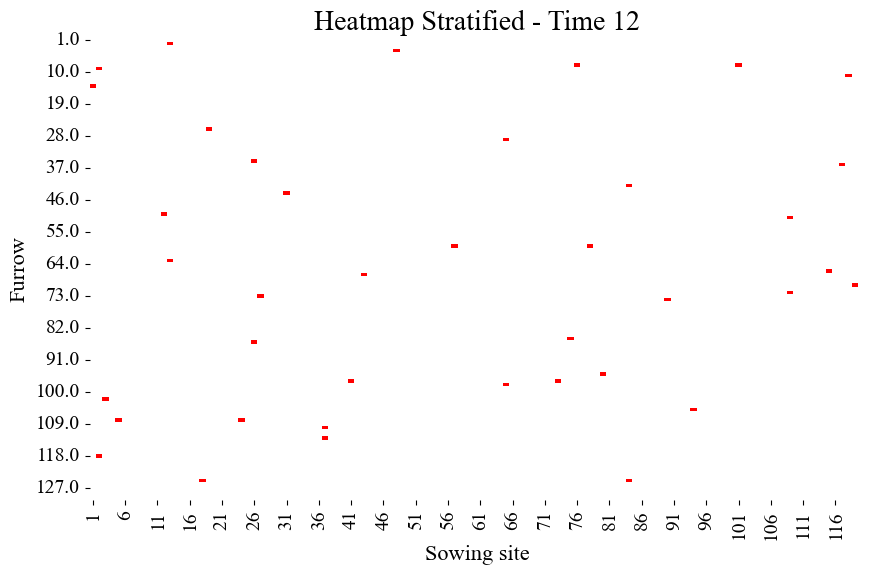

Método: Cluster
Media: 0.974, Std: 0.160, Var: 0.026, CV: 2.63%, Prob. planta enferma: 1.000


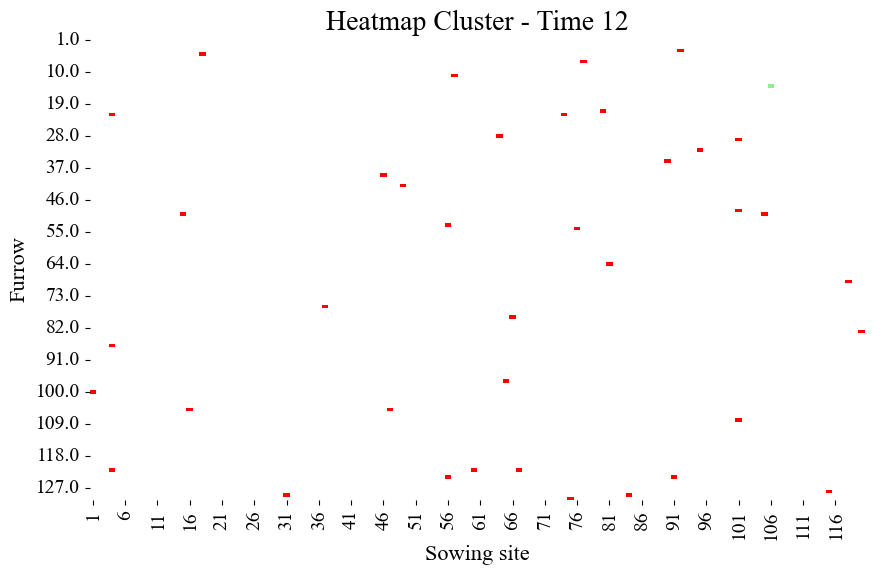

In [22]:
resultados = []

for tiempo in n_opt['Tiempo'].unique():
    df_tiempo = data_35[data_35['Tiempo'] == tiempo].copy()
    n_val = n_opt.loc[n_opt['Tiempo'] == tiempo, 'n'].values
    if len(n_val) == 0:
        print(f"No hay valor de n para tiempo {tiempo}, se omite.")
        continue
    n_muestra = int(np.floor(n_val[0]))
    n_muestra = max(1, min(n_muestra, len(df_tiempo)))

    print(f"\n--- Time: {tiempo} | Sample size: {n_muestra} ---")

    for metodo, funcion_muestreo in metodos.items():
        try:
            sample = funcion_muestreo(df_tiempo, n_muestra)
        except ValueError as e:
            print(f"Error {metodo} in time {tiempo}: {e}")
            continue

        media, std, var, cv, prob_enferma = calcular_estadisticas(sample)

        print(f"Método: {metodo}")
        print(f"Media: {media:.3f}, Std: {std:.3f}, Var: {var:.3f}, CV: {cv:.2f}%, Prob. planta enferma: {prob_enferma:.3f}")

        plot_heatmap(sample, tiempo, metodo, df_tiempo)

        resultados.append({
            'Tiempo': tiempo,
            'Método': metodo,
            'Media': media,
            'Std': std,
            'Var': var,
            'CV (%)': cv,
            'Probabilidad planta enferma': prob_enferma
        })

df_resultados = pd.DataFrame(resultados)


--- Tiempo: 1 | Tamaño muestra ajustado: 15 ---
Método: Random
Media: 0.000, Std: 0.000, Var: 0.000, CV: nan%, Prob. planta enferma: 0.000


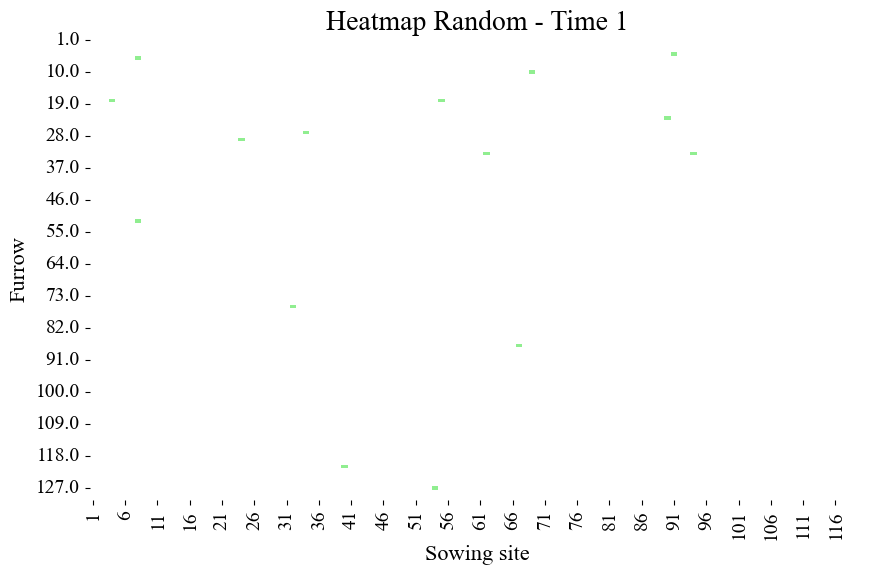

Método: Systematic on grid
Media: 0.333, Std: 0.488, Var: 0.238, CV: 71.43%, Prob. planta enferma: 0.998


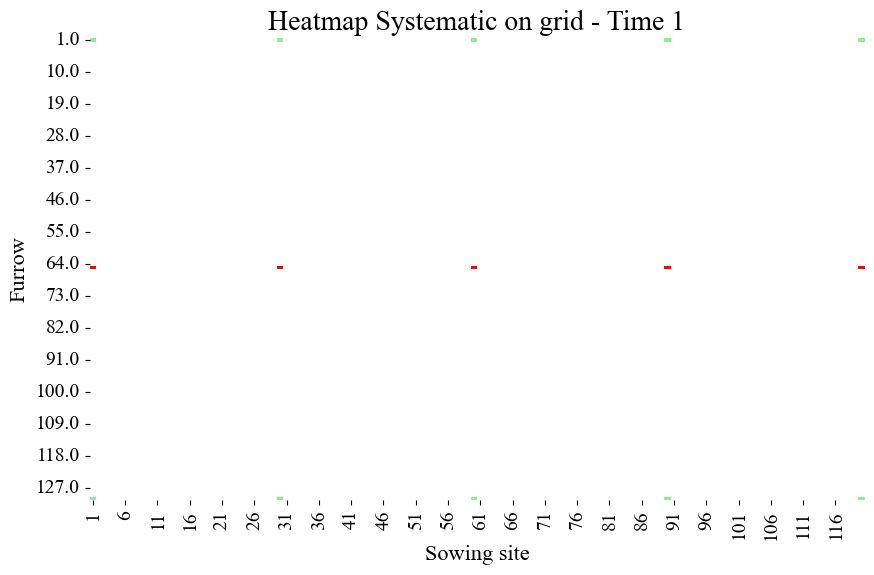

Método: Stratified
Media: 0.214, Std: 0.426, Var: 0.181, CV: 84.62%, Prob. planta enferma: 0.966


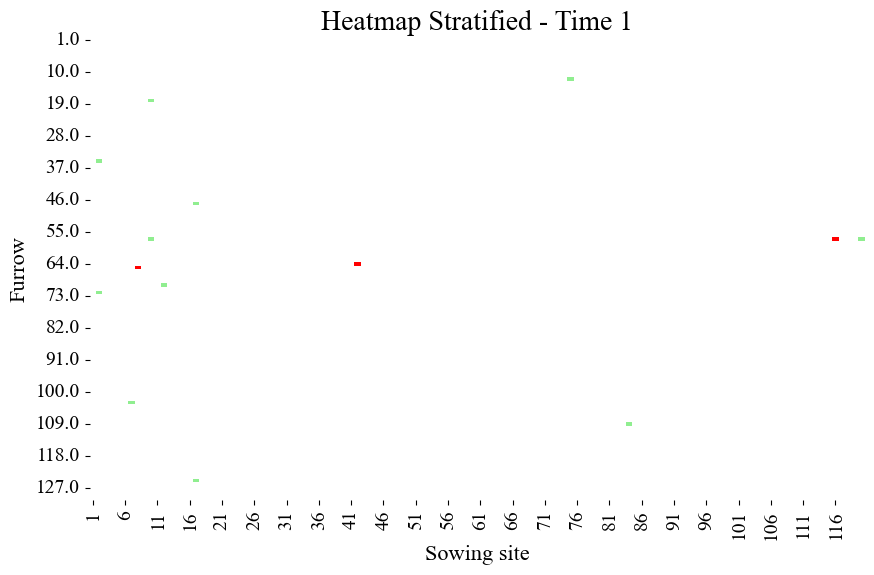

Método: Cluster
Media: 0.000, Std: 0.000, Var: 0.000, CV: nan%, Prob. planta enferma: 0.000


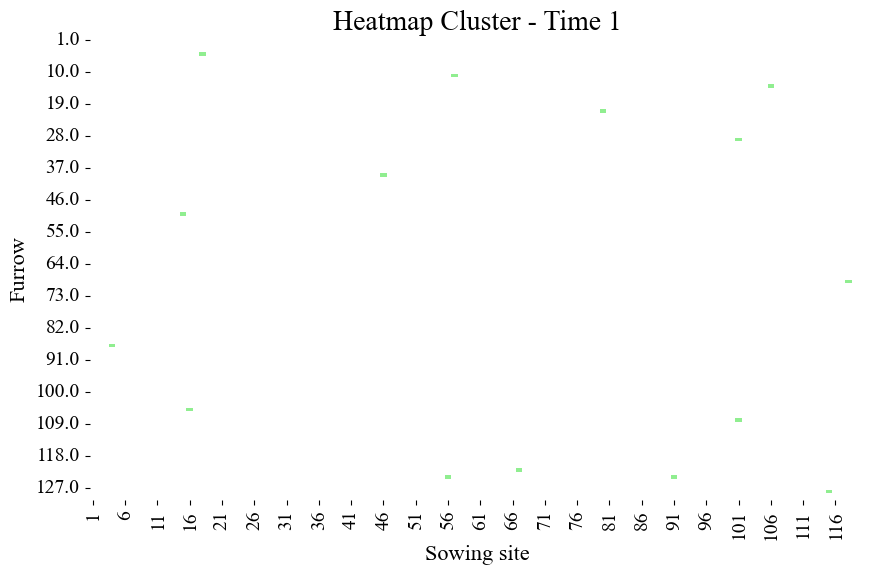


--- Tiempo: 2 | Tamaño muestra ajustado: 25 ---
Método: Random
Media: 0.040, Std: 0.200, Var: 0.040, CV: 100.00%, Prob. planta enferma: 0.640


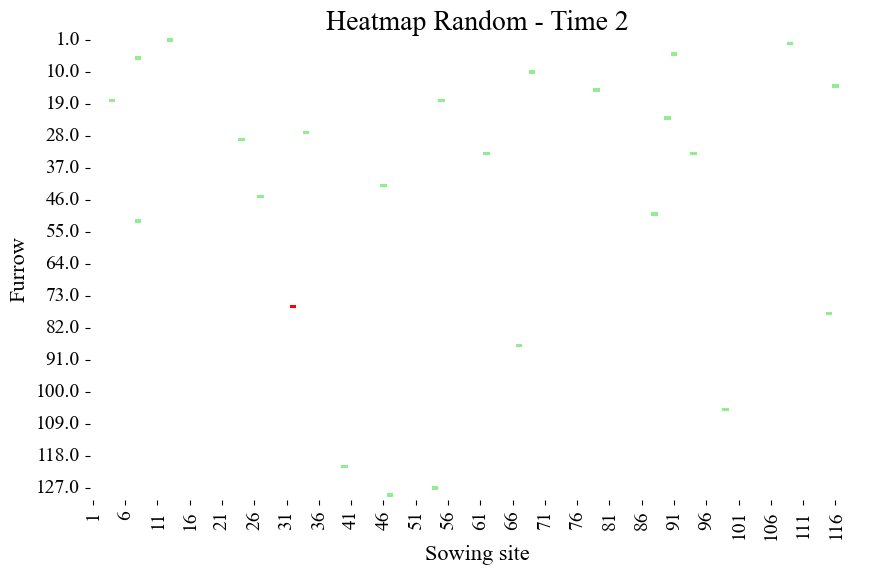

Método: Systematic on grid
Media: 0.200, Std: 0.408, Var: 0.167, CV: 83.33%, Prob. planta enferma: 0.996


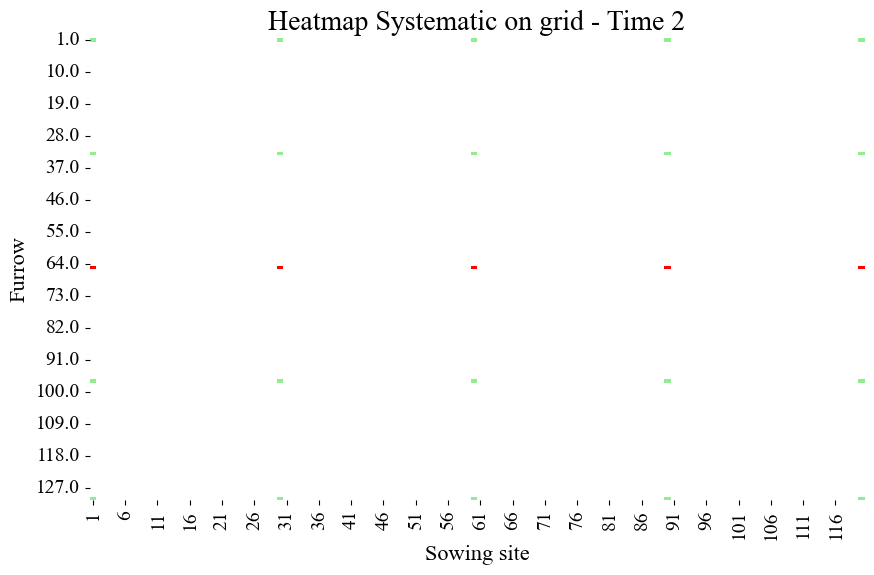

Método: Stratified
Media: 0.208, Std: 0.415, Var: 0.172, CV: 82.61%, Prob. planta enferma: 0.996


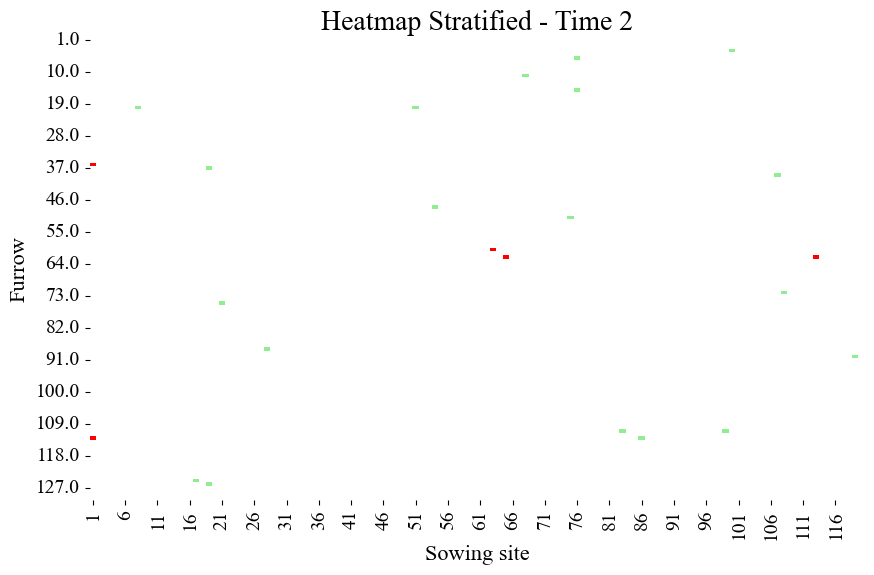

Método: Cluster
Media: 0.040, Std: 0.200, Var: 0.040, CV: 100.00%, Prob. planta enferma: 0.640


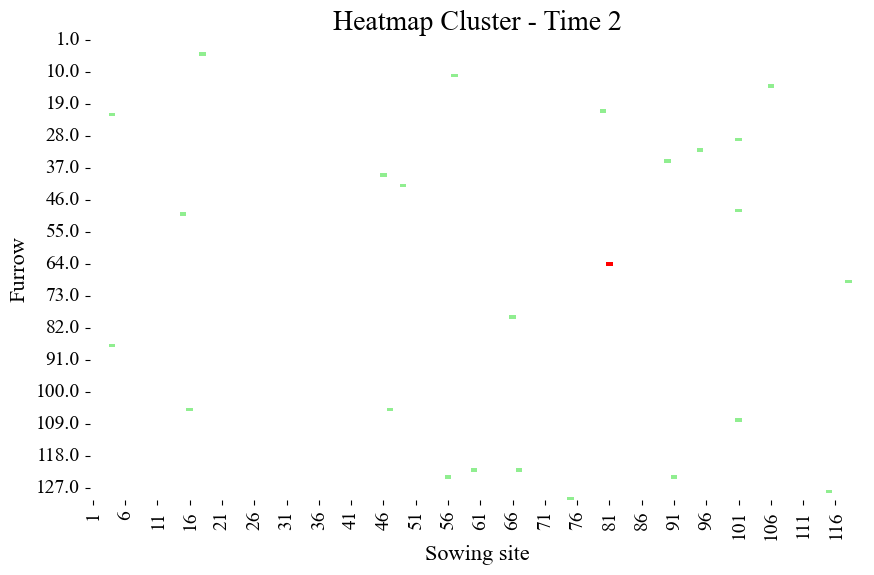


--- Tiempo: 3 | Tamaño muestra ajustado: 30 ---
Método: Random
Media: 0.100, Std: 0.305, Var: 0.093, CV: 93.10%, Prob. planta enferma: 0.958


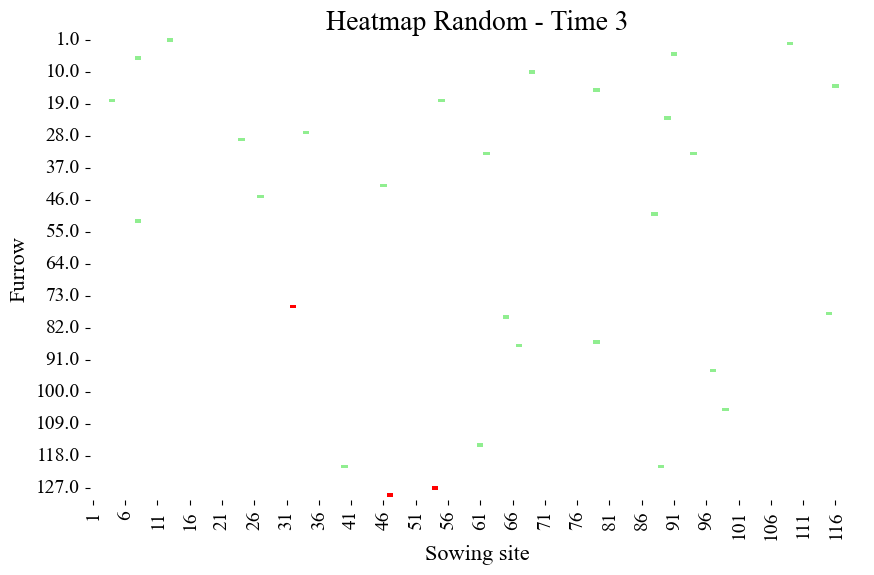

Método: Systematic on grid
Media: 0.200, Std: 0.407, Var: 0.166, CV: 82.76%, Prob. planta enferma: 0.999


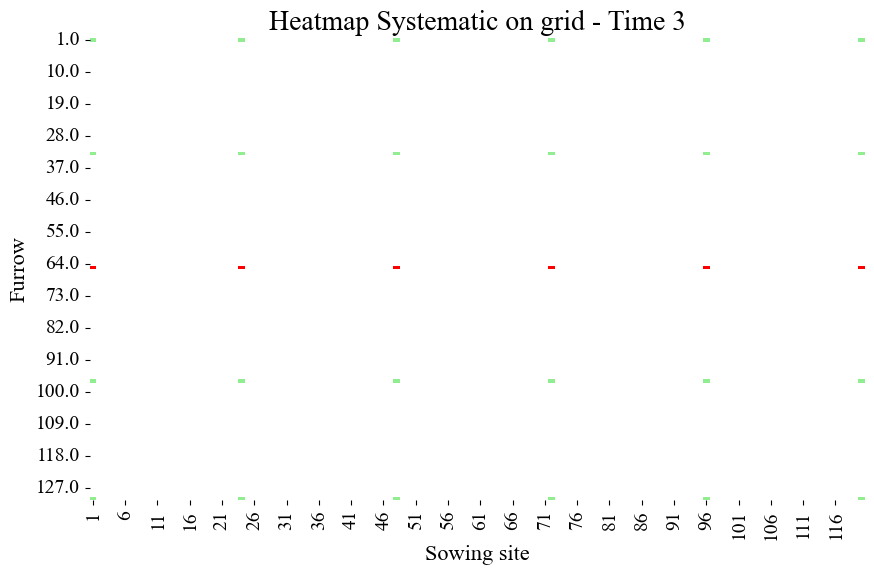

Método: Stratified
Media: 0.179, Std: 0.390, Var: 0.152, CV: 85.19%, Prob. planta enferma: 0.996


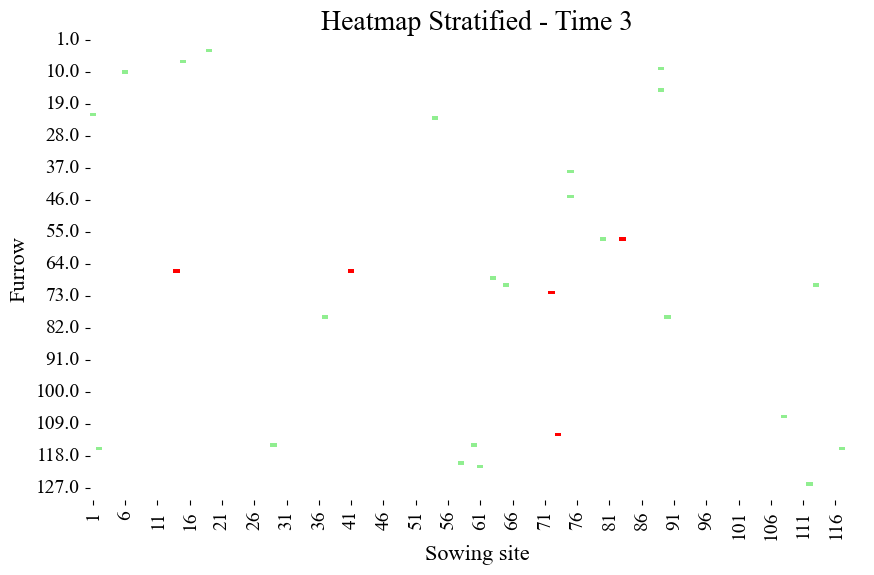

Método: Cluster
Media: 0.133, Std: 0.346, Var: 0.120, CV: 89.66%, Prob. planta enferma: 0.986


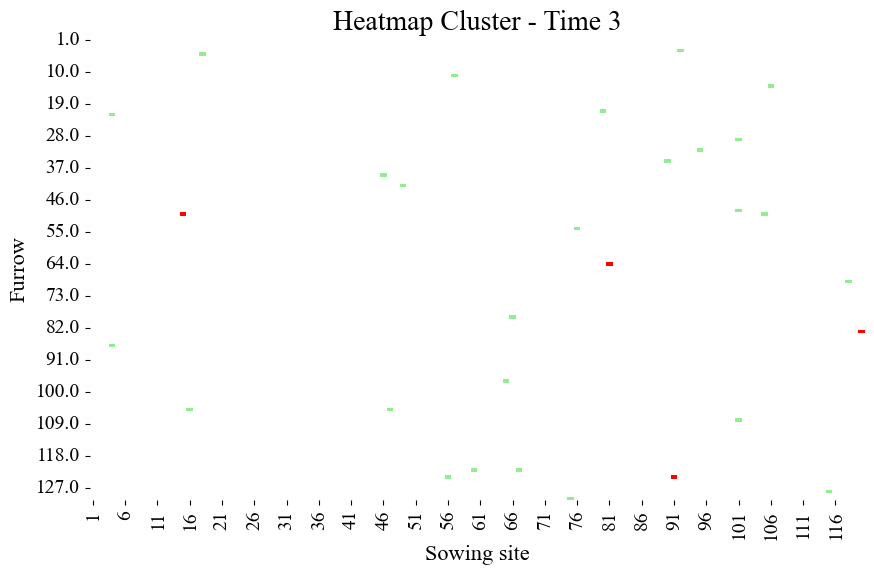


--- Tiempo: 4 | Tamaño muestra ajustado: 45 ---
Método: Random
Media: 0.111, Std: 0.318, Var: 0.101, CV: 90.91%, Prob. planta enferma: 0.995


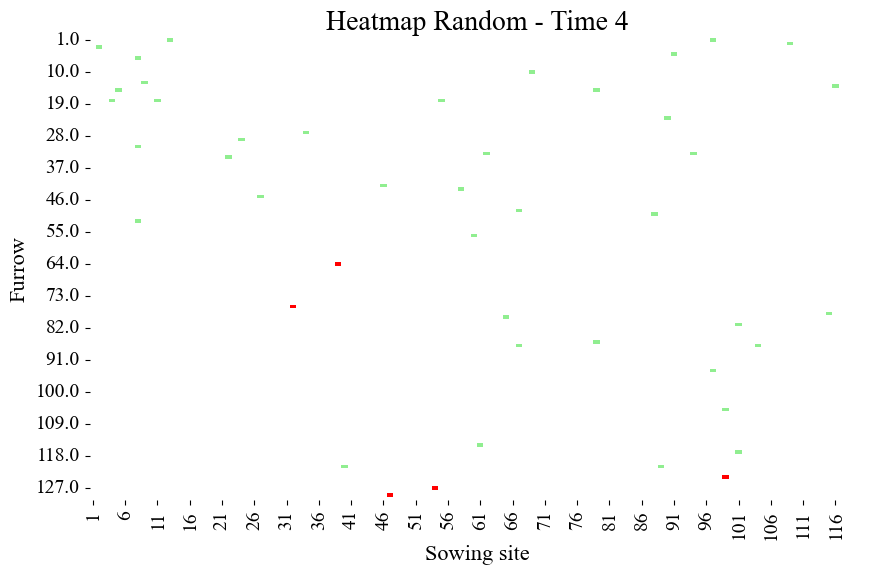

Método: Systematic on grid
Media: 0.089, Std: 0.288, Var: 0.083, CV: 93.18%, Prob. planta enferma: 0.985


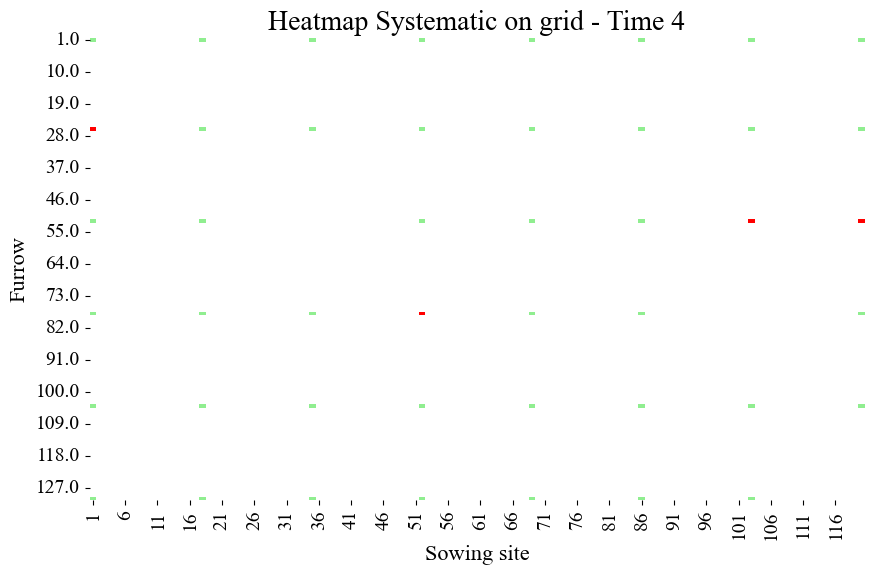

Método: Stratified
Media: 0.227, Std: 0.424, Var: 0.180, CV: 79.07%, Prob. planta enferma: 1.000


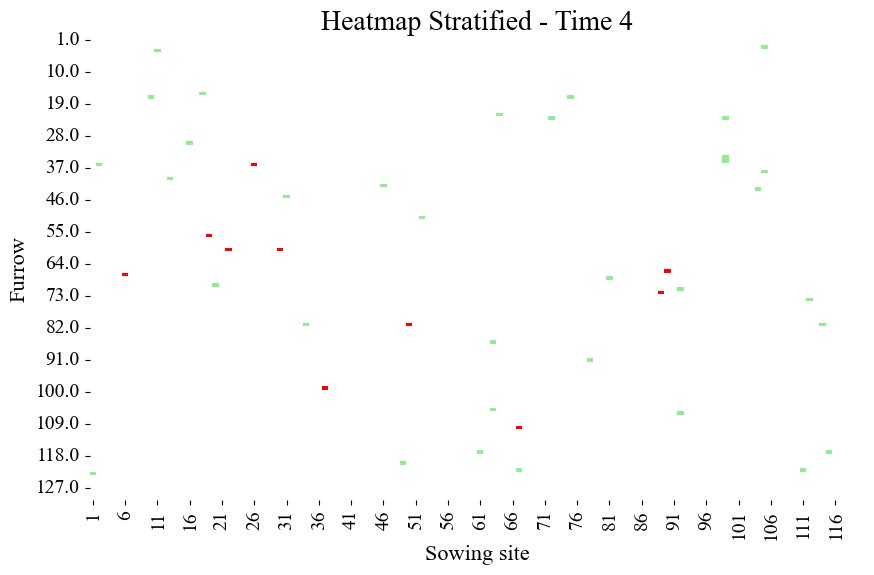

Método: Cluster
Media: 0.289, Std: 0.458, Var: 0.210, CV: 72.73%, Prob. planta enferma: 1.000


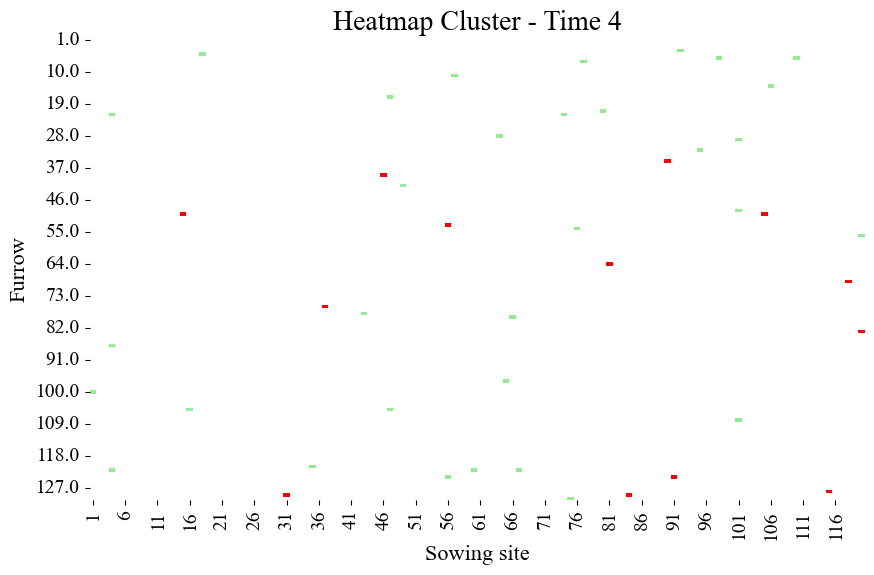


--- Tiempo: 5 | Tamaño muestra ajustado: 65 ---
Método: Random
Media: 0.323, Std: 0.471, Var: 0.222, CV: 68.75%, Prob. planta enferma: 1.000


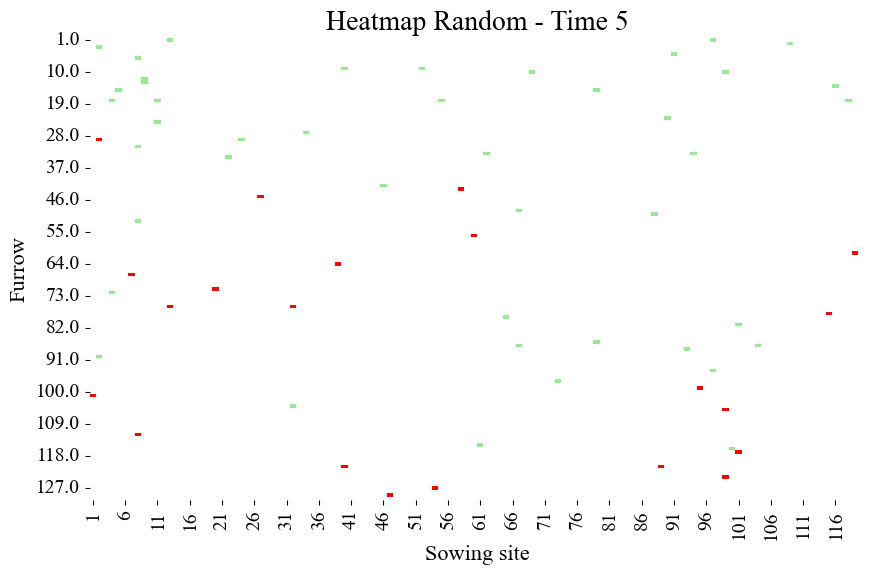

Método: Systematic on grid
Media: 0.400, Std: 0.494, Var: 0.244, CV: 60.94%, Prob. planta enferma: 1.000


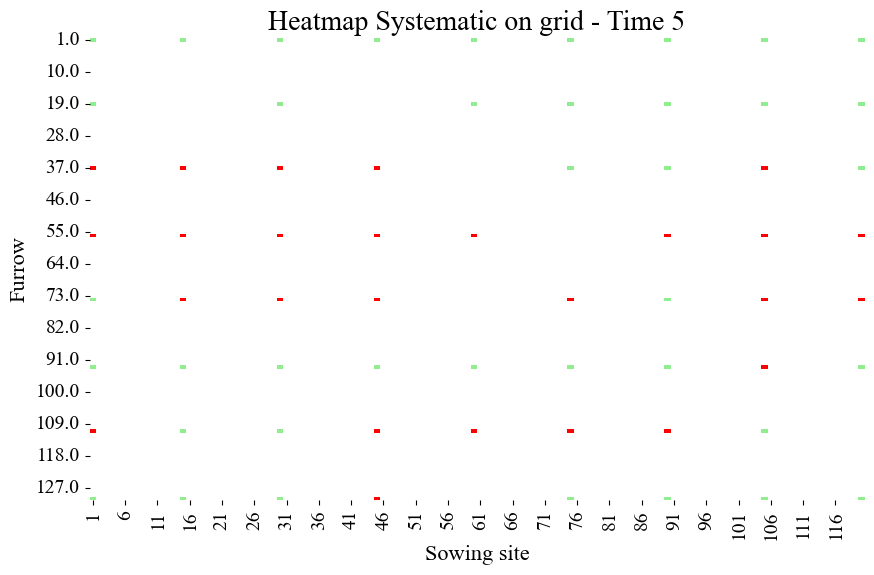

Método: Stratified
Media: 0.359, Std: 0.484, Var: 0.234, CV: 65.08%, Prob. planta enferma: 1.000


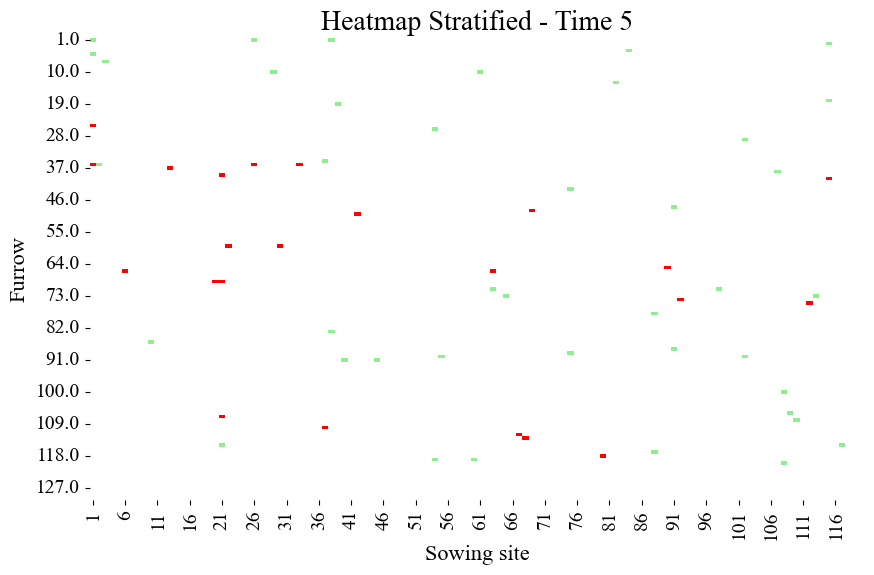

Método: Cluster
Media: 0.446, Std: 0.501, Var: 0.251, CV: 56.25%, Prob. planta enferma: 1.000


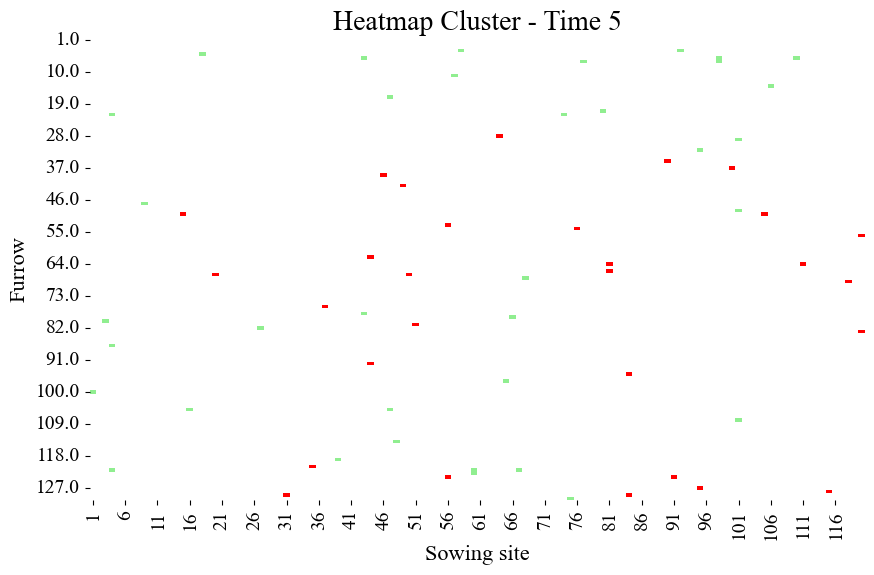


--- Tiempo: 6 | Tamaño muestra ajustado: 65 ---
Método: Random
Media: 0.477, Std: 0.503, Var: 0.253, CV: 53.12%, Prob. planta enferma: 1.000


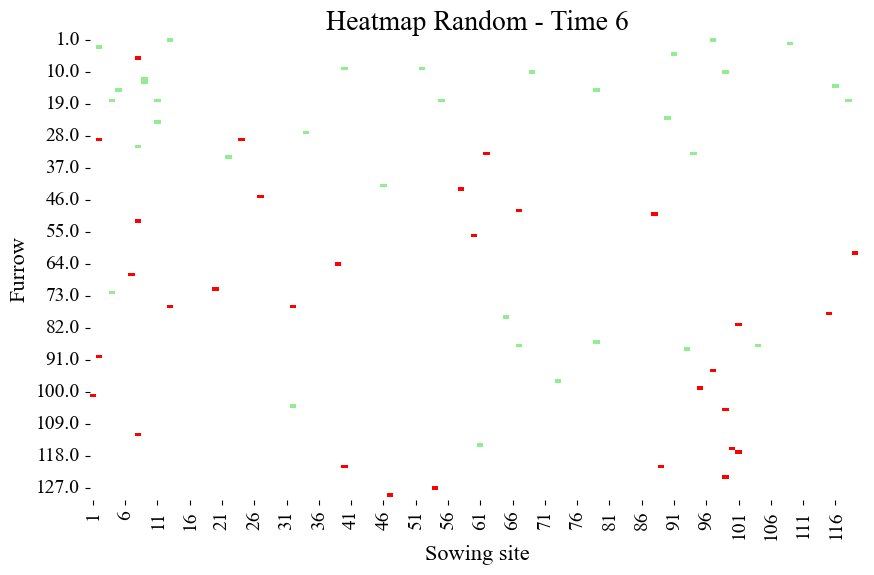

Método: Systematic on grid
Media: 0.569, Std: 0.499, Var: 0.249, CV: 43.75%, Prob. planta enferma: 1.000


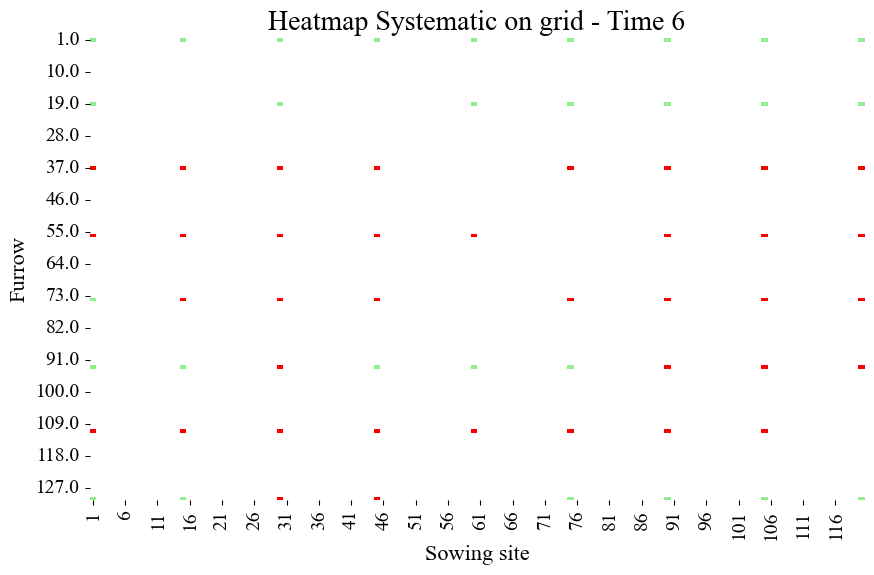

Método: Stratified
Media: 0.500, Std: 0.504, Var: 0.254, CV: 50.79%, Prob. planta enferma: 1.000


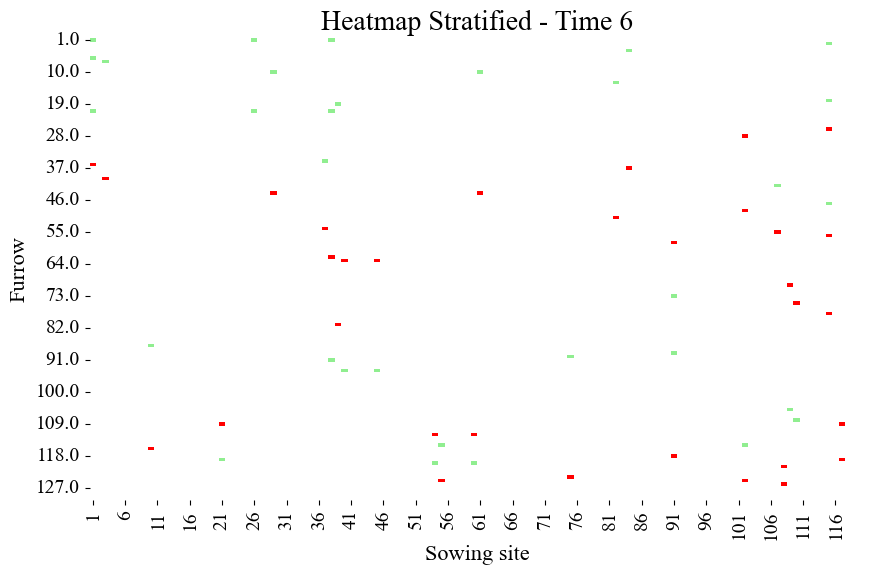

Método: Cluster
Media: 0.538, Std: 0.502, Var: 0.252, CV: 46.88%, Prob. planta enferma: 1.000


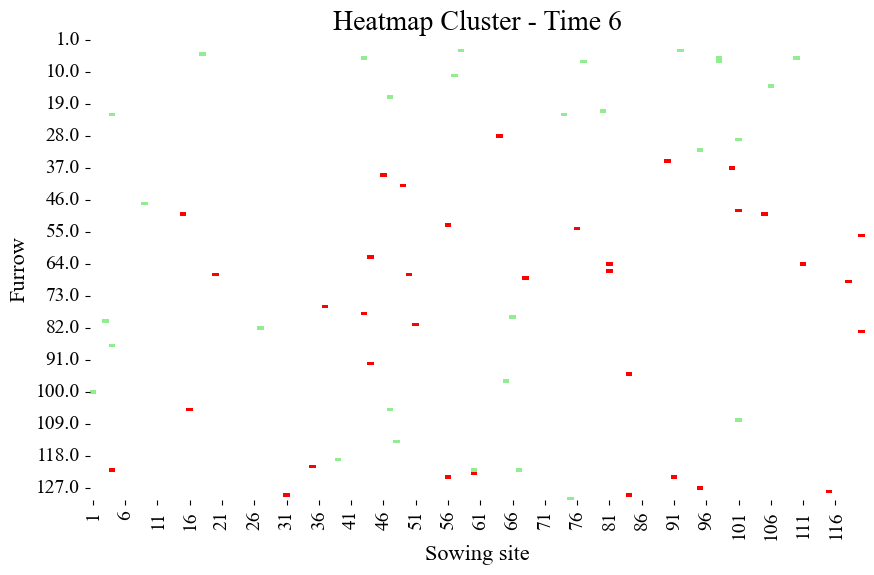


--- Tiempo: 7 | Tamaño muestra ajustado: 60 ---
Método: Random
Media: 0.583, Std: 0.497, Var: 0.247, CV: 42.37%, Prob. planta enferma: 1.000


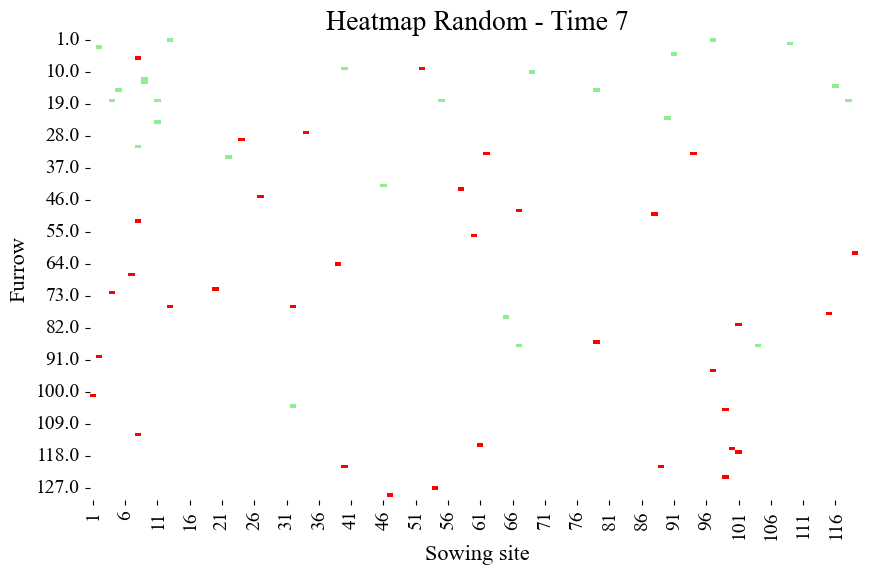

Método: Systematic on grid
Media: 0.533, Std: 0.503, Var: 0.253, CV: 47.46%, Prob. planta enferma: 1.000


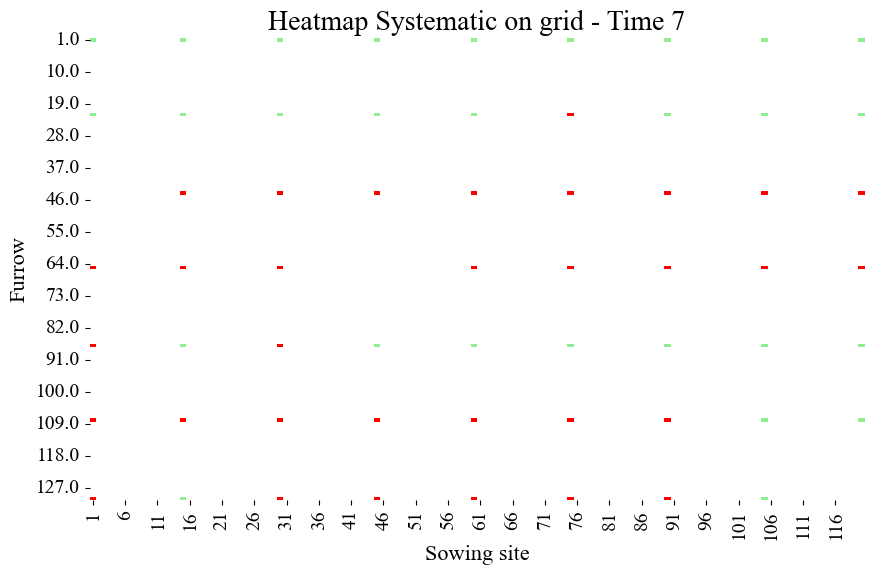

Método: Stratified
Media: 0.533, Std: 0.503, Var: 0.253, CV: 47.46%, Prob. planta enferma: 1.000


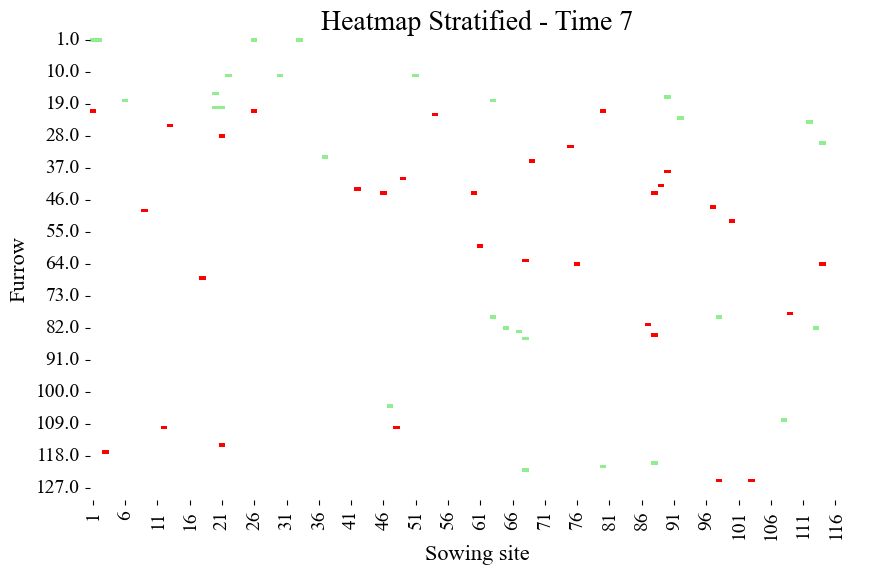

Método: Cluster
Media: 0.700, Std: 0.462, Var: 0.214, CV: 30.51%, Prob. planta enferma: 1.000


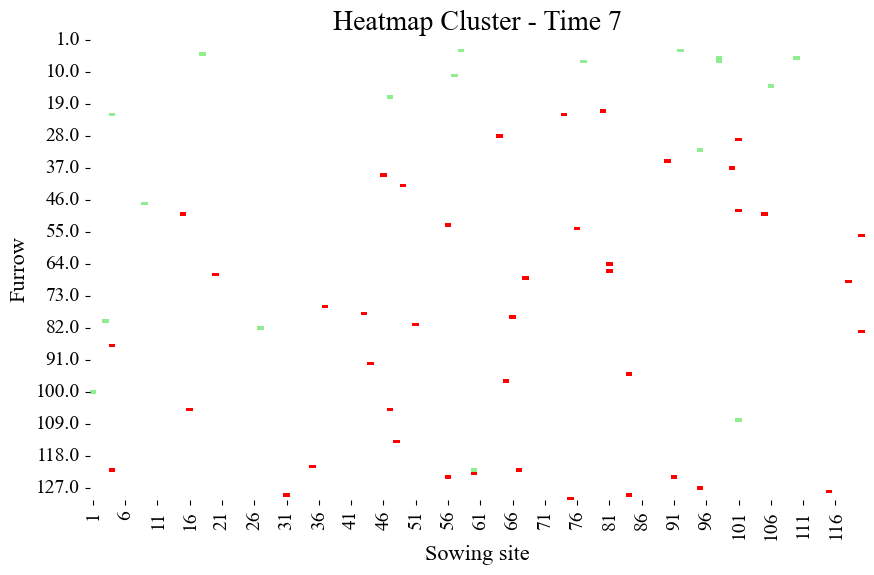


--- Tiempo: 8 | Tamaño muestra ajustado: 50 ---
Método: Random
Media: 0.660, Std: 0.479, Var: 0.229, CV: 34.69%, Prob. planta enferma: 1.000


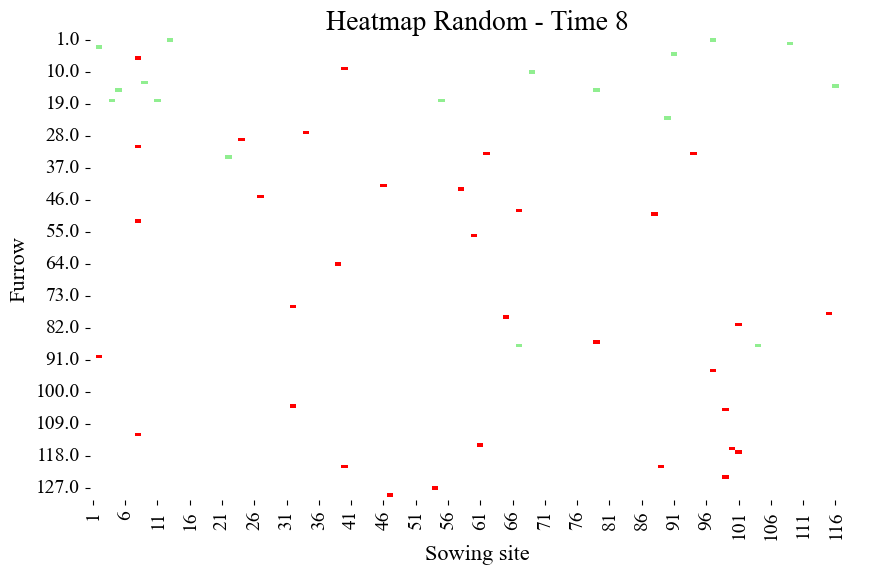

Método: Systematic on grid
Media: 0.780, Std: 0.418, Var: 0.175, CV: 22.45%, Prob. planta enferma: 1.000


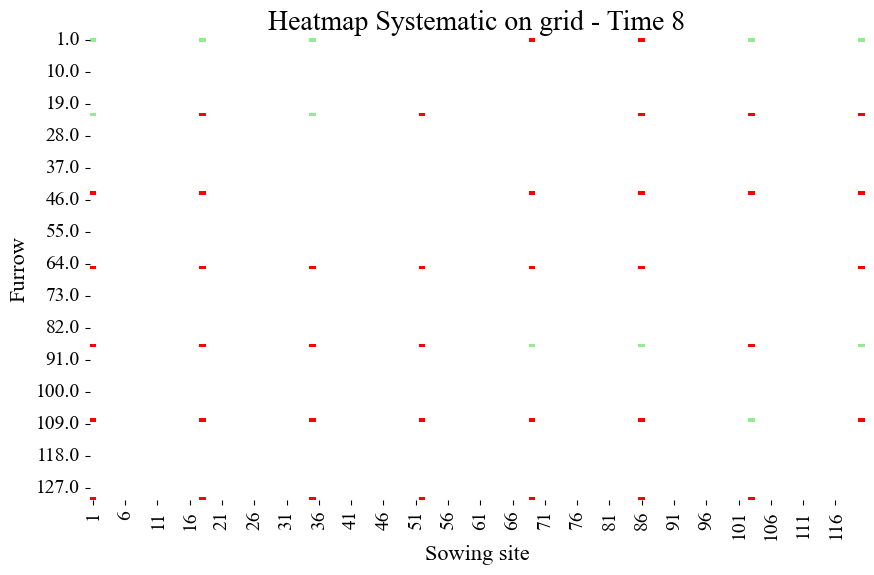

Método: Stratified
Media: 0.708, Std: 0.459, Var: 0.211, CV: 29.79%, Prob. planta enferma: 1.000


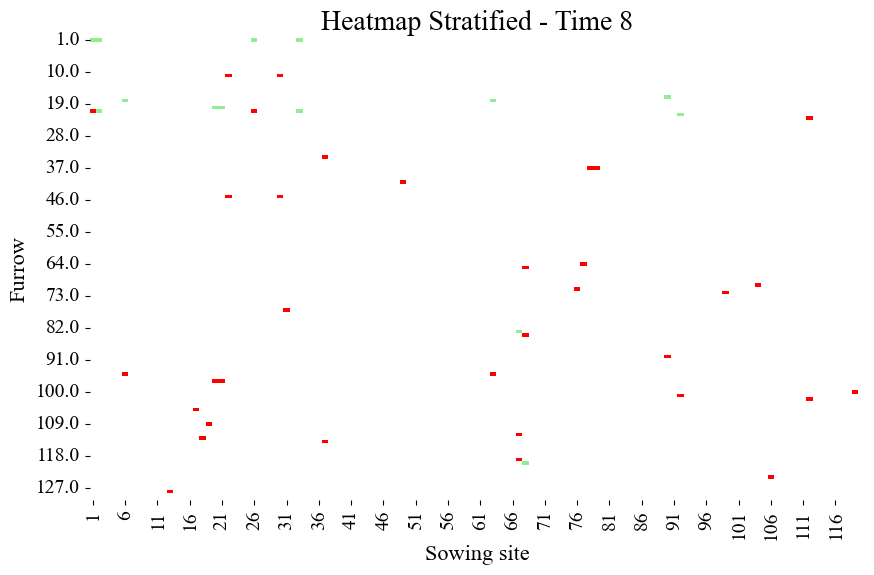

Método: Cluster
Media: 0.780, Std: 0.418, Var: 0.175, CV: 22.45%, Prob. planta enferma: 1.000


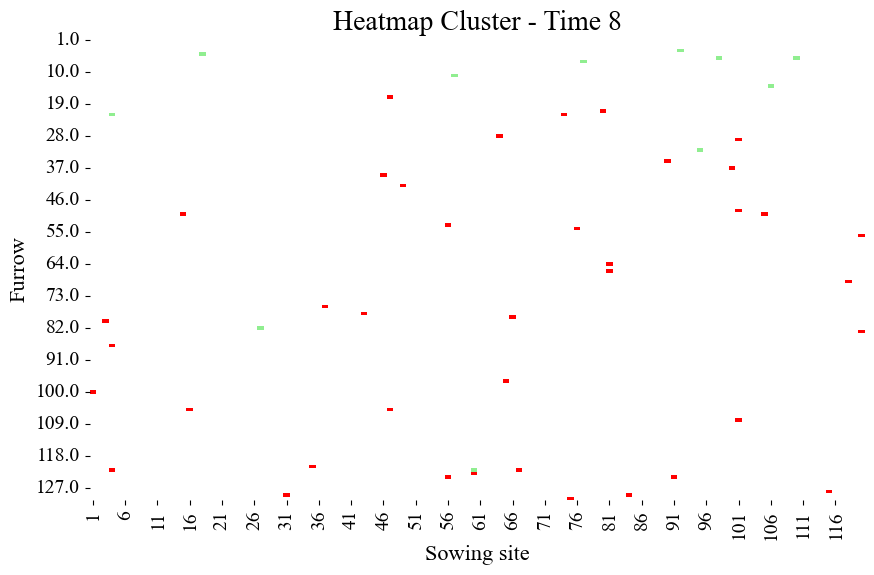


--- Tiempo: 9 | Tamaño muestra ajustado: 35 ---
Método: Random
Media: 0.714, Std: 0.458, Var: 0.210, CV: 29.41%, Prob. planta enferma: 1.000


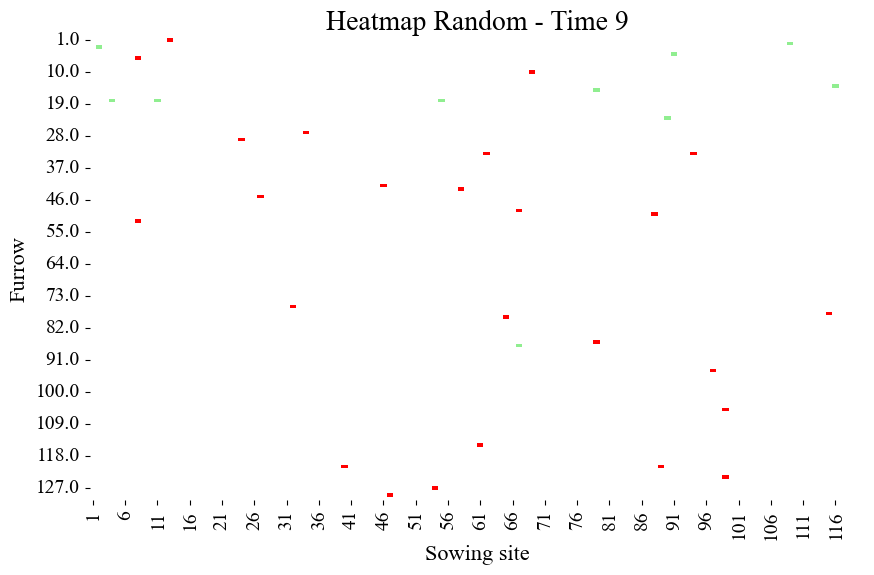

Método: Systematic on grid
Media: 0.771, Std: 0.426, Var: 0.182, CV: 23.53%, Prob. planta enferma: 1.000


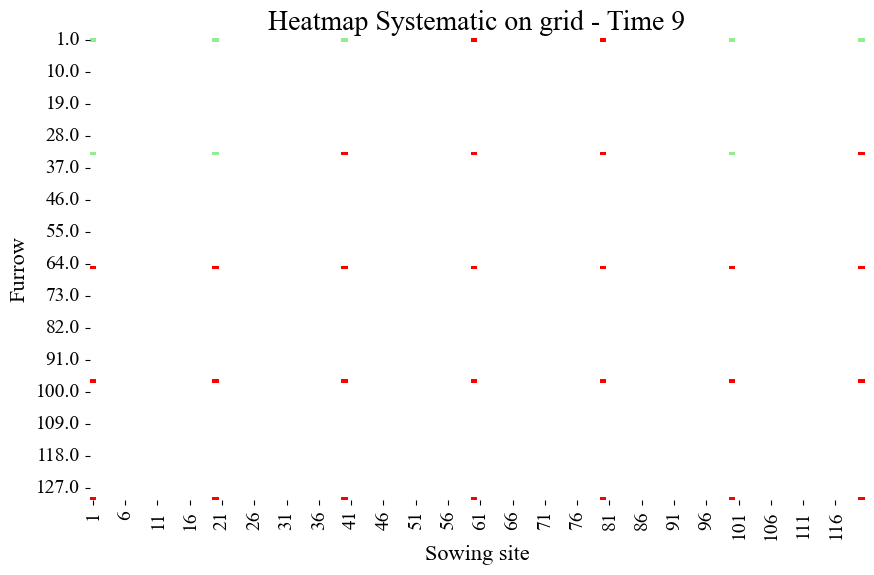

Método: Stratified
Media: 0.647, Std: 0.485, Var: 0.235, CV: 36.36%, Prob. planta enferma: 1.000


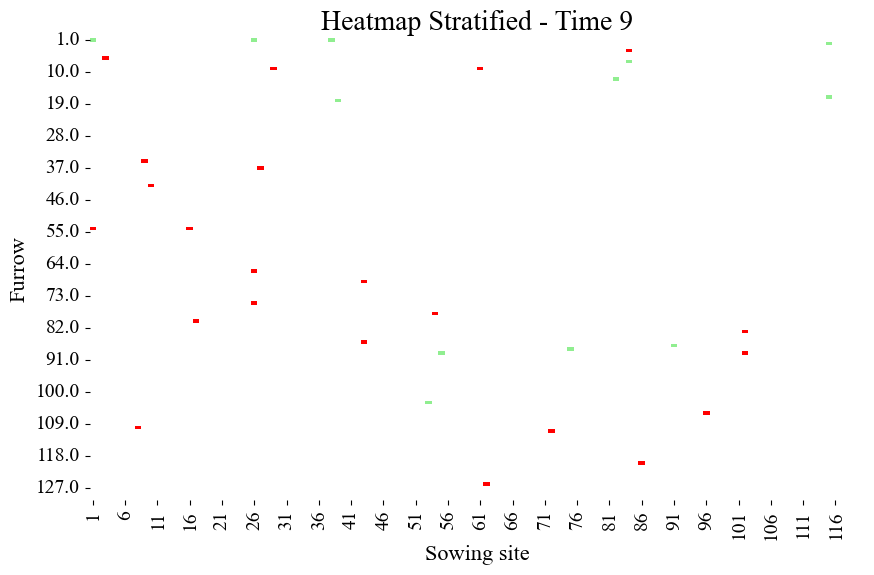

Método: Cluster
Media: 0.829, Std: 0.382, Var: 0.146, CV: 17.65%, Prob. planta enferma: 1.000


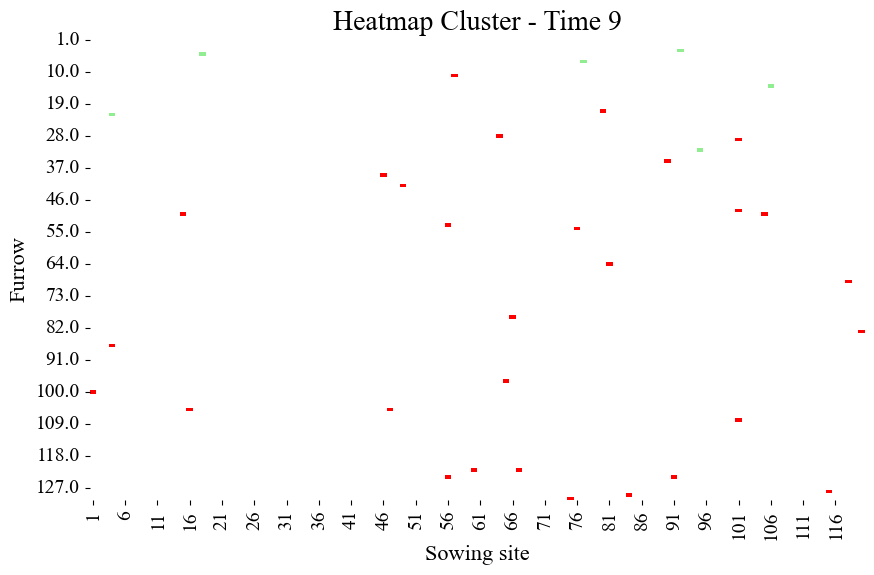


--- Tiempo: 10 | Tamaño muestra ajustado: 25 ---
Método: Random
Media: 0.760, Std: 0.436, Var: 0.190, CV: 25.00%, Prob. planta enferma: 1.000


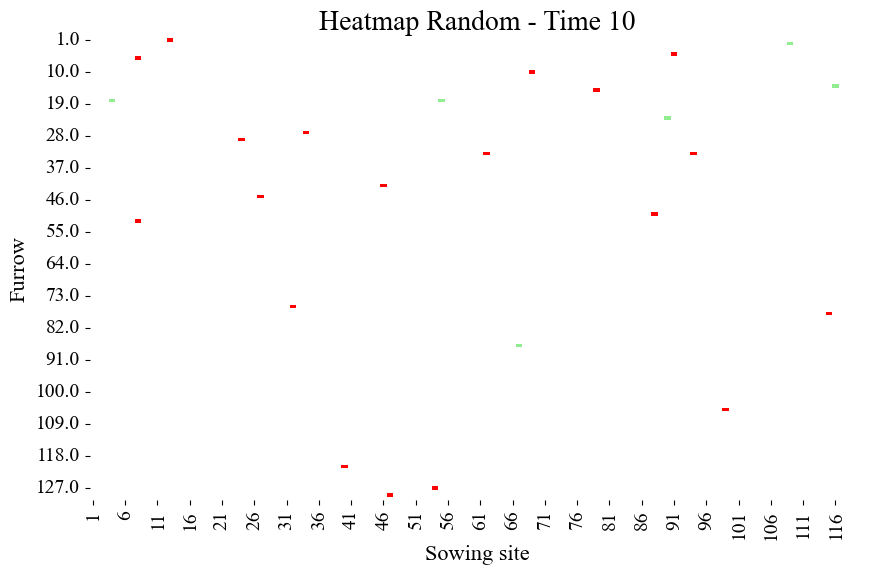

Método: Systematic on grid
Media: 0.960, Std: 0.200, Var: 0.040, CV: 4.17%, Prob. planta enferma: 1.000


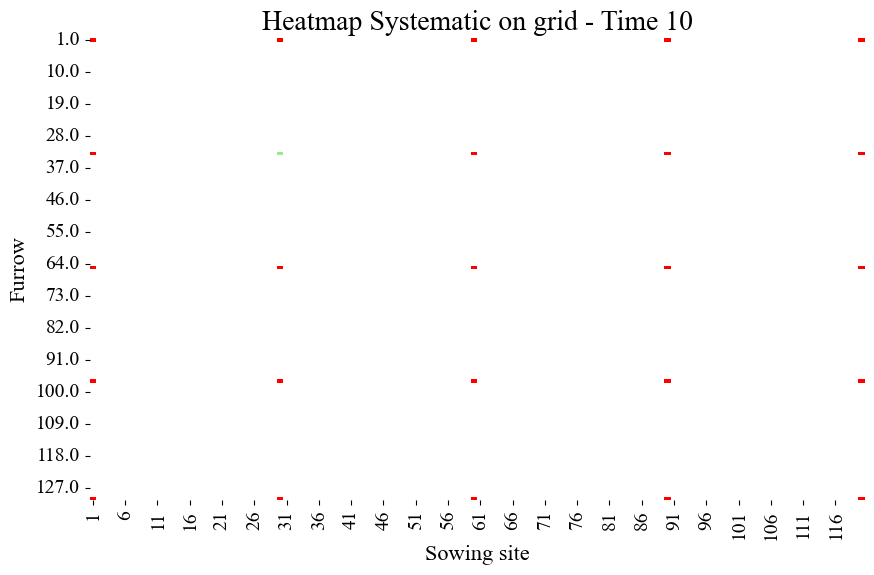

Método: Stratified
Media: 0.880, Std: 0.332, Var: 0.110, CV: 12.50%, Prob. planta enferma: 1.000


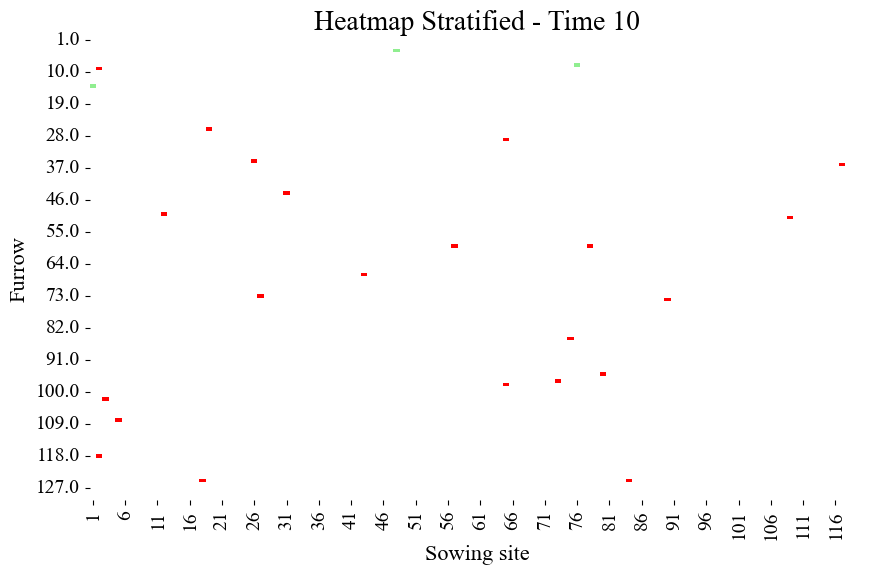

Método: Cluster
Media: 0.960, Std: 0.200, Var: 0.040, CV: 4.17%, Prob. planta enferma: 1.000


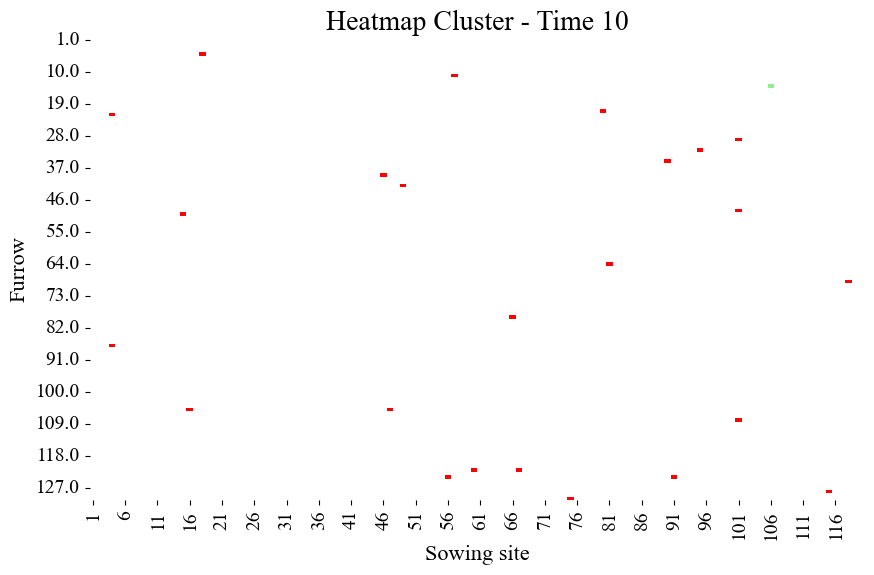


--- Tiempo: 11 | Tamaño muestra ajustado: 15 ---
Método: Random
Media: 0.867, Std: 0.352, Var: 0.124, CV: 14.29%, Prob. planta enferma: 1.000


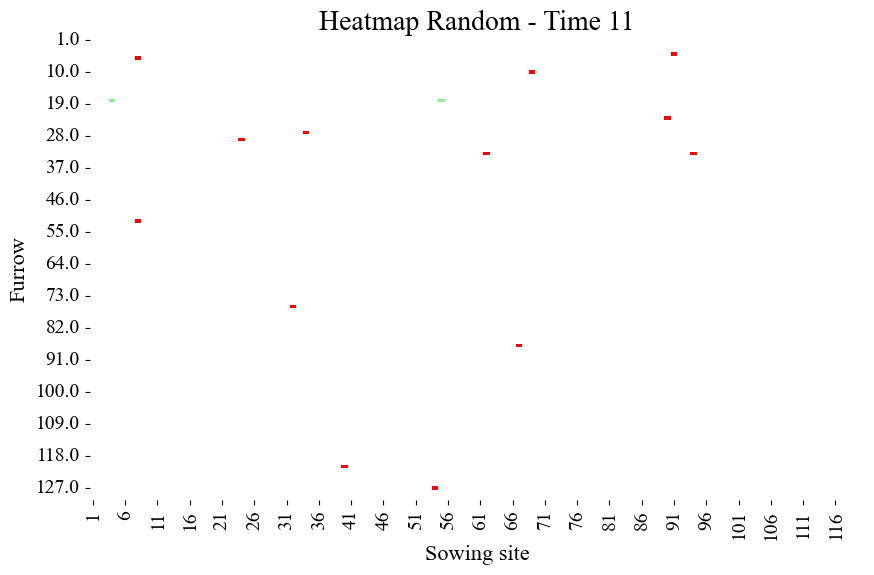

Método: Systematic on grid
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


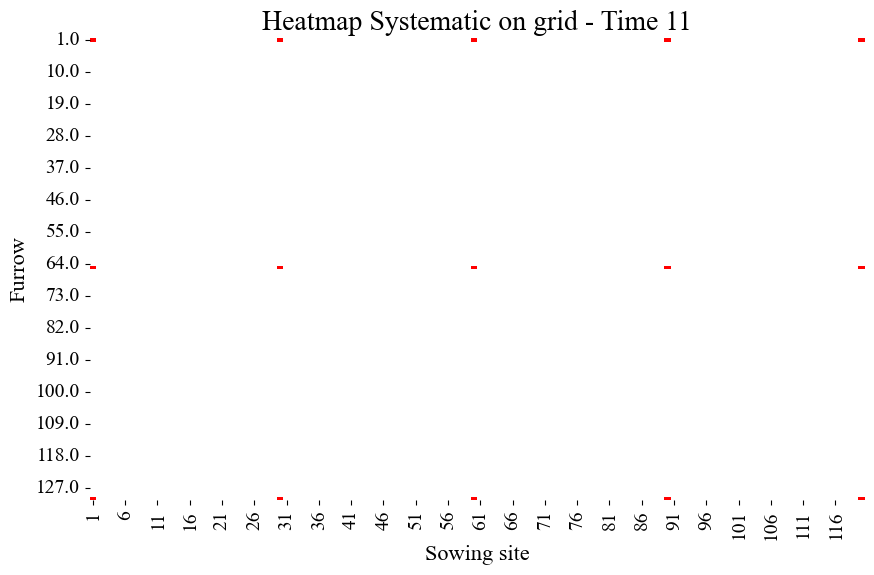

Método: Stratified
Media: 0.933, Std: 0.258, Var: 0.067, CV: 7.14%, Prob. planta enferma: 1.000


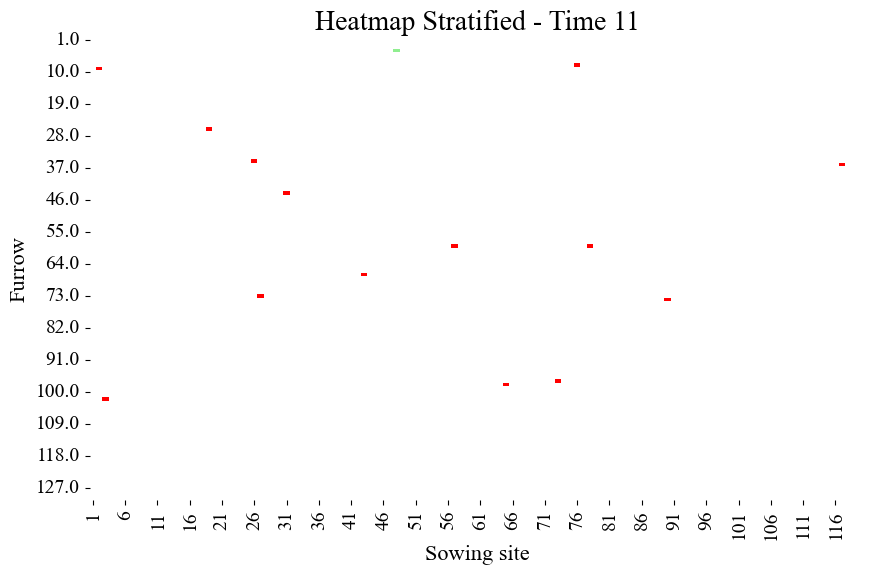

Método: Cluster
Media: 0.933, Std: 0.258, Var: 0.067, CV: 7.14%, Prob. planta enferma: 1.000


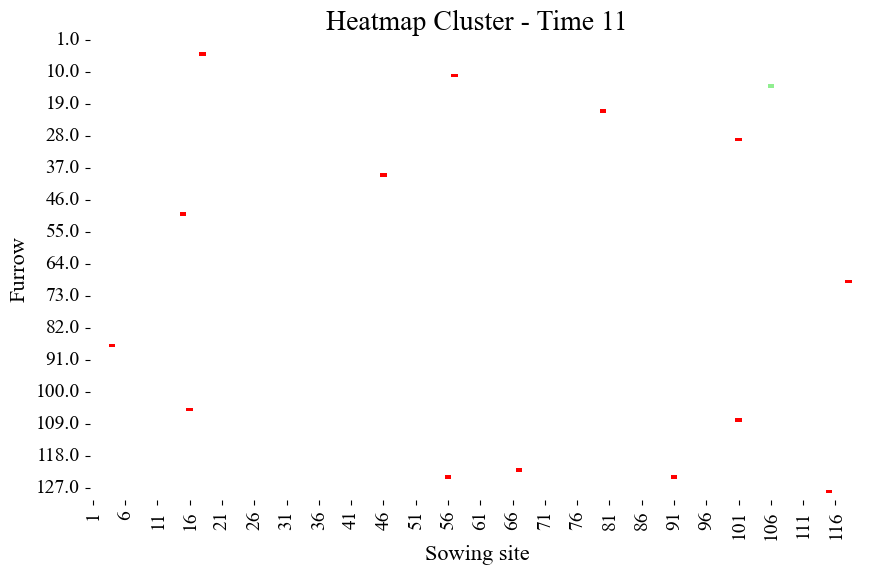


--- Tiempo: 12 | Tamaño muestra ajustado: 10 ---
Método: Random
Media: 0.900, Std: 0.316, Var: 0.100, CV: 11.11%, Prob. planta enferma: 1.000


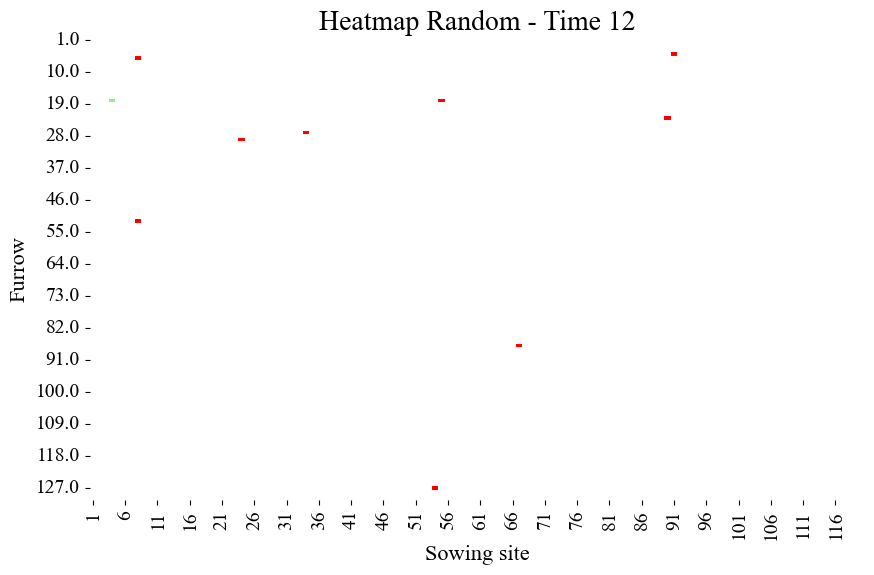

Método: Systematic on grid
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


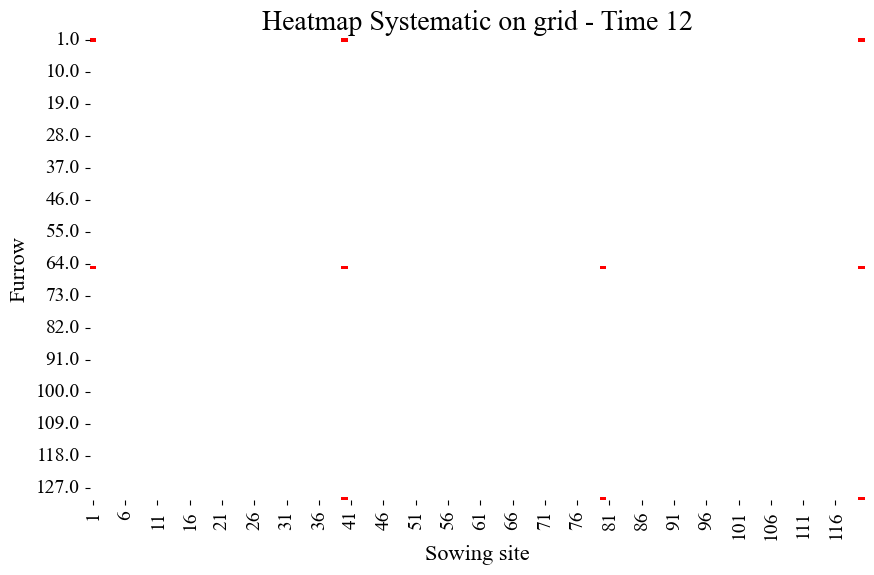

Método: Stratified
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


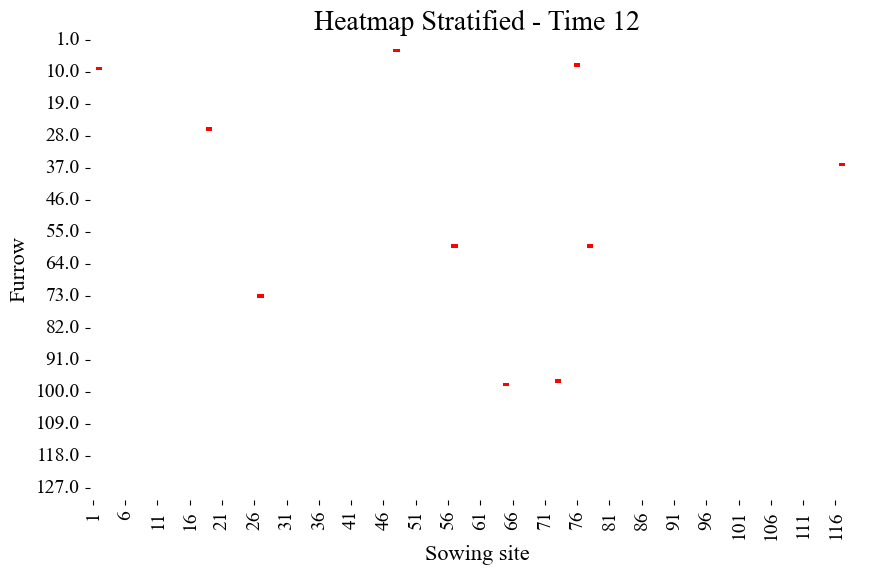

Método: Cluster
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


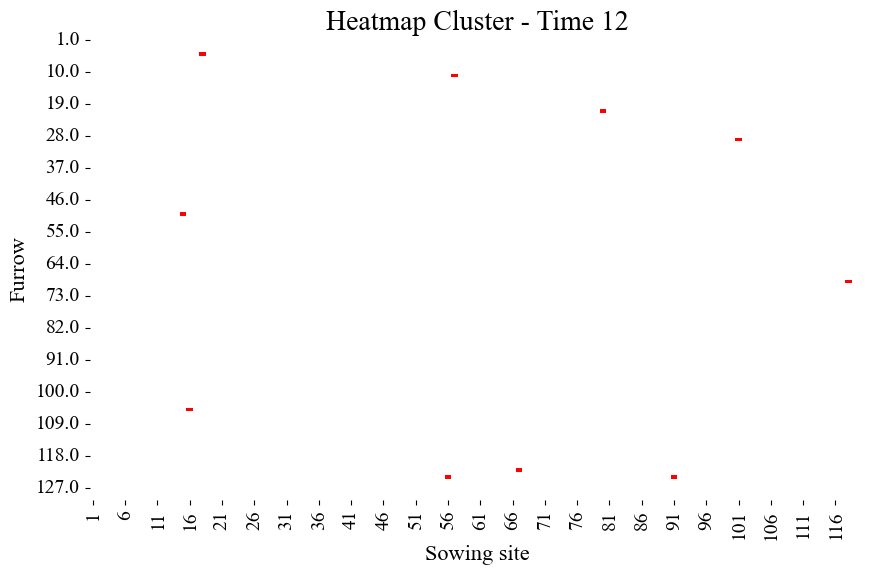

In [23]:
resultados = []

for tiempo in n_opt['Tiempo'].unique():
    df_tiempo = data_35[data_35['Tiempo'] == tiempo].copy()
    n_val = n_opt.loc[n_opt['Tiempo'] == tiempo, 'n_MC'].values
    if len(n_val) == 0:
        print(f"No hay valor de n para tiempo {tiempo}, se omite.")
        continue
    n_muestra = int(np.floor(n_val[0]))
    n_muestra = max(1, min(n_muestra, len(df_tiempo)))

    print(f"\n--- Tiempo: {tiempo} | Tamaño muestra ajustado: {n_muestra} ---")

    for metodo, funcion_muestreo in metodos.items():
        try:
            sample = funcion_muestreo(df_tiempo, n_muestra)
        except ValueError as e:
            print(f"Error muestreando método {metodo} en tiempo {tiempo}: {e}")
            continue

        media, std, var, cv, prob_enferma = calcular_estadisticas(sample)

        print(f"Método: {metodo}")
        print(f"Media: {media:.3f}, Std: {std:.3f}, Var: {var:.3f}, CV: {cv:.2f}%, Prob. planta enferma: {prob_enferma:.3f}")

        plot_heatmap(sample, tiempo, metodo, df_tiempo)

        resultados.append({
            'Tiempo': tiempo,
            'Método': metodo,
            'Media': media,
            'Std': std,
            'Var': var,
            'CV (%)': cv,
            'Probabilidad planta enferma': prob_enferma
        })

df_resultadosMC = pd.DataFrame(resultados)

In [24]:
df_resultados.head()

Tiempo              Método     Media       Std       Var     CV (%)  \
0       1              Random  0.050633  0.220648  0.048685  96.153846   
1       1  Systematic on grid  0.037975  0.192356  0.037001  97.435897   
2       1          Stratified  0.128205  0.336482  0.113220  88.311688   
3       1             Cluster  0.063291  0.245042  0.060045  94.871795   
4       2              Random  0.101695  0.303536  0.092134  90.598291   

   Probabilidad planta enferma  
0                     0.983507  
1                     0.953039  
2                     0.999977  
3                     0.994288  
4                     0.999997

In [25]:
df_resultadosMC = df_resultadosMC.fillna(0)
df_resultadosMC.head()

Tiempo              Método     Media       Std       Var      CV (%)  \
0       1              Random  0.000000  0.000000  0.000000    0.000000   
1       1  Systematic on grid  0.333333  0.487950  0.238095   71.428571   
2       1          Stratified  0.214286  0.425815  0.181319   84.615385   
3       1             Cluster  0.000000  0.000000  0.000000    0.000000   
4       2              Random  0.040000  0.200000  0.040000  100.000000   

   Probabilidad planta enferma  
0                     0.000000  
1                     0.997716  
2                     0.965825  
3                     0.000000  
4                     0.639603

In [26]:
población.columns = ['Nave', 'Tiempo', 'media_población', 'std_población', 'var_población', 'coef_var_población']

In [27]:
df_resultadosMC.columns = ['Tiempo', 'Método', 'MediaMC', 'StdMC', 'VarMC', 'CV (%)MC','Probabilidad planta enfermaMC']

In [28]:
muestreos = pd.merge(df_resultados,df_resultadosMC,on=['Tiempo','Método'])

In [29]:
comparacion_final = pd.merge(muestreos,población[población['Nave']==nave_num],on='Tiempo')
comparacion_final['Bias'] = comparacion_final.apply(lambda x: (x['Media']-x['media_población'])/x['media_población']*100,axis=1)
comparacion_final['BiasMC'] = comparacion_final.apply(lambda x: (x['MediaMC']-x['media_población'])/x['media_población']*100,axis=1)
comparacion_final['Precision_relativa'] = comparacion_final['CV (%)'] / comparacion_final['coef_var_población']
comparacion_final['Precision_relativaMC'] = comparacion_final['CV (%)MC'] / comparacion_final['coef_var_población']
comparacion_final = round(comparacion_final,2)
comparacion_final.to_excel('./Tabla_muestreo.xlsx')
comparacion_final

Tiempo              Método  Media   Std   Var  CV (%)  \
0        1              Random   0.05  0.22  0.05   96.15   
1        1  Systematic on grid   0.04  0.19  0.04   97.44   
2        1          Stratified   0.13  0.34  0.11   88.31   
3        1             Cluster   0.06  0.25  0.06   94.87   
4        2              Random   0.10  0.30  0.09   90.60   
5        2  Systematic on grid   0.04  0.20  0.04   96.58   
6        2          Stratified   0.14  0.35  0.12   87.07   
7        2             Cluster   0.10  0.30  0.09   90.60   
8        3              Random   0.13  0.34  0.12   87.21   
9        3  Systematic on grid   0.15  0.36  0.13   85.47   
10       3          Stratified   0.15  0.35  0.12   85.96   
11       3             Cluster   0.16  0.36  0.13   84.88   
12       4              Random   0.18  0.39  0.15   82.26   
13       4  Systematic on grid   0.20  0.40  0.16   79.84   
14       4          Stratified   0.23  0.42  0.18   77.33   
15       4             Cluster   0.20  0.40  0.16   79.84   
16       5              Random   0.34  0.47  0.22   66.67   
17       5  Systematic on grid   0.34  0.47  0.22   66.67   
18       5          Stratified   0.36  0.48  0.23   64.67   
19       5             Cluster   0.35  0.48  0.23   65.24   
20       6              Random   0.54  0.50  0.25   45.95   
21       6  Systematic on grid   0.47  0.50  0.25   52.97   
22       6          Stratified   0.53  0.50  0.25   46.87   
23       6             Cluster   0.53  0.50  0.25   47.57   
24       7              Random   0.65  0.48  0.23   34.73   
25       7  Systematic on grid   0.69  0.46  0.22   31.44   
26       7          Stratified   0.57  0.50  0.25   43.37   
27       7             Cluster   0.68  0.47  0.22   31.74   
28       8              Random   0.75  0.44  0.19   25.36   
29       8  Systematic on grid   0.77  0.42  0.18   23.21   
30       8          Stratified   0.67  0.47  0.22   33.09   
31       8             Cluster   0.77  0.42  0.18   22.86   
32       9              Random   0.85  0.36  0.13   15.46   
33       9  Systematic on grid   0.83  0.38  0.14   16.91   
34       9          Stratified   0.70  0.46  0.21   29.95   
35       9             Cluster   0.86  0.35  0.12   14.49   
36      10              Random   0.89  0.32  0.10   11.45   
37      10  Systematic on grid   0.94  0.24  0.06    6.11   
38      10          Stratified   0.86  0.34  0.12   13.74   
39      10             Cluster   0.91  0.29  0.08    9.16   
40      11              Random   0.91  0.29  0.08    9.09   
41      11  Systematic on grid   0.92  0.27  0.07    7.79   
42      11          Stratified   0.90  0.31  0.09   10.39   
43      11             Cluster   0.94  0.25  0.06    6.49   
44      12              Random   0.95  0.22  0.05    5.26   
45      12  Systematic on grid   1.00  0.00  0.00    0.00   
46      12          Stratified   1.00  0.00  0.00    0.00   
47      12             Cluster   0.97  0.16  0.03    2.63   

    Probabilidad planta enferma  MediaMC  StdMC  VarMC  ...  \
0                          0.98     0.00   0.00   0.00  ...   
1                          0.95     0.33   0.49   0.24  ...   
2                          1.00     0.21   0.43   0.18  ...   
3                          0.99     0.00   0.00   0.00  ...   
4                          1.00     0.04   0.20   0.04  ...   
5                          0.99     0.20   0.41   0.17  ...   
6                          1.00     0.21   0.41   0.17  ...   
7                          1.00     0.04   0.20   0.04  ...   
8                          1.00     0.10   0.31   0.09  ...   
9                          1.00     0.20   0.41   0.17  ...   
10                         1.00     0.18   0.39   0.15  ...   
11                         1.00     0.13   0.35   0.12  ...   
12                         1.00     0.11   0.32   0.10  ...   
13                         1.00     0.09   0.29   0.08  ...   
14                         1.00     0.23   0.42   0.18  ...   
15    

In [30]:
comparacion_final.columns

Index(['Tiempo', 'Método', 'Media', 'Std', 'Var', 'CV (%)',
       'Probabilidad planta enferma', 'MediaMC', 'StdMC', 'VarMC', 'CV (%)MC',
       'Probabilidad planta enfermaMC', 'Nave', 'media_población',
       'std_población', 'var_población', 'coef_var_población', 'Bias',
       'BiasMC', 'Precision_relativa', 'Precision_relativaMC'],
      dtype='object')

In [31]:
comparacion_final[comparacion_final['Método']=='Cluster'][['CV (%)','CV (%)MC','coef_var_población']]

CV (%)  CV (%)MC  coef_var_población
3    94.87      0.00               94.46
7    90.60    100.00               91.49
11   84.88     89.66               86.84
15   79.84     72.73               79.15
19   65.24     56.25               62.48
23   47.57     46.88               45.29
27   31.74     30.51               33.62
31   22.86     22.45               24.85
35   14.49     17.65               16.48
39    9.16      4.17                9.61
43    6.49      7.14                5.44
47    2.63      0.00                2.63

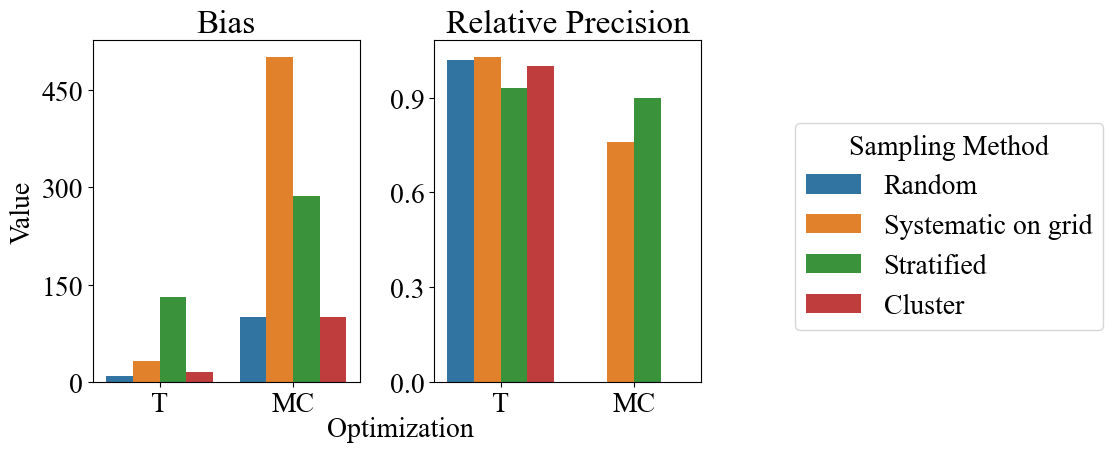

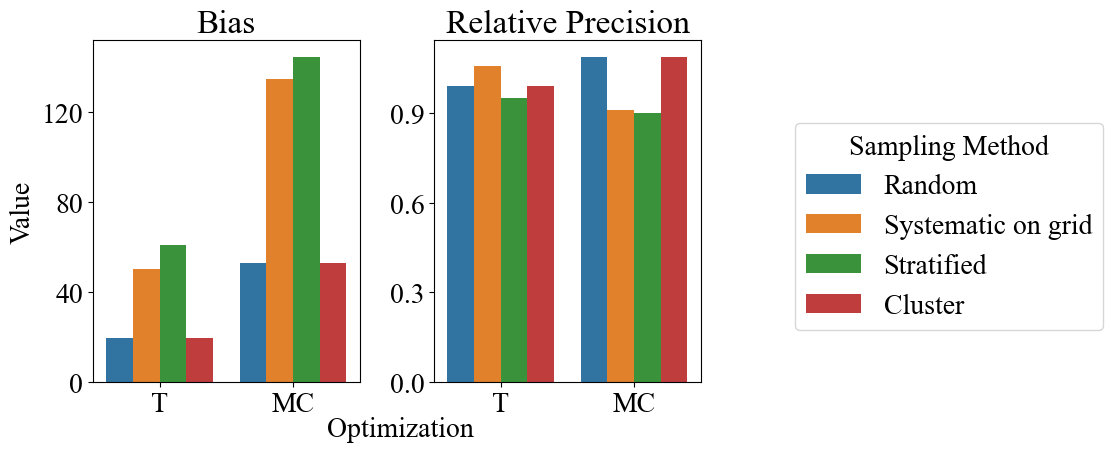

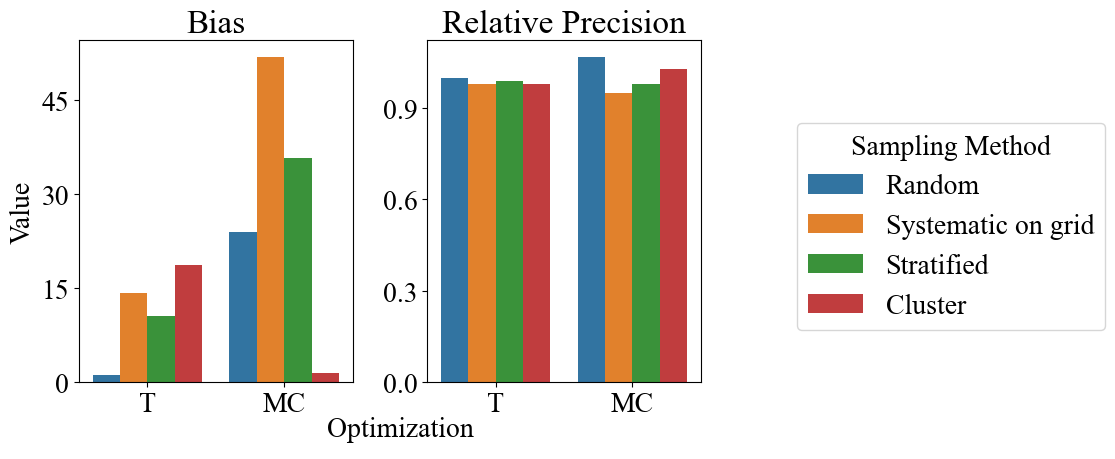

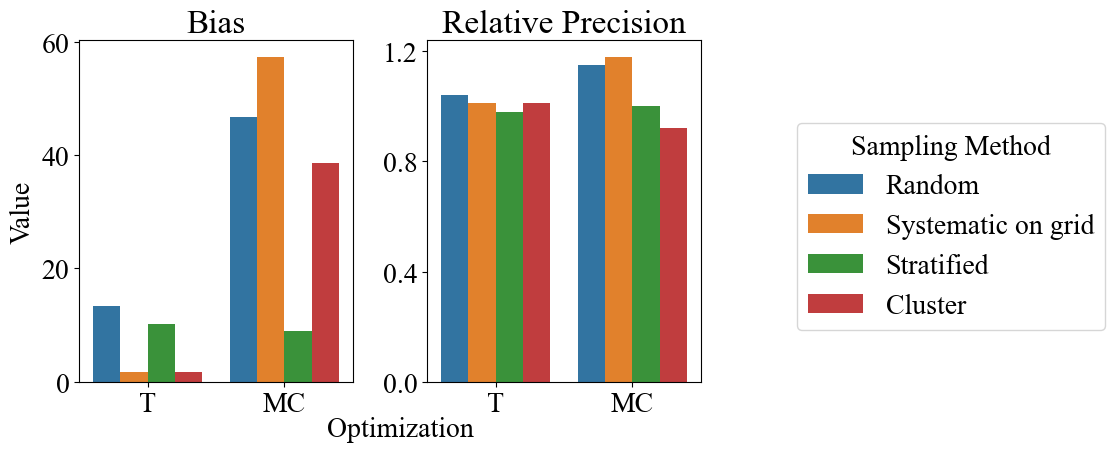

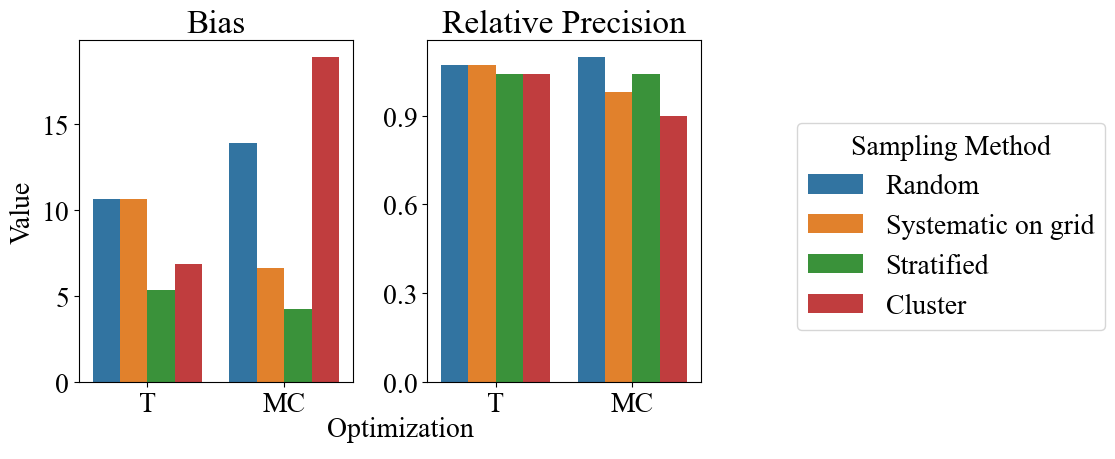

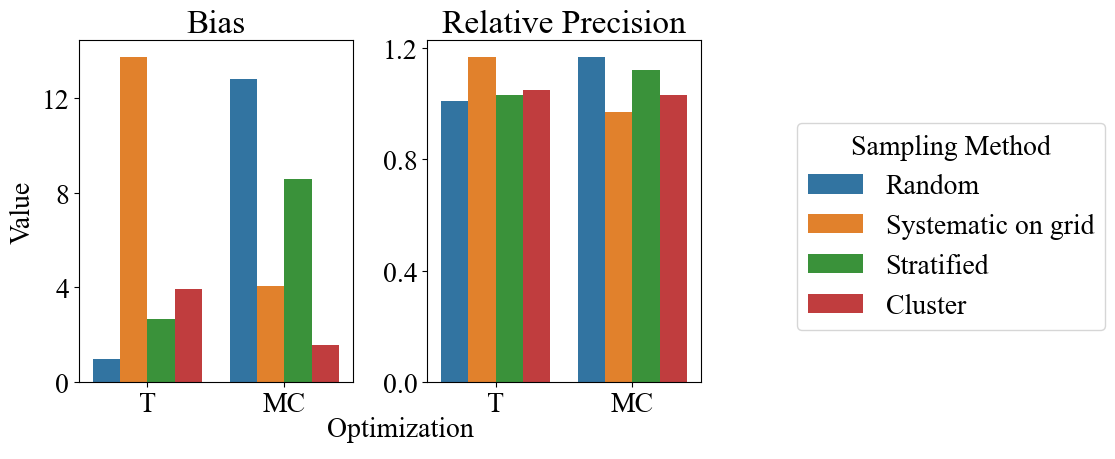

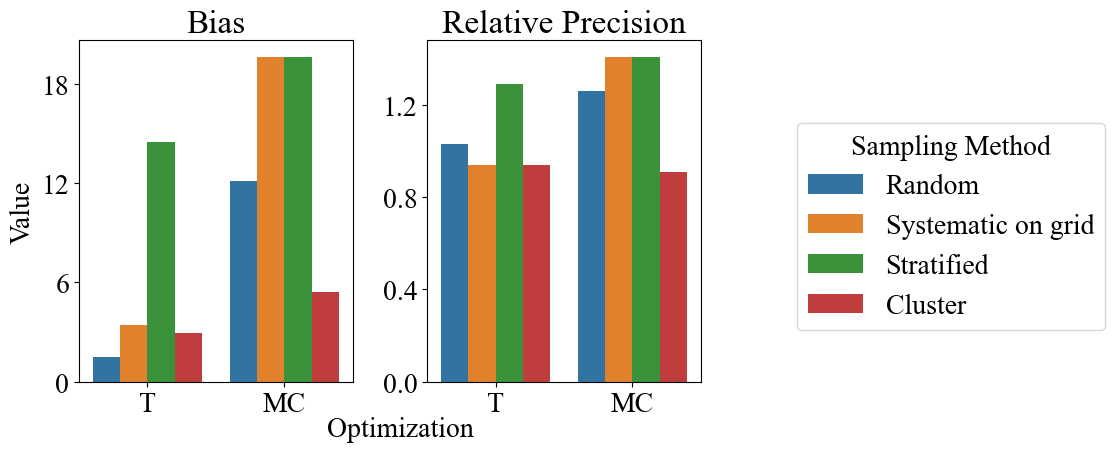

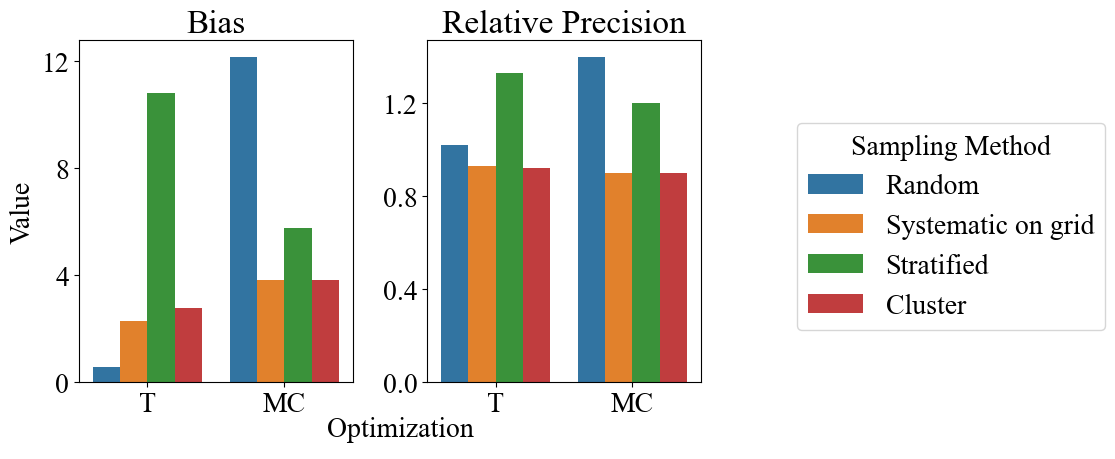

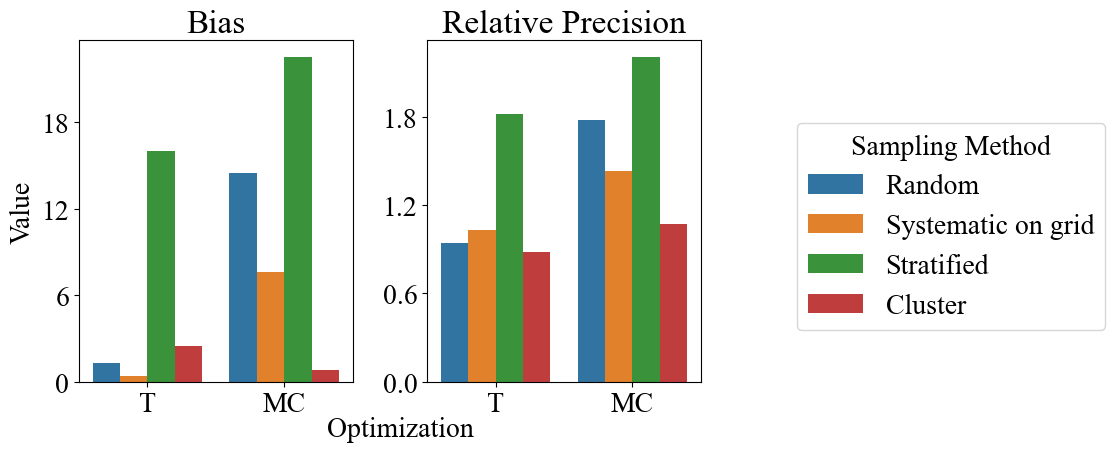

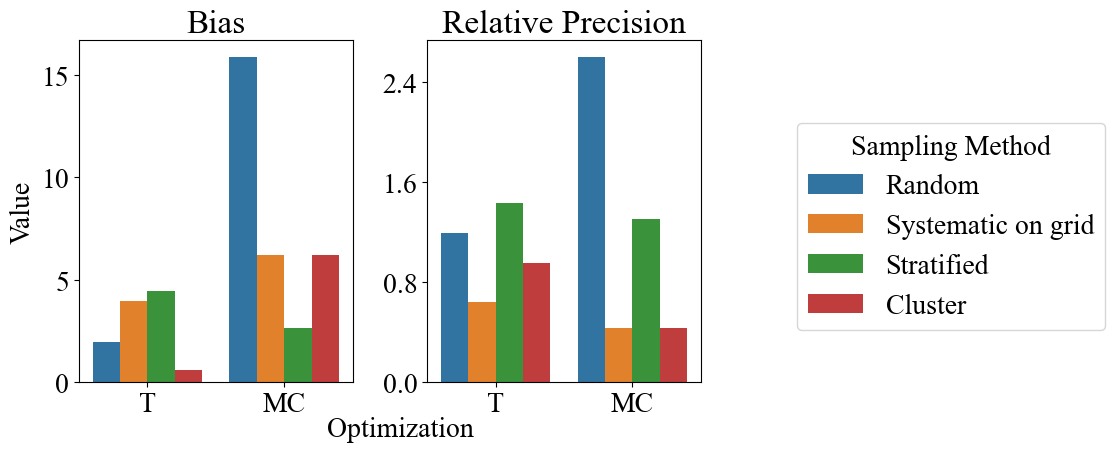

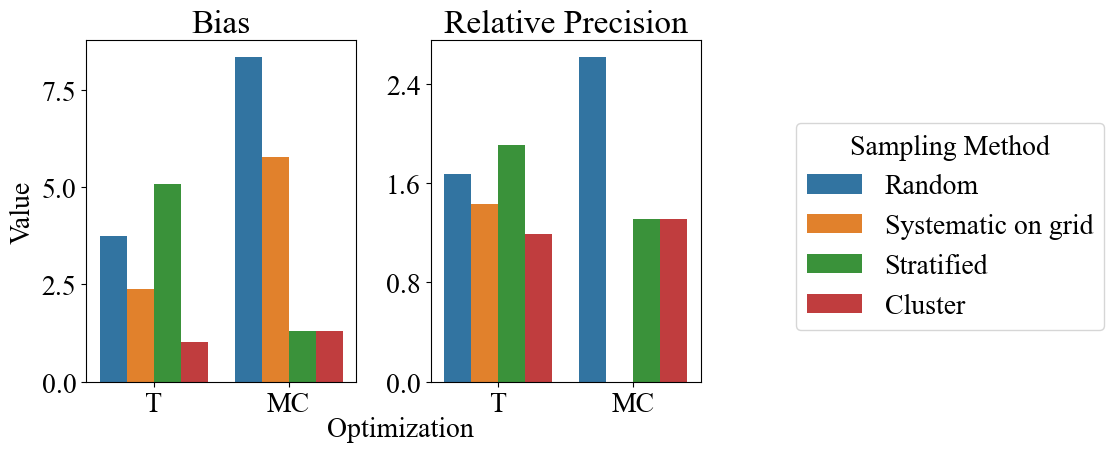

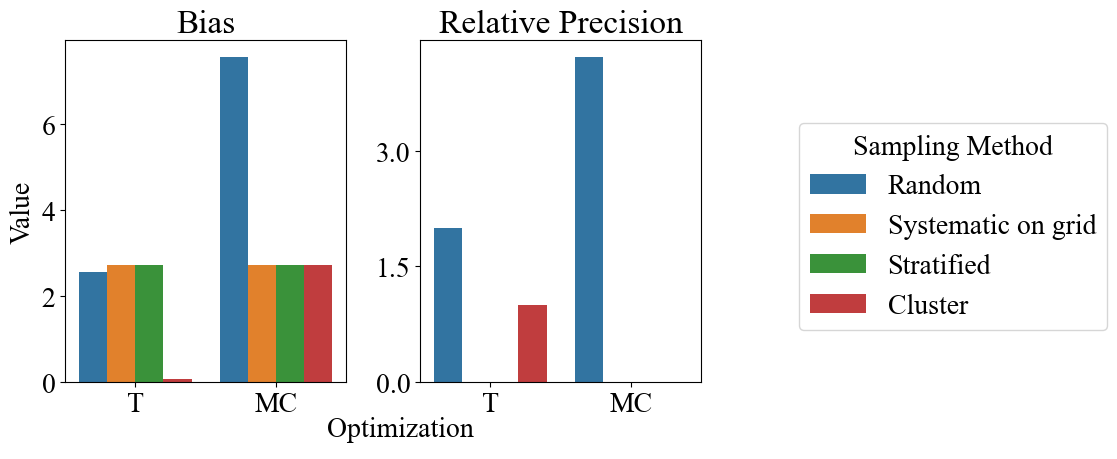

In [32]:
for tiempo in comparacion_final['Tiempo'].unique():
    comparacion_final1 = comparacion_final[comparacion_final['Tiempo']==tiempo]
    numericas = comparacion_final1.select_dtypes(include=['number']).columns
    comparacion_final1[numericas] = comparacion_final1[numericas].abs()
    bias_pre = comparacion_final1.groupby('Método')[['Bias', 'BiasMC', 'Precision_relativa', 'Precision_relativaMC']].mean().reset_index()
    bias_melt = bias_pre.melt(
        id_vars='Método',
        value_vars=['Bias', 'BiasMC'],
        var_name='Tipo',
        value_name='Valor'
    )
    bias_melt['Medida'] = 'Bias'
    bias_melt['Tipo'] = bias_melt['Tipo'].map({'Bias': 'T', 'BiasMC': 'MC'})

    prec_melt = bias_pre.melt(
        id_vars='Método',
        value_vars=['Precision_relativa', 'Precision_relativaMC'],
        var_name='Tipo',
        value_name='Valor'
    )
    prec_melt['Medida'] = 'Relative Precision'
    prec_melt['Tipo'] = prec_melt['Tipo'].map({'Precision_relativa': 'T', 'Precision_relativaMC': 'MC'})

    bias_melt['Optimización'] = bias_melt['Tipo']
    bias_melt['Método_muestreo'] = bias_melt['Método']
    prec_melt['Optimización'] = prec_melt['Tipo']
    prec_melt['Método_muestreo'] = prec_melt['Método']

    orden_metodos = ['Random', 'Systematic on grid', 'Stratified', 'Cluster']

    bias_melt['Método_muestreo'] = pd.Categorical(
        bias_melt['Método_muestreo'],
        categories=orden_metodos,
        ordered=True
    )
    prec_melt['Método_muestreo'] = pd.Categorical(
        prec_melt['Método_muestreo'],
        categories=orden_metodos,
        ordered=True
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    sns.barplot(
        data=bias_melt,
        x='Optimización',
        y='Valor',
        hue='Método_muestreo',
        ax=axes[0]
    )
    axes[0].set_title('Bias')
    axes[0].set_ylabel('Value')
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x')
    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4, prune=None))
    axes[0].get_legend().remove()

    sns.barplot(
        data=prec_melt,
        x='Optimización',
        y='Valor',
        hue='Método_muestreo',
        ax=axes[1]
    )
    axes[1].set_title('Relative Precision')
    axes[1].set_ylabel('')
    axes[1].set_xlabel(' ')
    axes[1].tick_params(axis='x')
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4, prune=None))
    axes[1].legend(title='Sampling Method', bbox_to_anchor=(1.3, 0.8))

    fig.text(0.35, 0.1, 'Optimization', ha='center', va='center', fontsize=20)
    plt.tight_layout()
    plt.show()